In [22]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import json
from time import time

# --- Scikit-learn ---
# Modelos
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
# Métricas
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
# Utilidades
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV # Para ajuste posterior

# --- Modelos de Boosting Avanzados ---
try:
    import xgboost as xgb
except ImportError:
    print("XGBoost no está instalado. Para usarlo: uv pip install xgboost")
    xgb = None

try:
    import lightgbm as lgb
except ImportError:
    print("LightGBM no está instalado. Para usarlo: uv pip install lightgbm")
    lgb = None

try:
    import catboost as cb
except ImportError:
    print("CatBoost no está instalado. Para usarlo: uv pip install catboost")
    cb = None

# --- Configuración de Rutas ---
RUTA_DATOS_PROCESADOS = './datos/output/procesado_para_modelado/'

# Semilla para reproducibilidad
RANDOM_STATE = 42

In [23]:
# --- 1. Cargar Datos Procesados ---
print("--- Cargando Datos Procesados ---")
try:
    # Intentar cargar nombres de columnas y luego los CSVs
    try:
        with open(RUTA_DATOS_PROCESADOS + 'columnas_procesadas_finales.json', 'r') as f:
            nombres_columnas_procesadas = json.load(f)
        X_train = pd.read_csv(RUTA_DATOS_PROCESADOS + 'X_train_procesado.csv')
        X_val = pd.read_csv(RUTA_DATOS_PROCESADOS + 'X_val_procesado.csv')
        print("Datos X cargados como DataFrames de Pandas.")
    except FileNotFoundError: # Fallback a .npy si CSVs o JSON no están
        print("Archivos CSV o JSON de columnas no encontrados, intentando cargar .npy...")
        X_train_arr = np.load(RUTA_DATOS_PROCESADOS + 'X_train_procesado.npy', allow_pickle=True)
        X_val_arr = np.load(RUTA_DATOS_PROCESADOS + 'X_val_procesado.npy', allow_pickle=True)
        # Intentar cargar nombres de columnas para los .npy
        try:
            with open(RUTA_DATOS_PROCESADOS + 'columnas_procesadas_finales.json', 'r') as f:
                nombres_columnas_procesadas = json.load(f)
            X_train = pd.DataFrame(X_train_arr, columns=nombres_columnas_procesadas)
            X_val = pd.DataFrame(X_val_arr, columns=nombres_columnas_procesadas)
            print("Datos X cargados de .npy y convertidos a DataFrames de Pandas.")
        except FileNotFoundError:
            print("ADVERTENCIA: Archivo de nombres de columnas no encontrado. X_train y X_val serán arrays NumPy.")
            X_train = X_train_arr
            X_val = X_val_arr
            
    y_train_df = pd.read_csv(RUTA_DATOS_PROCESADOS + 'y_train.csv')
    y_val_df = pd.read_csv(RUTA_DATOS_PROCESADOS + 'y_val.csv')
    y_train = y_train_df['EXITO']
    y_val = y_val_df['EXITO']

    print(f"Forma de X_train: {X_train.shape}, Forma de X_val: {X_val.shape}")
    print(f"Forma de y_train: {y_train.shape}, Forma de y_val: {y_val.shape}")

except Exception as e:
    print(f"Error fatal al cargar los datos procesados: {e}")
    raise

--- Cargando Datos Procesados ---
Datos X cargados como DataFrames de Pandas.
Forma de X_train: (756, 334), Forma de X_val: (190, 334)
Forma de y_train: (756,), Forma de y_val: (190,)


In [24]:
# En 09_Modelado_Clasificacion.ipynb, después de cargar X_train, y_train
from imblearn.over_sampling import SMOTE

print("\nDistribución original de y_train ANTES de SMOTE:")
print(y_train.value_counts(normalize=True))

smote = SMOTE(random_state=RANDOM_STATE)
# X_train puede ser un DataFrame de Pandas o un array NumPy aquí
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("\nDistribución de y_train_resampled DESPUÉS de SMOTE:")
# Convertir y_train_resampled a Series de Pandas para value_counts si es un array NumPy
if isinstance(y_train_resampled, np.ndarray):
    y_train_resampled_series = pd.Series(y_train_resampled)
    print(y_train_resampled_series.value_counts(normalize=True))
else: # Si ya es una Serie de Pandas
    print(y_train_resampled.value_counts(normalize=True))

print(f"Shape de X_train_resampled: {X_train_resampled.shape}")


Distribución original de y_train ANTES de SMOTE:
EXITO
1    0.956349
0    0.043651
Name: proportion, dtype: float64

Distribución de y_train_resampled DESPUÉS de SMOTE:
EXITO
1    0.5
0    0.5
Name: proportion, dtype: float64
Shape de X_train_resampled: (1446, 334)


In [25]:
# --- 2. Función Auxiliar para Evaluar Modelos ---
def evaluar_modelo(nombre_modelo, y_true, y_pred, y_pred_proba=None, print_report=True):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_true, y_pred_proba) if y_pred_proba is not None else None
    
    if print_report:
        print(f"\n--- Evaluación: {nombre_modelo} ---")
        print(f"Accuracy: {accuracy:.4f} (Objetivo > 0.80)")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-score: {f1:.4f}")
        if roc_auc is not None:
            print(f"ROC AUC: {roc_auc:.4f}")
        print("\nClassification Report:")
        print(classification_report(y_true, y_pred, zero_division=0))
        print("\nConfusion Matrix:")
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix - {nombre_modelo}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()
        
    return {"modelo": nombre_modelo, "accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1, "roc_auc": roc_auc}

# Lista para almacenar resultados de todos los modelos
resultados_modelos = []


# SECCIÓN DE MODELOS INDIVIDUALES
# Cada modelo se entrena y evalúa en su propia sub-sección.



=== Modelo 3.1: Regresión Logística ===

--- 3.1.1 Regresión Logística con class_weight='balanced' (Datos Originales) ---
Tiempo de entrenamiento (class_weight='balanced'): 0.06 segundos

--- Evaluación: Regresión Logística (class_weight='balanced') ---
Accuracy: 0.8684 (Objetivo > 0.80)
Precision: 0.9701
Recall: 0.8901
F1-score: 0.9284
ROC AUC: 0.6494

Classification Report:
              precision    recall  f1-score   support

           0       0.13      0.38      0.19         8
           1       0.97      0.89      0.93       182

    accuracy                           0.87       190
   macro avg       0.55      0.63      0.56       190
weighted avg       0.93      0.87      0.90       190


Confusion Matrix:


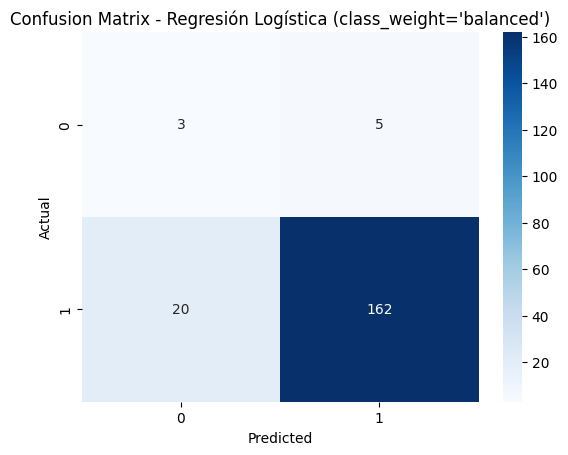


--- 3.1.2 Regresión Logística con Datos Remuestreados (SMOTE) ---
Tiempo de entrenamiento (SMOTE): 0.15 segundos

--- Evaluación: Regresión Logística (SMOTE) ---
Accuracy: 0.8684 (Objetivo > 0.80)
Precision: 0.9645
Recall: 0.8956
F1-score: 0.9288
ROC AUC: 0.6312

Classification Report:
              precision    recall  f1-score   support

           0       0.10      0.25      0.14         8
           1       0.96      0.90      0.93       182

    accuracy                           0.87       190
   macro avg       0.53      0.57      0.53       190
weighted avg       0.93      0.87      0.90       190


Confusion Matrix:


In [26]:
# --- 3.1 Modelo: Regresión Logística ---
print("\n\n==============================================================================")
print("=== Modelo 3.1: Regresión Logística ===")
print("==============================================================================")

# --- 3.1.1 Regresión Logística con class_weight='balanced' ---
print("\n--- 3.1.1 Regresión Logística con class_weight='balanced' (Datos Originales) ---")
try:
    start_time = time()
    log_reg_balanced = LogisticRegression(
        random_state=RANDOM_STATE, 
        solver='liblinear', # Bueno para datasets más pequeños o cuando l1 regularización es deseada
        max_iter=1000,      # Aumentar si hay problemas de convergencia
        class_weight='balanced'
    )
    log_reg_balanced.fit(X_train, y_train) # Entrenar con X_train original
    end_time = time()
    print(f"Tiempo de entrenamiento (class_weight='balanced'): {end_time - start_time:.2f} segundos")

    y_pred_val_lr_b = log_reg_balanced.predict(X_val)
    y_pred_proba_val_lr_b = log_reg_balanced.predict_proba(X_val)[:, 1]
    
    res_lr_b = evaluar_modelo(
        "Regresión Logística (class_weight='balanced')", 
        y_val, 
        y_pred_val_lr_b, 
        y_pred_proba_val_lr_b
    )
    resultados_modelos.append(res_lr_b)
    # Guardar modelo (opcional)
    # joblib.dump(log_reg_balanced, RUTA_DATOS_PROCESADOS + 'modelo_reglog_balanced.joblib')

except Exception as e:
    print(f"Error con Regresión Logística (class_weight='balanced'): {e}")

# --- 3.1.2 Regresión Logística con Datos Remuestreados (SMOTE) ---
print("\n--- 3.1.2 Regresión Logística con Datos Remuestreados (SMOTE) ---")
try:
    start_time = time()
    # Cuando se usan datos remuestreados, class_weight='balanced' podría no ser necesario o incluso redundante.
    # Se puede probar con y sin él en los datos remuestreados. Aquí lo omitimos.
    log_reg_smote = LogisticRegression(
        random_state=RANDOM_STATE, 
        solver='liblinear',
        max_iter=1000
    )
    log_reg_smote.fit(X_train_resampled, y_train_resampled) # Entrenar con datos SMOTE
    end_time = time()
    print(f"Tiempo de entrenamiento (SMOTE): {end_time - start_time:.2f} segundos")

    # IMPORTANTE: Evaluar siempre en el conjunto de validación ORIGINAL (X_val, y_val)
    y_pred_val_lr_smote = log_reg_smote.predict(X_val)
    y_pred_proba_val_lr_smote = log_reg_smote.predict_proba(X_val)[:, 1]
    
    res_lr_smote = evaluar_modelo(
        "Regresión Logística (SMOTE)", 
        y_val, 
        y_pred_val_lr_smote, 
        y_pred_proba_val_lr_smote
    )
    resultados_modelos.append(res_lr_smote)
    # Guardar modelo (opcional)
    # joblib.dump(log_reg_smote, RUTA_DATOS_PROCESADOS + 'modelo_reglog_smote.joblib')

except Exception as e:
    print(f"Error con Regresión Logística (SMOTE): {e}")

In [27]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# -----------------------------------------------
# Función general para buscar el mejor KNN con ENN
# -----------------------------------------------
def buscar_mejor_knn_con_enn(nombre_modelo, incluir_smote):
    print(f"\n--- GridSearchCV: {nombre_modelo} ---")

    try:
        steps = []
        if incluir_smote:
            steps.append(('smote', SMOTE(random_state=42)))
        steps.append(('enn', EditedNearestNeighbours(kind_sel='all')))
        steps.append(('knn', KNeighborsClassifier(n_jobs=-1)))

        pipeline = ImbPipeline(steps=steps)

        param_grid = {
            'enn__n_neighbors': [1, 3, 5, 7, 9],
            'knn__n_neighbors': list(range(1, 21))
        }

        grid = GridSearchCV(
            estimator=pipeline,
            param_grid=param_grid,
            cv=5,
            scoring='roc_auc',
            n_jobs=-1,
            verbose=2
        )

        start_time = time()
        grid.fit(X_train, y_train)
        end_time = time()

        best_params = grid.best_params_
        best_k = best_params['knn__n_neighbors']
        best_enn_k = best_params['enn__n_neighbors']

        print(f"\n✔ Mejor configuración para {nombre_modelo}:")
        print(f" - k para KNN: {best_k}")
        print(f" - k para ENN: {best_enn_k}")
        print(f"Tiempo total: {end_time - start_time:.2f} segundos")

        y_pred_val = grid.predict(X_val)
        y_proba_val = grid.predict_proba(X_val)[:, 1]

        res = evaluar_modelo(
            f"{nombre_modelo} (KNN-k={best_k}, ENN-k={best_enn_k})",
            y_val,
            y_pred_val,
            y_proba_val
        )
        resultados_modelos.append(res)

    except Exception as e:
        print(f"Error en {nombre_modelo}: {e}")


# ================================
# === 1. KNN + ENN (sin SMOTE) ===
# ================================
buscar_mejor_knn_con_enn("KNN + ENN (sin SMOTE)", incluir_smote=False)

# =======================================
# === 2. KNN + SMOTE + ENN (completo) ===
# =======================================
buscar_mejor_knn_con_enn("KNN + SMOTE + ENN", incluir_smote=True)



--- GridSearchCV: KNN + ENN (sin SMOTE) ---
Fitting 5 folds for each of 100 candidates, totalling 500 fits


KeyboardInterrupt: 



=== Modelo 3.3: Support Vector Machine (SVC) ===

--- 3.3.1 Support Vector Machine (Lineal, class_weight='balanced') ---
Tiempo de entrenamiento (Lineal, class_weight='balanced'): 0.09 segundos

--- Evaluación: SVC (Lineal, class_weight='balanced') ---
Accuracy: 0.8789 (Objetivo > 0.80)
Precision: 0.9649
Recall: 0.9066
F1-score: 0.9348
ROC AUC: 0.6243

Classification Report:
              precision    recall  f1-score   support

           0       0.11      0.25      0.15         8
           1       0.96      0.91      0.93       182

    accuracy                           0.88       190
   macro avg       0.54      0.58      0.54       190
weighted avg       0.93      0.88      0.90       190


Confusion Matrix:



--- 3.3.2 Support Vector Machine (Lineal, SMOTE) ---
Tiempo de entrenamiento (Lineal, SMOTE): 0.44 segundos

--- Evaluación: SVC (Lineal, SMOTE) ---
Accuracy: 0.8684 (Objetivo > 0.80)
Precision: 0.9645
Recall: 0.8956
F1-score: 0.9288
ROC AUC: 0.6350

Classification Report:
              precision    recall  f1-score   support

           0       0.10      0.25      0.14         8
           1       0.96      0.90      0.93       182

    accuracy                           0.87       190
   macro avg       0.53      0.57      0.53       190
weighted avg       0.93      0.87      0.90       190


Confusion Matrix:


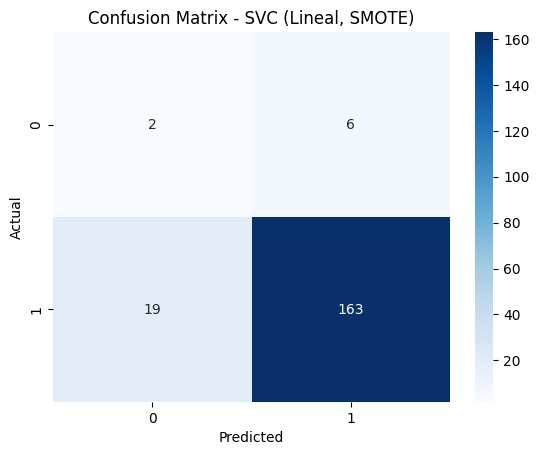

In [ ]:
# --- 3.3 Modelo: Support Vector Machine (SVC) ---
# NOTA: SVC puede ser lento, especialmente con kernel no lineal. Empezamos con lineal.
print("\n\n==============================================================================")
print("=== Modelo 3.3: Support Vector Machine (SVC) ===")
print("==============================================================================")

# --- 3.3.1 SVC con class_weight='balanced' (Kernel Lineal) ---
print("\n--- 3.3.1 Support Vector Machine (Lineal, class_weight='balanced') ---")
try:
    start_time = time()
    svc_linear_balanced = SVC(
        kernel='linear', 
        random_state=RANDOM_STATE, 
        probability=True, # Necesario para predict_proba
        class_weight='balanced'
    )
    svc_linear_balanced.fit(X_train, y_train)
    end_time = time()
    print(f"Tiempo de entrenamiento (Lineal, class_weight='balanced'): {end_time - start_time:.2f} segundos")
    
    y_pred_val_svc_lb = svc_linear_balanced.predict(X_val)
    y_pred_proba_val_svc_lb = svc_linear_balanced.predict_proba(X_val)[:, 1]

    res_svc_lb = evaluar_modelo(
        "SVC (Lineal, class_weight='balanced')", 
        y_val, 
        y_pred_val_svc_lb, 
        y_pred_proba_val_svc_lb
    )
    resultados_modelos.append(res_svc_lb)
except Exception as e:
    print(f"Error con SVC (Lineal, class_weight='balanced'): {e}")

# --- 3.3.2 SVC con Datos Remuestreados (SMOTE) (Kernel Lineal) ---
print("\n--- 3.3.2 Support Vector Machine (Lineal, SMOTE) ---")
try:
    start_time = time()
    svc_linear_smote = SVC(
        kernel='linear', 
        random_state=RANDOM_STATE, 
        probability=True
    )
    svc_linear_smote.fit(X_train_resampled, y_train_resampled)
    end_time = time()
    print(f"Tiempo de entrenamiento (Lineal, SMOTE): {end_time - start_time:.2f} segundos")
    
    y_pred_val_svc_ls = svc_linear_smote.predict(X_val)
    y_pred_proba_val_svc_ls = svc_linear_smote.predict_proba(X_val)[:, 1]

    res_svc_ls = evaluar_modelo(
        "SVC (Lineal, SMOTE)", 
        y_val, 
        y_pred_val_svc_ls, 
        y_pred_proba_val_svc_ls
    )
    resultados_modelos.append(res_svc_ls)
except Exception as e:
    print(f"Error con SVC (Lineal, SMOTE): {e}")


--- 3.3.3 Support Vector Machine (RBF, SMOTE) ---
Tiempo de entrenamiento (RBF, SMOTE): 0.39 segundos

--- Evaluación: SVC (RBF, SMOTE) ---
Accuracy: 0.9211 (Objetivo > 0.80)
Precision: 0.9563
Recall: 0.9615
F1-score: 0.9589
ROC AUC: 0.7163

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.96      0.96      0.96       182

    accuracy                           0.92       190
   macro avg       0.48      0.48      0.48       190
weighted avg       0.92      0.92      0.92       190


Confusion Matrix:


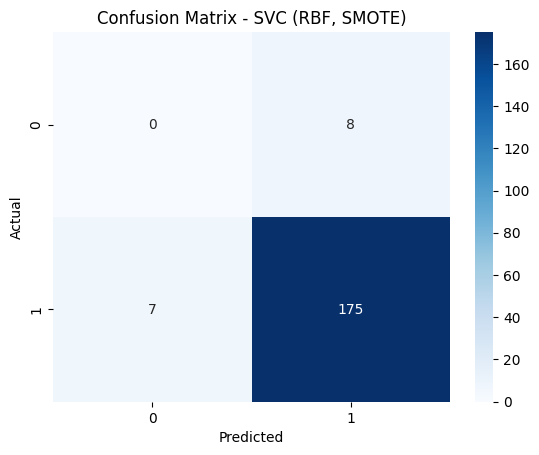

In [ ]:
# (Opcional: SVC con kernel RBF - puede ser muy lento)
print("\n--- 3.3.3 Support Vector Machine (RBF, SMOTE) ---")
try:
    start_time = time()
    svc_rbf_smote = SVC(kernel='rbf', random_state=RANDOM_STATE, probability=True)
    svc_rbf_smote.fit(X_train_resampled, y_train_resampled)
    end_time = time()
    print(f"Tiempo de entrenamiento (RBF, SMOTE): {end_time - start_time:.2f} segundos")
    y_pred_val_svc_rs = svc_rbf_smote.predict(X_val)
    y_pred_proba_val_svc_rs = svc_rbf_smote.predict_proba(X_val)[:, 1]
    res_svc_rs = evaluar_modelo("SVC (RBF, SMOTE)", y_val, y_pred_val_svc_rs, y_pred_proba_val_svc_rs)
    resultados_modelos.append(res_svc_rs)
except Exception as e:
    print(f"Error con SVC (RBF, SMOTE): {e}")



=== Modelo 3.4: Árbol de Decisión ===

--- 3.4.1 Árbol de Decisión (class_weight='balanced') ---
Tiempo de entrenamiento (class_weight='balanced'): 0.07 segundos

--- Evaluación: Árbol de Decisión (class_weight='balanced') ---
Accuracy: 0.9105 (Objetivo > 0.80)
Precision: 0.9609
Recall: 0.9451
F1-score: 0.9529
ROC AUC: 0.5350

Classification Report:
              precision    recall  f1-score   support

           0       0.09      0.12      0.11         8
           1       0.96      0.95      0.95       182

    accuracy                           0.91       190
   macro avg       0.53      0.54      0.53       190
weighted avg       0.92      0.91      0.92       190


Confusion Matrix:


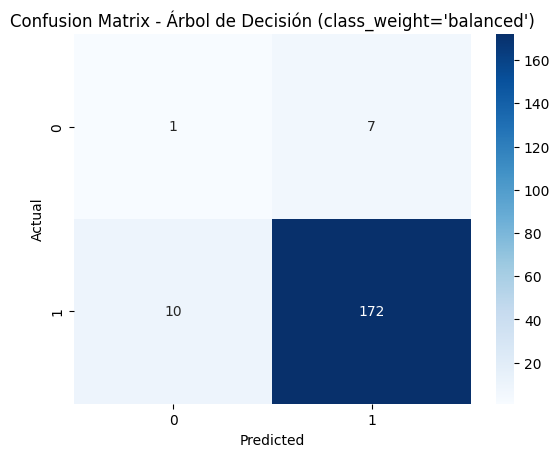


--- 3.4.2 Árbol de Decisión (SMOTE) ---
Tiempo de entrenamiento (SMOTE): 0.22 segundos

--- Evaluación: Árbol de Decisión (SMOTE) ---
Accuracy: 0.8421 (Objetivo > 0.80)
Precision: 0.9578
Recall: 0.8736
F1-score: 0.9138
ROC AUC: 0.4993

Classification Report:
              precision    recall  f1-score   support

           0       0.04      0.12      0.06         8
           1       0.96      0.87      0.91       182

    accuracy                           0.84       190
   macro avg       0.50      0.50      0.49       190
weighted avg       0.92      0.84      0.88       190


Confusion Matrix:


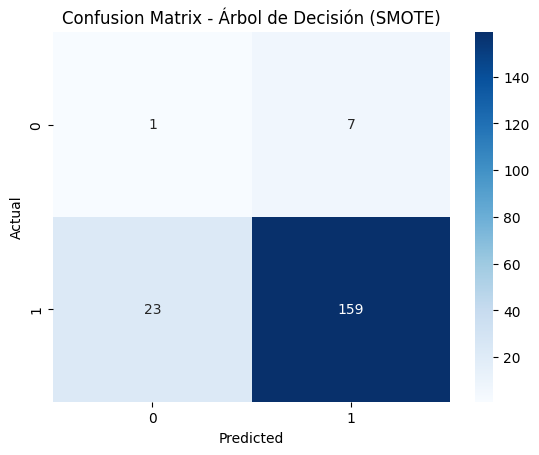

In [ ]:
# --- 3.4 Modelo: Árbol de Decisión ---
print("\n\n==============================================================================")
print("=== Modelo 3.4: Árbol de Decisión ===")
print("==============================================================================")

# --- 3.4.1 Árbol de Decisión con class_weight='balanced' ---
print("\n--- 3.4.1 Árbol de Decisión (class_weight='balanced') ---")
try:
    start_time = time()
    dt_clf_balanced = DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced')
    dt_clf_balanced.fit(X_train, y_train)
    end_time = time()
    print(f"Tiempo de entrenamiento (class_weight='balanced'): {end_time - start_time:.2f} segundos")

    y_pred_val_dt_b = dt_clf_balanced.predict(X_val)
    y_pred_proba_val_dt_b = dt_clf_balanced.predict_proba(X_val)[:, 1]

    res_dt_b = evaluar_modelo(
        "Árbol de Decisión (class_weight='balanced')", 
        y_val, 
        y_pred_val_dt_b, 
        y_pred_proba_val_dt_b
    )
    resultados_modelos.append(res_dt_b)
except Exception as e:
    print(f"Error con Árbol de Decisión (class_weight='balanced'): {e}")

# --- 3.4.2 Árbol de Decisión con Datos Remuestreados (SMOTE) ---
print("\n--- 3.4.2 Árbol de Decisión (SMOTE) ---")
try:
    start_time = time()
    dt_clf_smote = DecisionTreeClassifier(random_state=RANDOM_STATE) # class_weight no es necesario con SMOTE
    dt_clf_smote.fit(X_train_resampled, y_train_resampled)
    end_time = time()
    print(f"Tiempo de entrenamiento (SMOTE): {end_time - start_time:.2f} segundos")

    y_pred_val_dt_smote = dt_clf_smote.predict(X_val)
    y_pred_proba_val_dt_smote = dt_clf_smote.predict_proba(X_val)[:, 1]

    res_dt_smote = evaluar_modelo(
        "Árbol de Decisión (SMOTE)", 
        y_val, 
        y_pred_val_dt_smote, 
        y_pred_proba_val_dt_smote
    )
    resultados_modelos.append(res_dt_smote)
except Exception as e:
    print(f"Error con Árbol de Decisión (SMOTE): {e}")



=== Modelo 3.5: Random Forest ===

--- 3.5.1 Random Forest (class_weight='balanced') ---
Tiempo de entrenamiento (class_weight='balanced'): 0.15 segundos

--- Evaluación: Random Forest (class_weight='balanced') ---
Accuracy: 0.9579 (Objetivo > 0.80)
Precision: 0.9579
Recall: 1.0000
F1-score: 0.9785
ROC AUC: 0.8293

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.96      1.00      0.98       182

    accuracy                           0.96       190
   macro avg       0.48      0.50      0.49       190
weighted avg       0.92      0.96      0.94       190


Confusion Matrix:


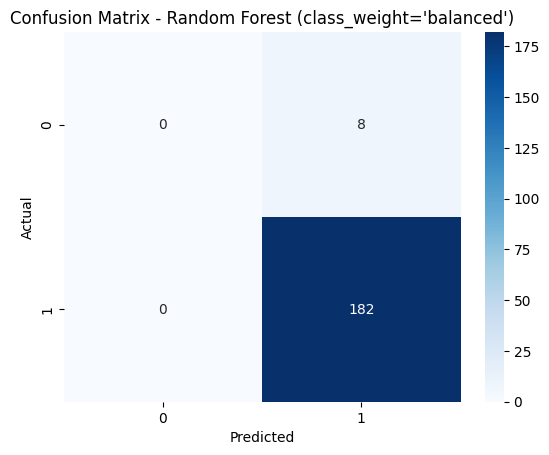


--- 3.5.2 Random Forest (SMOTE) ---
Tiempo de entrenamiento (SMOTE): 0.19 segundos

--- Evaluación: Random Forest (SMOTE) ---
Accuracy: 0.9474 (Objetivo > 0.80)
Precision: 0.9574
Recall: 0.9890
F1-score: 0.9730
ROC AUC: 0.8997

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.96      0.99      0.97       182

    accuracy                           0.95       190
   macro avg       0.48      0.49      0.49       190
weighted avg       0.92      0.95      0.93       190


Confusion Matrix:


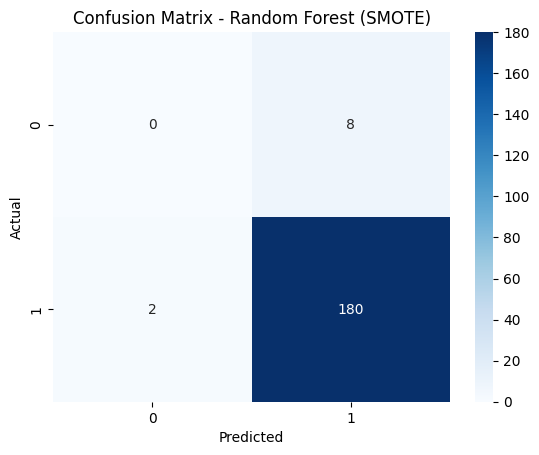

In [ ]:
# --- 3.5 Modelo: Random Forest ---
print("\n\n==============================================================================")
print("=== Modelo 3.5: Random Forest ===")
print("==============================================================================")

# --- 3.5.1 Random Forest con class_weight='balanced' ---
print("\n--- 3.5.1 Random Forest (class_weight='balanced') ---")
try:
    start_time = time()
    rf_clf_balanced = RandomForestClassifier(
        n_estimators=100,       # Número de árboles, buen punto de partida
        random_state=RANDOM_STATE, 
        n_jobs=-1,              # Usar todos los procesadores disponibles
        class_weight='balanced' # O 'balanced_subsample' si el dataset es muy grande
    )
    rf_clf_balanced.fit(X_train, y_train) # Entrenar con X_train original
    end_time = time()
    print(f"Tiempo de entrenamiento (class_weight='balanced'): {end_time - start_time:.2f} segundos")

    y_pred_val_rf_b = rf_clf_balanced.predict(X_val)
    y_pred_proba_val_rf_b = rf_clf_balanced.predict_proba(X_val)[:, 1]

    res_rf_b = evaluar_modelo(
        "Random Forest (class_weight='balanced')", 
        y_val, 
        y_pred_val_rf_b, 
        y_pred_proba_val_rf_b
    )
    resultados_modelos.append(res_rf_b)
    # joblib.dump(rf_clf_balanced, RUTA_DATOS_PROCESADOS + 'modelo_rf_balanced.joblib')
except Exception as e:
    print(f"Error con Random Forest (class_weight='balanced'): {e}")

# --- 3.5.2 Random Forest con Datos Remuestreados (SMOTE) ---
print("\n--- 3.5.2 Random Forest (SMOTE) ---")
try:
    start_time = time()
    rf_clf_smote = RandomForestClassifier(
        n_estimators=100, 
        random_state=RANDOM_STATE, 
        n_jobs=-1
        # class_weight no es usualmente necesario aquí porque SMOTE ya balanceó
    )
    rf_clf_smote.fit(X_train_resampled, y_train_resampled) # Entrenar con datos SMOTE
    end_time = time()
    print(f"Tiempo de entrenamiento (SMOTE): {end_time - start_time:.2f} segundos")

    y_pred_val_rf_smote = rf_clf_smote.predict(X_val) # Evaluar en X_val original
    y_pred_proba_val_rf_smote = rf_clf_smote.predict_proba(X_val)[:, 1]

    res_rf_smote = evaluar_modelo(
        "Random Forest (SMOTE)", 
        y_val, 
        y_pred_val_rf_smote, 
        y_pred_proba_val_rf_smote
    )
    resultados_modelos.append(res_rf_smote)
    # joblib.dump(rf_clf_smote, RUTA_DATOS_PROCESADOS + 'modelo_rf_smote.joblib')
except Exception as e:
    print(f"Error con Random Forest (SMOTE): {e}")




=== Modelo 3.6: Extra Trees Classifier ===

--- 3.6.1 Extra Trees (class_weight='balanced') ---
Tiempo de entrenamiento (class_weight='balanced'): 0.14 segundos

--- Evaluación: Extra Trees (class_weight='balanced') ---
Accuracy: 0.9421 (Objetivo > 0.80)
Precision: 0.9572
Recall: 0.9835
F1-score: 0.9702
ROC AUC: 0.8558

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.96      0.98      0.97       182

    accuracy                           0.94       190
   macro avg       0.48      0.49      0.49       190
weighted avg       0.92      0.94      0.93       190


Confusion Matrix:


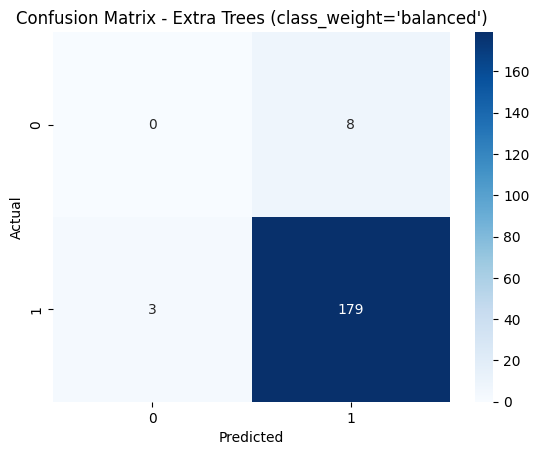


--- 3.6.2 Extra Trees (SMOTE) ---
Tiempo de entrenamiento (SMOTE): 0.11 segundos

--- Evaluación: Extra Trees (SMOTE) ---
Accuracy: 0.9421 (Objetivo > 0.80)
Precision: 0.9572
Recall: 0.9835
F1-score: 0.9702
ROC AUC: 0.8516

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.96      0.98      0.97       182

    accuracy                           0.94       190
   macro avg       0.48      0.49      0.49       190
weighted avg       0.92      0.94      0.93       190


Confusion Matrix:


In [ ]:
# --- 3.6 Modelo: Extra Trees Classifier ---
print("\n\n==============================================================================")
print("=== Modelo 3.6: Extra Trees Classifier ===")
print("==============================================================================")

# --- 3.6.1 Extra Trees con class_weight='balanced' ---
print("\n--- 3.6.1 Extra Trees (class_weight='balanced') ---")
try:
    start_time = time()
    et_clf_balanced = ExtraTreesClassifier(
        n_estimators=100, 
        random_state=RANDOM_STATE, 
        n_jobs=-1, 
        class_weight='balanced'
    )
    et_clf_balanced.fit(X_train, y_train)
    end_time = time()
    print(f"Tiempo de entrenamiento (class_weight='balanced'): {end_time - start_time:.2f} segundos")

    y_pred_val_et_b = et_clf_balanced.predict(X_val)
    y_pred_proba_val_et_b = et_clf_balanced.predict_proba(X_val)[:, 1]

    res_et_b = evaluar_modelo(
        "Extra Trees (class_weight='balanced')", 
        y_val, 
        y_pred_val_et_b, 
        y_pred_proba_val_et_b
    )
    resultados_modelos.append(res_et_b)
except Exception as e:
    print(f"Error con Extra Trees (class_weight='balanced'): {e}")

# --- 3.6.2 Extra Trees con Datos Remuestreados (SMOTE) ---
print("\n--- 3.6.2 Extra Trees (SMOTE) ---")
try:
    start_time = time()
    et_clf_smote = ExtraTreesClassifier(
        n_estimators=100, 
        random_state=RANDOM_STATE, 
        n_jobs=-1
    )
    et_clf_smote.fit(X_train_resampled, y_train_resampled)
    end_time = time()
    print(f"Tiempo de entrenamiento (SMOTE): {end_time - start_time:.2f} segundos")

    y_pred_val_et_smote = et_clf_smote.predict(X_val)
    y_pred_proba_val_et_smote = et_clf_smote.predict_proba(X_val)[:, 1]

    res_et_smote = evaluar_modelo(
        "Extra Trees (SMOTE)", 
        y_val, 
        y_pred_val_et_smote, 
        y_pred_proba_val_et_smote
    )
    resultados_modelos.append(res_et_smote)
except Exception as e:
    print(f"Error con Extra Trees (SMOTE): {e}")



=== Modelo 3.7: AdaBoost Classifier ===

--- 3.7.1 AdaBoost (Estimador Base con class_weight='balanced') ---
Tiempo de entrenamiento (Estimador Base Bal., max_depth=2): 0.10 segundos

--- Evaluación: AdaBoost (Base Bal. D2, SAMME) ---
Accuracy: 0.6316 (Objetivo > 0.80)
Precision: 1.0000
Recall: 0.6154
F1-score: 0.7619
ROC AUC: 0.9066

Classification Report:
              precision    recall  f1-score   support

           0       0.10      1.00      0.19         8
           1       1.00      0.62      0.76       182

    accuracy                           0.63       190
   macro avg       0.55      0.81      0.47       190
weighted avg       0.96      0.63      0.74       190


Confusion Matrix:


c:\Users\alexg\Documents\code\datathon2025\NaN-Crew-Datathon-2025-OXXO\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


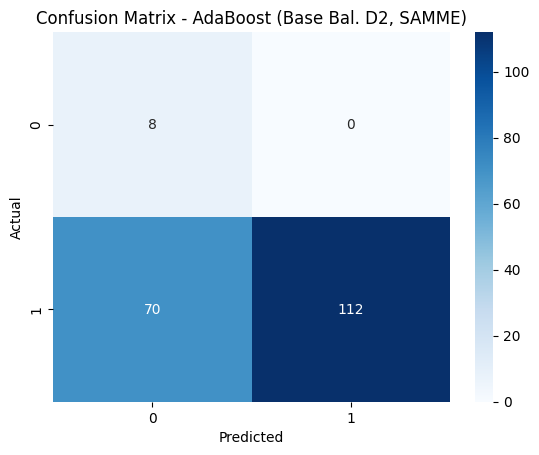


--- 3.7.2 AdaBoost (SMOTE) ---


c:\Users\alexg\Documents\code\datathon2025\NaN-Crew-Datathon-2025-OXXO\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


Tiempo de entrenamiento (SMOTE, SAMME): 1.58 segundos

--- Evaluación: AdaBoost (SMOTE, SAMME) ---
Accuracy: 0.9368 (Objetivo > 0.80)
Precision: 0.9722
Recall: 0.9615
F1-score: 0.9669
ROC AUC: 0.9117

Classification Report:
              precision    recall  f1-score   support

           0       0.30      0.38      0.33         8
           1       0.97      0.96      0.97       182

    accuracy                           0.94       190
   macro avg       0.64      0.67      0.65       190
weighted avg       0.94      0.94      0.94       190


Confusion Matrix:


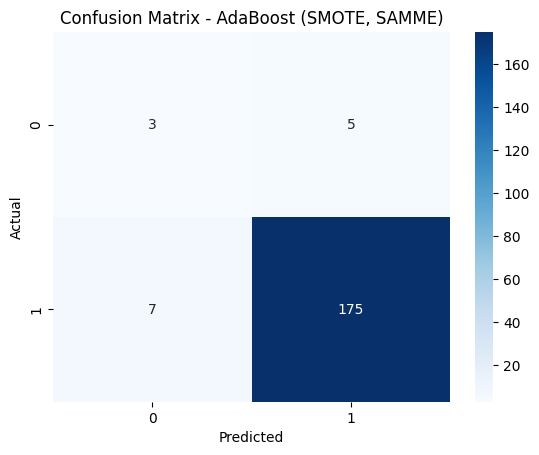

In [ ]:
# --- 3.7 Modelo: AdaBoost Classifier ---
print("\n\n==============================================================================")
print("=== Modelo 3.7: AdaBoost Classifier ===")
print("==============================================================================")

# --- 3.7.1 AdaBoost con estimador base con class_weight='balanced' ---
print("\n--- 3.7.1 AdaBoost (Estimador Base con class_weight='balanced') ---")
try:
    start_time = time()
    # Intentar con un estimador base un poco más complejo
    base_estimator_ada_balanced = DecisionTreeClassifier(
        max_depth=2, # Probando con max_depth=2 en lugar de 1
        class_weight='balanced', 
        random_state=RANDOM_STATE
    )
    
    ada_clf_balanced_base = AdaBoostClassifier(
        estimator=base_estimator_ada_balanced, # Para sklearn >= 1.2
        # base_estimator=base_estimator_ada_balanced, # Para sklearn < 1.2
        n_estimators=50,
        random_state=RANDOM_STATE,
        algorithm='SAMME' # Usar SAMME si SAMME.R da problemas con el base estimator
                          # o si el base estimator no tiene un predict_proba robusto
    )
    ada_clf_balanced_base.fit(X_train, y_train)
    end_time = time()
    print(f"Tiempo de entrenamiento (Estimador Base Bal., max_depth=2): {end_time - start_time:.2f} segundos")

    y_pred_val_ada_bb = ada_clf_balanced_base.predict(X_val)
    # AdaBoost con SAMME y DecisionTreeClassifier sí debería tener predict_proba
    if hasattr(ada_clf_balanced_base, "predict_proba"):
        y_pred_proba_val_ada_bb = ada_clf_balanced_base.predict_proba(X_val)[:, 1]
    else:
        y_pred_proba_val_ada_bb = None # No se puede calcular ROC AUC

    res_ada_bb = evaluar_modelo(
        "AdaBoost (Base Bal. D2, SAMME)", 
        y_val, 
        y_pred_val_ada_bb, 
        y_pred_proba_val_ada_bb
    )
    resultados_modelos.append(res_ada_bb)
except Exception as e:
    print(f"Error con AdaBoost (Base Bal.): {e}")

# --- 3.7.2 AdaBoost con Datos Remuestreados (SMOTE) ---
print("\n--- 3.7.2 AdaBoost (SMOTE) ---")
try:
    start_time = time()
    # Con datos SMOTE, el estimador base no necesita class_weight='balanced'
    base_estimator_ada_smote = DecisionTreeClassifier(max_depth=1, random_state=RANDOM_STATE) # Podemos probar con max_depth=1 o 2
    
    ada_clf_smote = AdaBoostClassifier(
        estimator=base_estimator_ada_smote, # o base_estimator para sklearn < 1.2
        n_estimators=50, 
        random_state=RANDOM_STATE,
        algorithm='SAMME' # Cambiado a SAMME para asegurar compatibilidad
    )
    ada_clf_smote.fit(X_train_resampled, y_train_resampled)
    end_time = time()
    print(f"Tiempo de entrenamiento (SMOTE, SAMME): {end_time - start_time:.2f} segundos")

    y_pred_val_ada_smote = ada_clf_smote.predict(X_val)
    if hasattr(ada_clf_smote, "predict_proba"):
        y_pred_proba_val_ada_smote = ada_clf_smote.predict_proba(X_val)[:, 1]
    else:
        y_pred_proba_val_ada_smote = None

    res_ada_smote = evaluar_modelo(
        "AdaBoost (SMOTE, SAMME)", 
        y_val, 
        y_pred_val_ada_smote, 
        y_pred_proba_val_ada_smote
    )
    resultados_modelos.append(res_ada_smote)
except Exception as e:
    print(f"Error con AdaBoost (SMOTE): {e}")



=== Modelo 3.8: Gradient Boosting Classifier (Scikit-learn) ===

--- 3.8.1 Gradient Boosting (Datos Originales) ---
Tiempo de entrenamiento (Datos Originales): 3.01 segundos

--- Evaluación: Gradient Boosting (sklearn, Original) ---
Accuracy: 0.9421 (Objetivo > 0.80)
Precision: 0.9572
Recall: 0.9835
F1-score: 0.9702
ROC AUC: 0.8578

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.96      0.98      0.97       182

    accuracy                           0.94       190
   macro avg       0.48      0.49      0.49       190
weighted avg       0.92      0.94      0.93       190


Confusion Matrix:


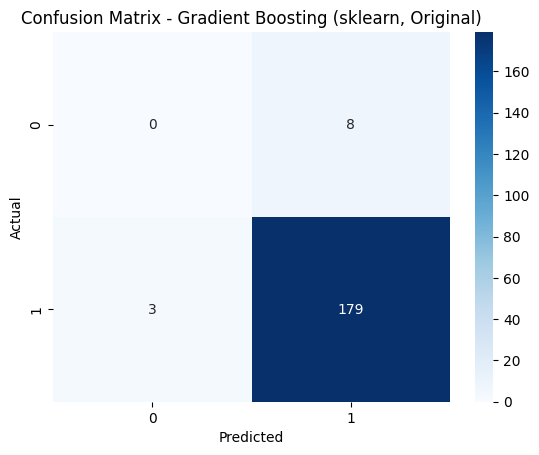


--- 3.8.2 Gradient Boosting (SMOTE) ---


KeyboardInterrupt: 

In [ ]:
# --- 3.8 Modelo: Gradient Boosting Classifier (Scikit-learn) ---
# No tiene class_weight directo. Dependerá de SMOTE.
print("\n\n==============================================================================")
print("=== Modelo 3.8: Gradient Boosting Classifier (Scikit-learn) ===")
print("==============================================================================")

# --- 3.8.1 Gradient Boosting con Datos Originales ---
print("\n--- 3.8.1 Gradient Boosting (Datos Originales) ---")
try:
    start_time = time()
    gb_clf_orig = GradientBoostingClassifier(n_estimators=100, random_state=RANDOM_STATE)
    gb_clf_orig.fit(X_train, y_train)
    end_time = time()
    print(f"Tiempo de entrenamiento (Datos Originales): {end_time - start_time:.2f} segundos")

    y_pred_val_gb_orig = gb_clf_orig.predict(X_val)
    y_pred_proba_val_gb_orig = gb_clf_orig.predict_proba(X_val)[:, 1]

    res_gb_orig = evaluar_modelo(
        "Gradient Boosting (sklearn, Original)", 
        y_val, 
        y_pred_val_gb_orig, 
        y_pred_proba_val_gb_orig
    )
    resultados_modelos.append(res_gb_orig)
except Exception as e:
    print(f"Error con Gradient Boosting (sklearn, Original): {e}")

# --- 3.8.2 Gradient Boosting con Datos Remuestreados (SMOTE) ---
print("\n--- 3.8.2 Gradient Boosting (SMOTE) ---")
try:
    start_time = time()
    gb_clf_smote = GradientBoostingClassifier(n_estimators=100, random_state=RANDOM_STATE)
    gb_clf_smote.fit(X_train_resampled, y_train_resampled)
    end_time = time()
    print(f"Tiempo de entrenamiento (SMOTE): {end_time - start_time:.2f} segundos")

    y_pred_val_gb_smote = gb_clf_smote.predict(X_val)
    y_pred_proba_val_gb_smote = gb_clf_smote.predict_proba(X_val)[:, 1]

    res_gb_smote = evaluar_modelo(
        "Gradient Boosting (sklearn, SMOTE)", 
        y_val, 
        y_pred_val_gb_smote, 
        y_pred_proba_val_gb_smote
    )
    resultados_modelos.append(res_gb_smote)
except Exception as e:
    print(f"Error con Gradient Boosting (sklearn, SMOTE): {e}")



=== Modelo 3.9: Gaussian Naive Bayes ===

--- 3.9.1 Gaussian Naive Bayes (Datos Originales) ---
Tiempo de entrenamiento (Datos Originales): 0.01 segundos

--- Evaluación: Gaussian Naive Bayes (Original) ---
Accuracy: 0.4158 (Objetivo > 0.80)
Precision: 0.9733
Recall: 0.4011
F1-score: 0.5681
ROC AUC: 0.7170

Classification Report:
              precision    recall  f1-score   support

           0       0.05      0.75      0.10         8
           1       0.97      0.40      0.57       182

    accuracy                           0.42       190
   macro avg       0.51      0.58      0.33       190
weighted avg       0.93      0.42      0.55       190


Confusion Matrix:


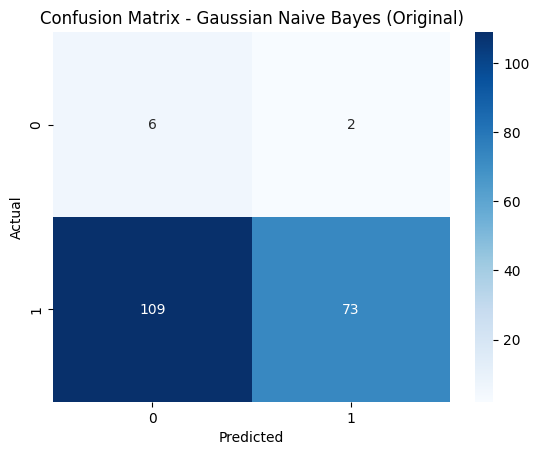


--- 3.9.2 Gaussian Naive Bayes (SMOTE) ---
Tiempo de entrenamiento (SMOTE): 0.01 segundos

--- Evaluación: Gaussian Naive Bayes (SMOTE) ---
Accuracy: 0.4947 (Objetivo > 0.80)
Precision: 0.9778
Recall: 0.4835
F1-score: 0.6471
ROC AUC: 0.7060

Classification Report:
              precision    recall  f1-score   support

           0       0.06      0.75      0.11         8
           1       0.98      0.48      0.65       182

    accuracy                           0.49       190
   macro avg       0.52      0.62      0.38       190
weighted avg       0.94      0.49      0.62       190


Confusion Matrix:


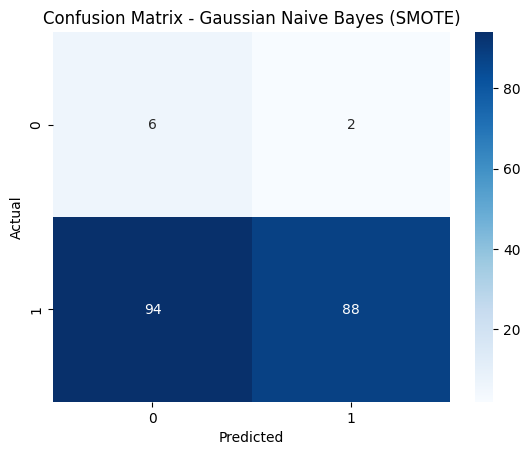

In [ ]:
# --- 3.9 Modelo: Naive Bayes (GaussianNB) ---
# No tiene class_weight. Dependerá de SMOTE. Asume features normales.
print("\n\n==============================================================================")
print("=== Modelo 3.9: Gaussian Naive Bayes ===")
print("==============================================================================")

# Necesita arrays NumPy, X_train y X_val ya podrían serlo si la conversión a DF falló antes.
X_train_nb_conv = X_train.values if isinstance(X_train, pd.DataFrame) else X_train
X_val_nb_conv = X_val.values if isinstance(X_val, pd.DataFrame) else X_val
X_train_resampled_nb_conv = X_train_resampled.values if isinstance(X_train_resampled, pd.DataFrame) else X_train_resampled


# --- 3.9.1 Gaussian Naive Bayes con Datos Originales ---
print("\n--- 3.9.1 Gaussian Naive Bayes (Datos Originales) ---")
try:
    start_time = time()
    gnb_clf_orig = GaussianNB()
    gnb_clf_orig.fit(X_train_nb_conv, y_train)
    end_time = time()
    print(f"Tiempo de entrenamiento (Datos Originales): {end_time - start_time:.2f} segundos")

    y_pred_val_gnb_orig = gnb_clf_orig.predict(X_val_nb_conv)
    y_pred_proba_val_gnb_orig = gnb_clf_orig.predict_proba(X_val_nb_conv)[:, 1]

    res_gnb_orig = evaluar_modelo(
        "Gaussian Naive Bayes (Original)", 
        y_val, 
        y_pred_val_gnb_orig, 
        y_pred_proba_val_gnb_orig
    )
    resultados_modelos.append(res_gnb_orig)
except Exception as e:
    print(f"Error con Gaussian Naive Bayes (Original): {e}")

# --- 3.9.2 Gaussian Naive Bayes con Datos Remuestreados (SMOTE) ---
print("\n--- 3.9.2 Gaussian Naive Bayes (SMOTE) ---")
try:
    start_time = time()
    gnb_clf_smote = GaussianNB()
    gnb_clf_smote.fit(X_train_resampled_nb_conv, y_train_resampled)
    end_time = time()
    print(f"Tiempo de entrenamiento (SMOTE): {end_time - start_time:.2f} segundos")

    y_pred_val_gnb_smote = gnb_clf_smote.predict(X_val_nb_conv)
    y_pred_proba_val_gnb_smote = gnb_clf_smote.predict_proba(X_val_nb_conv)[:, 1]

    res_gnb_smote = evaluar_modelo(
        "Gaussian Naive Bayes (SMOTE)", 
        y_val, 
        y_pred_val_gnb_smote, 
        y_pred_proba_val_gnb_smote
    )
    resultados_modelos.append(res_gnb_smote)
except Exception as e:
    print(f"Error con Gaussian Naive Bayes (SMOTE): {e}")




=== Modelo 3.10: SGD Classifier ===

--- 3.10.1 SGD Classifier (Log Loss, class_weight='balanced') ---
Tiempo de entrenamiento (class_weight='balanced'): 0.01 segundos

--- Evaluación: SGD Classifier (Log Loss, Bal.) ---
Accuracy: 0.7158 (Objetivo > 0.80)
Precision: 0.9776
Recall: 0.7198
F1-score: 0.8291
ROC AUC: 0.6631

Classification Report:
              precision    recall  f1-score   support

           0       0.09      0.62      0.16         8
           1       0.98      0.72      0.83       182

    accuracy                           0.72       190
   macro avg       0.53      0.67      0.49       190
weighted avg       0.94      0.72      0.80       190


Confusion Matrix:


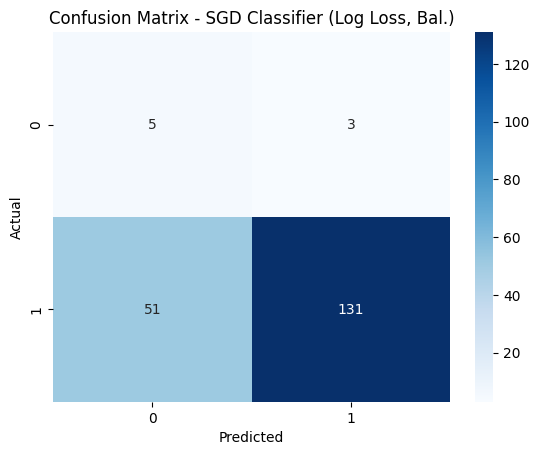


--- 3.10.2 SGD Classifier (Log Loss, SMOTE) ---
Tiempo de entrenamiento (SMOTE): 0.03 segundos

--- Evaluación: SGD Classifier (Log Loss, SMOTE) ---
Accuracy: 0.9000 (Objetivo > 0.80)
Precision: 0.9605
Recall: 0.9341
F1-score: 0.9471
ROC AUC: 0.6003

Classification Report:
              precision    recall  f1-score   support

           0       0.08      0.12      0.10         8
           1       0.96      0.93      0.95       182

    accuracy                           0.90       190
   macro avg       0.52      0.53      0.52       190
weighted avg       0.92      0.90      0.91       190


Confusion Matrix:


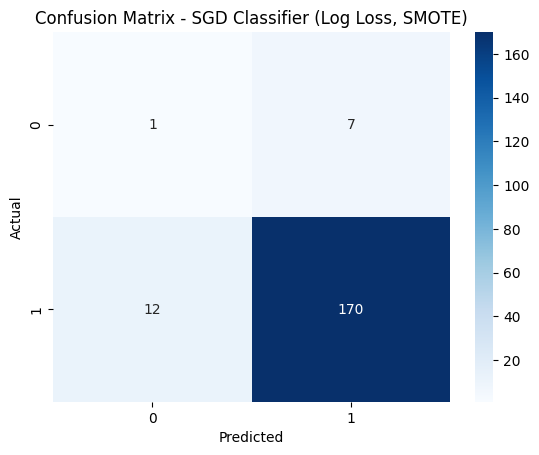

In [ ]:
# --- 3.10 Modelo: SGD Classifier (Entrenamiento con Gradiente Descendente Estocástico) ---
print("\n\n==============================================================================")
print("=== Modelo 3.10: SGD Classifier ===")
print("==============================================================================")

# --- 3.10.1 SGD Classifier con class_weight='balanced' ---
print("\n--- 3.10.1 SGD Classifier (Log Loss, class_weight='balanced') ---")
try:
    start_time = time()
    sgd_clf_balanced = SGDClassifier(
        loss='log_loss', # Para comportamiento similar a Regresión Logística
        random_state=RANDOM_STATE, 
        max_iter=1000, # Iteraciones sobre los datos
        tol=1e-3,      # Tolerancia para convergencia
        class_weight='balanced',
        n_jobs=-1      # Paralelizar si es posible
    )
    sgd_clf_balanced.fit(X_train, y_train)
    end_time = time()
    print(f"Tiempo de entrenamiento (class_weight='balanced'): {end_time - start_time:.2f} segundos")

    y_pred_val_sgd_b = sgd_clf_balanced.predict(X_val)
    y_pred_proba_val_sgd_b = sgd_clf_balanced.predict_proba(X_val)[:, 1]

    res_sgd_b = evaluar_modelo(
        "SGD Classifier (Log Loss, Bal.)", 
        y_val, 
        y_pred_val_sgd_b, 
        y_pred_proba_val_sgd_b
    )
    resultados_modelos.append(res_sgd_b)
except Exception as e:
    print(f"Error con SGD Classifier (class_weight='balanced'): {e}")

# --- 3.10.2 SGD Classifier con Datos Remuestreados (SMOTE) ---
print("\n--- 3.10.2 SGD Classifier (Log Loss, SMOTE) ---")
try:
    start_time = time()
    sgd_clf_smote = SGDClassifier(
        loss='log_loss', 
        random_state=RANDOM_STATE, 
        max_iter=1000, 
        tol=1e-3,
        n_jobs=-1
    )
    sgd_clf_smote.fit(X_train_resampled, y_train_resampled)
    end_time = time()
    print(f"Tiempo de entrenamiento (SMOTE): {end_time - start_time:.2f} segundos")

    y_pred_val_sgd_smote = sgd_clf_smote.predict(X_val)
    y_pred_proba_val_sgd_smote = sgd_clf_smote.predict_proba(X_val)[:, 1]

    res_sgd_smote = evaluar_modelo(
        "SGD Classifier (Log Loss, SMOTE)", 
        y_val, 
        y_pred_val_sgd_smote, 
        y_pred_proba_val_sgd_smote
    )
    resultados_modelos.append(res_sgd_smote)
except Exception as e:
    print(f"Error con SGD Classifier (SMOTE): {e}")



=== Modelo 3.11: XGBoost Classifier ===
XGBoost (Original): scale_pos_weight = 0.05

--- 3.11.1 XGBoost (scale_pos_weight, Datos Originales) ---


c:\Users\alexg\Documents\code\datathon2025\NaN-Crew-Datathon-2025-OXXO\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [03:48:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Tiempo de entrenamiento (scale_pos_weight): 0.41 segundos

--- Evaluación: XGBoost (scale_pos_weight) ---
Accuracy: 0.9316 (Objetivo > 0.80)
Precision: 0.9774
Recall: 0.9505
F1-score: 0.9638
ROC AUC: 0.9557

Classification Report:
              precision    recall  f1-score   support

           0       0.31      0.50      0.38         8
           1       0.98      0.95      0.96       182

    accuracy                           0.93       190
   macro avg       0.64      0.73      0.67       190
weighted avg       0.95      0.93      0.94       190


Confusion Matrix:


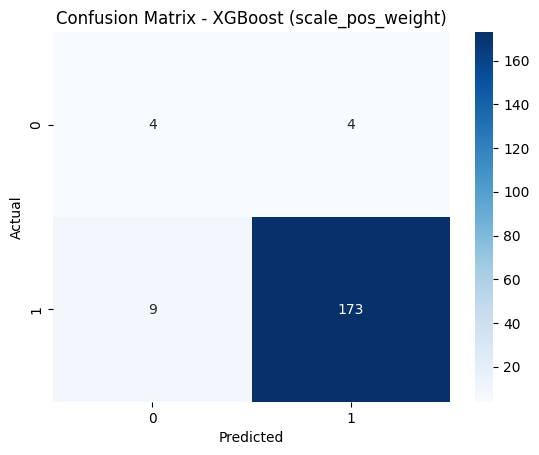


--- 3.11.2 XGBoost (SMOTE) ---


c:\Users\alexg\Documents\code\datathon2025\NaN-Crew-Datathon-2025-OXXO\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [03:48:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Tiempo de entrenamiento (SMOTE): 0.62 segundos

--- Evaluación: XGBoost (SMOTE) ---
Accuracy: 0.9579 (Objetivo > 0.80)
Precision: 0.9628
Recall: 0.9945
F1-score: 0.9784
ROC AUC: 0.9368

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.12      0.20         8
           1       0.96      0.99      0.98       182

    accuracy                           0.96       190
   macro avg       0.73      0.56      0.59       190
weighted avg       0.94      0.96      0.95       190


Confusion Matrix:


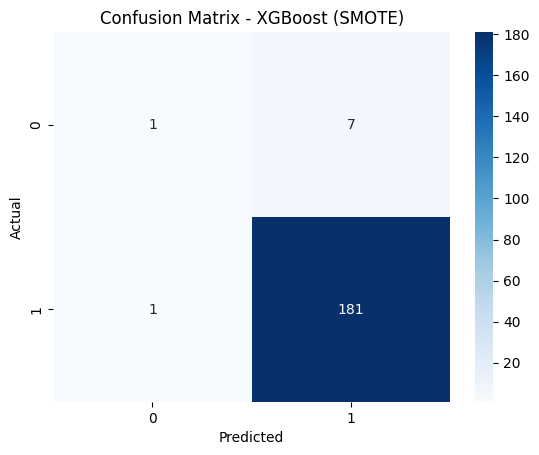

In [ ]:
# --- 3.11 Modelo: XGBoost Classifier ---
if xgb:
    print("\n\n==============================================================================")
    print("=== Modelo 3.11: XGBoost Classifier ===")
    print("==============================================================================")
    
    # Calcular scale_pos_weight para datos originales
    count_neg_orig, count_pos_orig = y_train.value_counts().sort_index()
    scale_pos_w_orig = count_neg_orig / count_pos_orig
    print(f"XGBoost (Original): scale_pos_weight = {scale_pos_w_orig:.2f}")

    # --- 3.11.1 XGBoost con scale_pos_weight (Datos Originales) ---
    print("\n--- 3.11.1 XGBoost (scale_pos_weight, Datos Originales) ---")
    try:
        start_time = time()
        xgb_clf_orig = xgb.XGBClassifier(
            random_state=RANDOM_STATE, 
            use_label_encoder=False, # Configuración recomendada para versiones recientes
            eval_metric='logloss',   # Métrica de evaluación interna
            scale_pos_weight=scale_pos_w_orig
        )
        xgb_clf_orig.fit(X_train, y_train)
        end_time = time()
        print(f"Tiempo de entrenamiento (scale_pos_weight): {end_time - start_time:.2f} segundos")

        y_pred_val_xgb_orig = xgb_clf_orig.predict(X_val)
        y_pred_proba_val_xgb_orig = xgb_clf_orig.predict_proba(X_val)[:, 1]

        res_xgb_orig = evaluar_modelo(
            "XGBoost (scale_pos_weight)", 
            y_val, 
            y_pred_val_xgb_orig, 
            y_pred_proba_val_xgb_orig
        )
        resultados_modelos.append(res_xgb_orig)
    except Exception as e:
        print(f"Error con XGBoost (scale_pos_weight): {e}")

    # --- 3.11.2 XGBoost con Datos Remuestreados (SMOTE) ---
    print("\n--- 3.11.2 XGBoost (SMOTE) ---")
    try:
        start_time = time()
        # Con datos SMOTE, scale_pos_weight usualmente no es necesario (o se pone a 1)
        xgb_clf_smote = xgb.XGBClassifier(
            random_state=RANDOM_STATE, 
            use_label_encoder=False,
            eval_metric='logloss'
        )
        xgb_clf_smote.fit(X_train_resampled, y_train_resampled)
        end_time = time()
        print(f"Tiempo de entrenamiento (SMOTE): {end_time - start_time:.2f} segundos")

        y_pred_val_xgb_smote = xgb_clf_smote.predict(X_val)
        y_pred_proba_val_xgb_smote = xgb_clf_smote.predict_proba(X_val)[:, 1]

        res_xgb_smote = evaluar_modelo(
            "XGBoost (SMOTE)", 
            y_val, 
            y_pred_val_xgb_smote, 
            y_pred_proba_val_xgb_smote
        )
        resultados_modelos.append(res_xgb_smote)
    except Exception as e:
        print(f"Error con XGBoost (SMOTE): {e}")
else:
    print("\n\nXGBoost no está instalado, se omite esta sección.")



=== Modelo 3.12: LightGBM Classifier ===

--- 3.12.1 LightGBM (class_weight='balanced', Datos Originales) ---
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 723, number of negative: 33
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005452 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 41056
[LightGBM] [Info] Number of data points in the train set: 756, number of used features: 313
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

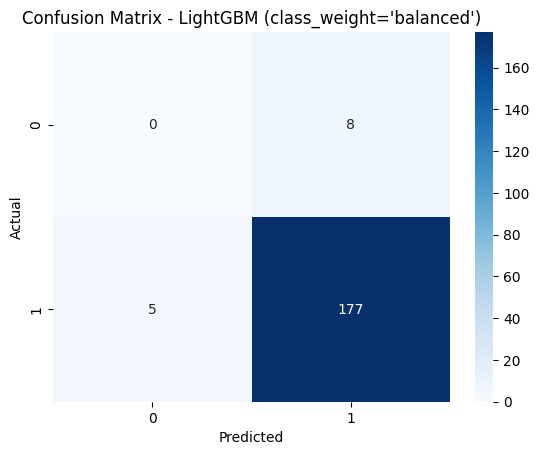


--- 3.12.2 LightGBM (SMOTE) ---
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 723, number of negative: 723
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008305 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 68241
[LightGBM] [Info] Number of data points in the train set: 1446, number of used features: 316
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Tiempo de entrenamiento (SMOTE): 0.80 segundos

--- Evaluación: LightGBM (SMOTE) ---
Accuracy: 0.9474 (Objetivo > 0.80)
Precision: 0.9574
Recall: 0.9890
F1-score: 0.9730
ROC AUC: 0.9203

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.96      0.99      0.97       182

    accuracy                           0.95       190
   macro avg       0.48

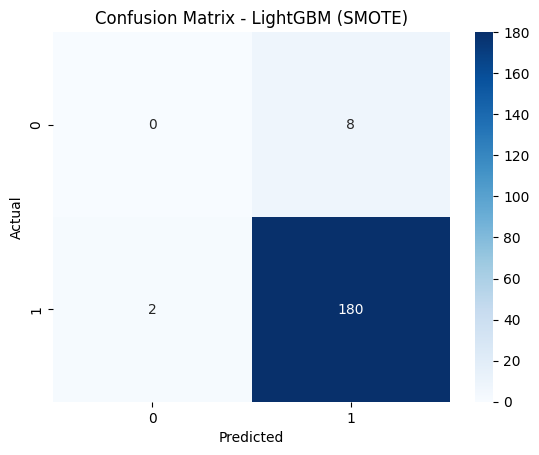

In [ ]:
# --- 3.12 Modelo: LightGBM Classifier ---
if lgb:
    print("\n\n==============================================================================")
    print("=== Modelo 3.12: LightGBM Classifier ===")
    print("==============================================================================")

    # --- 3.12.1 LightGBM con class_weight='balanced' (Datos Originales) ---
    print("\n--- 3.12.1 LightGBM (class_weight='balanced', Datos Originales) ---")
    try:
        start_time = time()
        lgbm_clf_balanced = lgb.LGBMClassifier(
            random_state=RANDOM_STATE, 
            n_jobs=-1, 
            class_weight='balanced' # O is_unbalance=True
        )
        lgbm_clf_balanced.fit(X_train, y_train)
        end_time = time()
        print(f"Tiempo de entrenamiento (class_weight='balanced'): {end_time - start_time:.2f} segundos")

        y_pred_val_lgbm_b = lgbm_clf_balanced.predict(X_val)
        y_pred_proba_val_lgbm_b = lgbm_clf_balanced.predict_proba(X_val)[:, 1]

        res_lgbm_b = evaluar_modelo(
            "LightGBM (class_weight='balanced')", 
            y_val, 
            y_pred_val_lgbm_b, 
            y_pred_proba_val_lgbm_b
        )
        resultados_modelos.append(res_lgbm_b)
    except Exception as e:
        print(f"Error con LightGBM (class_weight='balanced'): {e}")

    # --- 3.12.2 LightGBM con Datos Remuestreados (SMOTE) ---
    print("\n--- 3.12.2 LightGBM (SMOTE) ---")
    try:
        start_time = time()
        lgbm_clf_smote = lgb.LGBMClassifier(random_state=RANDOM_STATE, n_jobs=-1)
        lgbm_clf_smote.fit(X_train_resampled, y_train_resampled)
        end_time = time()
        print(f"Tiempo de entrenamiento (SMOTE): {end_time - start_time:.2f} segundos")

        y_pred_val_lgbm_smote = lgbm_clf_smote.predict(X_val)
        y_pred_proba_val_lgbm_smote = lgbm_clf_smote.predict_proba(X_val)[:, 1]

        res_lgbm_smote = evaluar_modelo(
            "LightGBM (SMOTE)", 
            y_val, 
            y_pred_val_lgbm_smote, 
            y_pred_proba_val_lgbm_smote
        )
        resultados_modelos.append(res_lgbm_smote)
    except Exception as e:
        print(f"Error con LightGBM (SMOTE): {e}")
else:
    print("\n\nLightGBM no está instalado, se omite esta sección.")




=== Modelo 3.13: CatBoost Classifier ===

--- 3.13.1 CatBoost (auto_class_weights, Datos Originales) ---
Tiempo de entrenamiento (auto_class_weights): 10.40 segundos

--- Evaluación: CatBoost (auto_class_weights) ---
Accuracy: 0.9316 (Objetivo > 0.80)
Precision: 0.9617
Recall: 0.9670
F1-score: 0.9644
ROC AUC: 0.9265

Classification Report:
              precision    recall  f1-score   support

           0       0.14      0.12      0.13         8
           1       0.96      0.97      0.96       182

    accuracy                           0.93       190
   macro avg       0.55      0.55      0.55       190
weighted avg       0.93      0.93      0.93       190


Confusion Matrix:


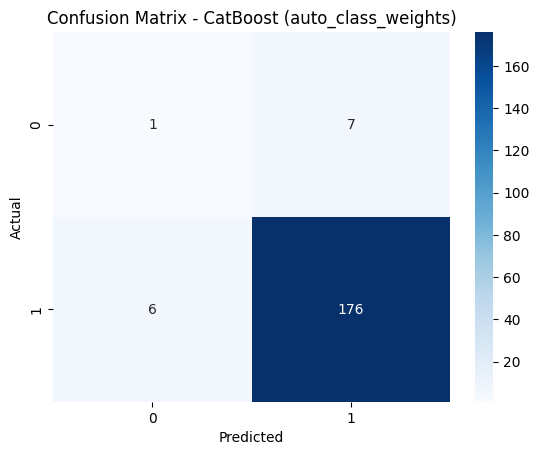


--- 3.13.2 CatBoost (SMOTE) ---
Tiempo de entrenamiento (SMOTE): 14.70 segundos

--- Evaluación: CatBoost (SMOTE) ---
Accuracy: 0.9474 (Objetivo > 0.80)
Precision: 0.9574
Recall: 0.9890
F1-score: 0.9730
ROC AUC: 0.9533

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.96      0.99      0.97       182

    accuracy                           0.95       190
   macro avg       0.48      0.49      0.49       190
weighted avg       0.92      0.95      0.93       190


Confusion Matrix:


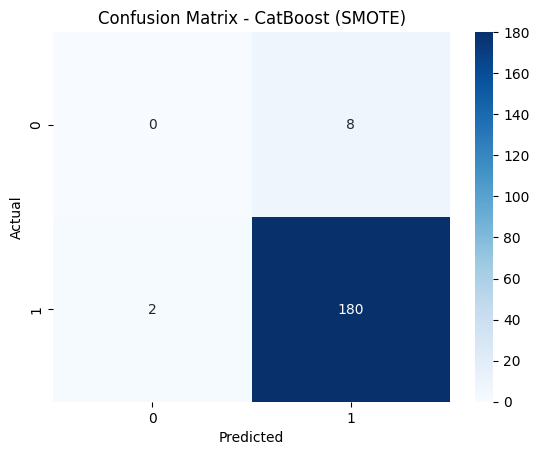

In [ ]:
# --- 3.13 Modelo: CatBoost Classifier ---
if cb:
    print("\n\n==============================================================================")
    print("=== Modelo 3.13: CatBoost Classifier ===")
    print("==============================================================================")
    
    # Preparar datos para CatBoost (si son DataFrames de Pandas, es mejor)
    X_train_cb_df = X_train if isinstance(X_train, pd.DataFrame) else pd.DataFrame(X_train)
    X_val_cb_df = X_val if isinstance(X_val, pd.DataFrame) else pd.DataFrame(X_val)
    X_train_resampled_cb_df = X_train_resampled if isinstance(X_train_resampled, pd.DataFrame) else pd.DataFrame(X_train_resampled)


    # --- 3.13.1 CatBoost con auto_class_weights (Datos Originales) ---
    print("\n--- 3.13.1 CatBoost (auto_class_weights, Datos Originales) ---")
    try:
        start_time = time()
        cb_clf_balanced = cb.CatBoostClassifier(
            random_state=RANDOM_STATE, 
            verbose=0, # Suprime output de entrenamiento
            auto_class_weights='Balanced' # O 'SqrtBalanced'
        )
        cb_clf_balanced.fit(X_train_cb_df, y_train)
        end_time = time()
        print(f"Tiempo de entrenamiento (auto_class_weights): {end_time - start_time:.2f} segundos")

        y_pred_val_cb_b = cb_clf_balanced.predict(X_val_cb_df)
        y_pred_proba_val_cb_b = cb_clf_balanced.predict_proba(X_val_cb_df)[:, 1]

        res_cb_b = evaluar_modelo(
            "CatBoost (auto_class_weights)", 
            y_val, 
            y_pred_val_cb_b, 
            y_pred_proba_val_cb_b
        )
        resultados_modelos.append(res_cb_b)
    except Exception as e:
        print(f"Error con CatBoost (auto_class_weights): {e}")

    # --- 3.13.2 CatBoost con Datos Remuestreados (SMOTE) ---
    print("\n--- 3.13.2 CatBoost (SMOTE) ---")
    try:
        start_time = time()
        cb_clf_smote = cb.CatBoostClassifier(random_state=RANDOM_STATE, verbose=0)
        cb_clf_smote.fit(X_train_resampled_cb_df, y_train_resampled)
        end_time = time()
        print(f"Tiempo de entrenamiento (SMOTE): {end_time - start_time:.2f} segundos")

        y_pred_val_cb_smote = cb_clf_smote.predict(X_val_cb_df)
        y_pred_proba_val_cb_smote = cb_clf_smote.predict_proba(X_val_cb_df)[:, 1]

        res_cb_smote = evaluar_modelo(
            "CatBoost (SMOTE)", 
            y_val, 
            y_pred_val_cb_smote, 
            y_pred_proba_val_cb_smote
        )
        resultados_modelos.append(res_cb_smote)
    except Exception as e:
        print(f"Error con CatBoost (SMOTE): {e}")
else:
    print("\n\nCatBoost no está instalado, se omite esta sección.")



=== Resumen Comparativo de Modelos (en Conjunto de Validación) ===
                                           modelo  accuracy  precision    recall        f1   roc_auc
21                     XGBoost (scale_pos_weight)  0.931579   0.977401  0.950549  0.963788  0.955701
26                               CatBoost (SMOTE)  0.947368   0.957447  0.989011  0.972973  0.953297
16             Gradient Boosting (sklearn, SMOTE)  0.947368   0.962366  0.983516  0.972826  0.938187
22                                XGBoost (SMOTE)  0.957895   0.962766  0.994505  0.978378  0.936813
25                  CatBoost (auto_class_weights)  0.931579   0.961749  0.967033  0.964384  0.926511
24                               LightGBM (SMOTE)  0.947368   0.957447  0.989011  0.972973  0.920330
14                        AdaBoost (SMOTE, SAMME)  0.936842   0.972222  0.961538  0.966851  0.911745
23             LightGBM (class_weight='balanced')  0.931579   0.956757  0.972527  0.964578  0.907280
13                 Ada

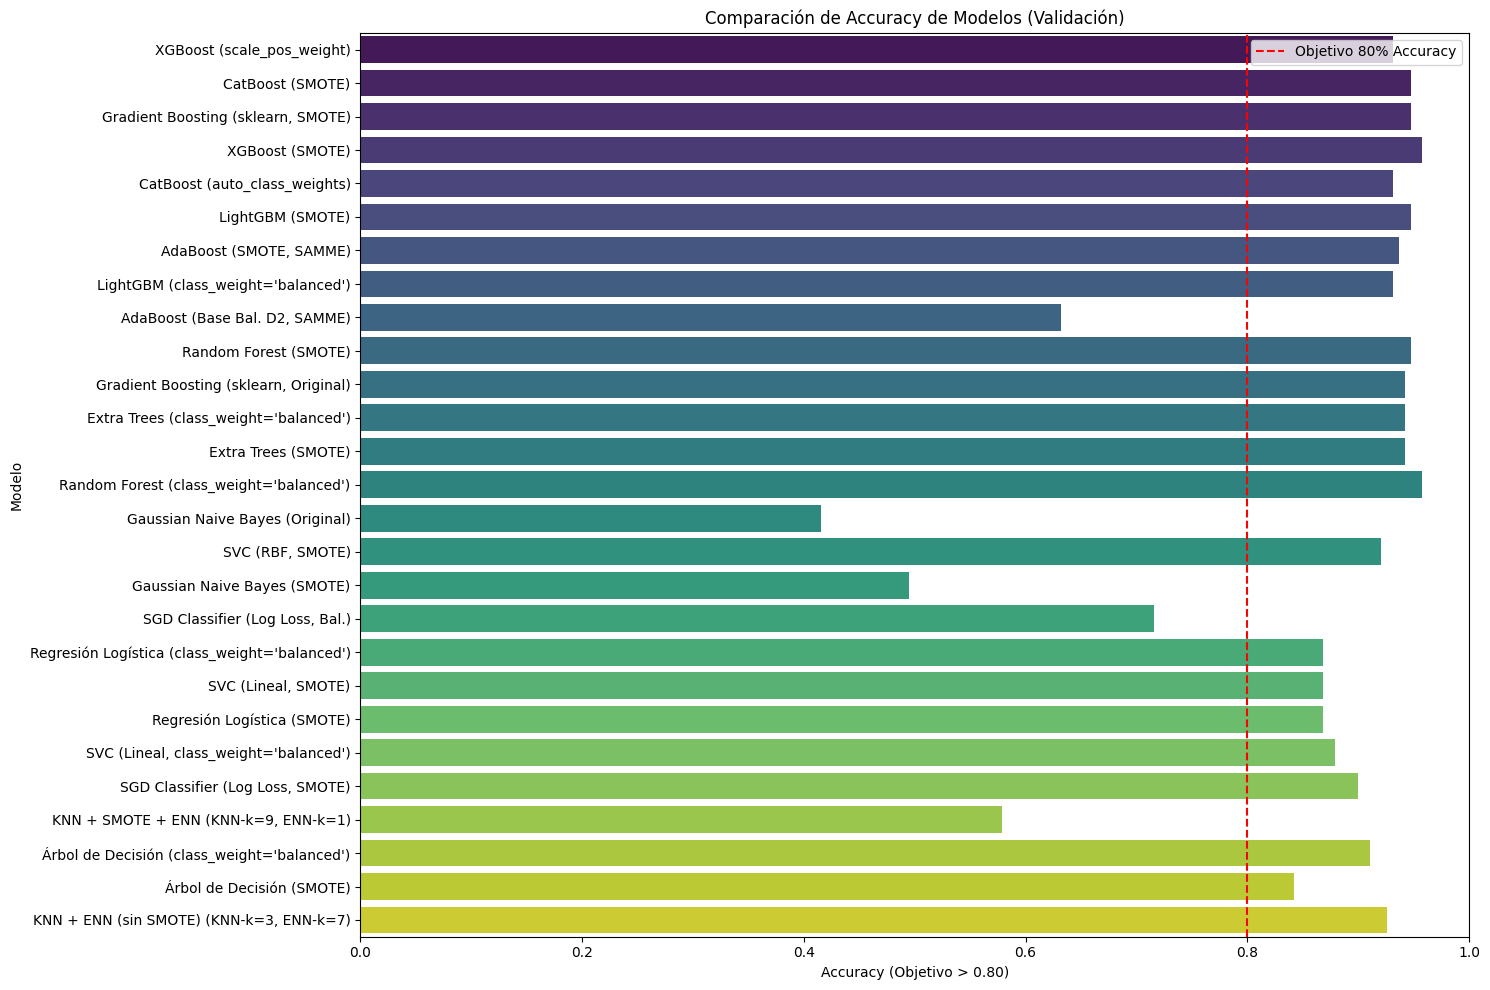

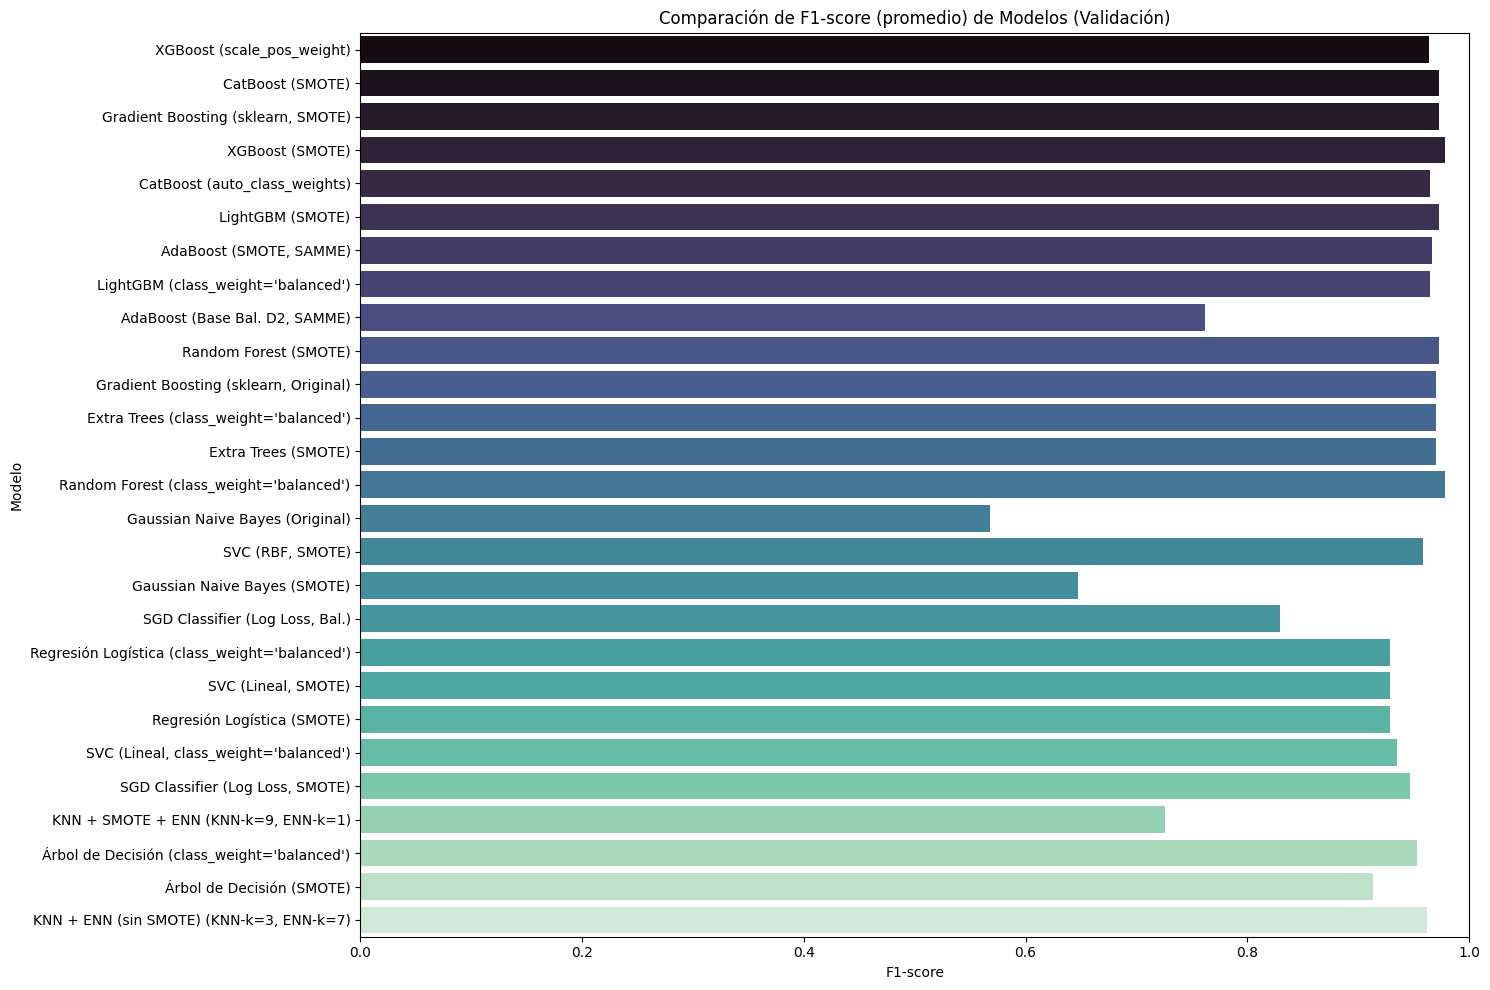


--- Modelado y Evaluación Inicial Completados ---


In [ ]:
# --- 4. Resumen Comparativo de Modelos (al final de todos los modelos) ---
print("\n\n==============================================================================")
print("=== Resumen Comparativo de Modelos (en Conjunto de Validación) ===")
print("==============================================================================")
if resultados_modelos:
    df_resultados = pd.DataFrame(resultados_modelos)
    # Ordenar por F1-score de la clase minoritaria (asumiendo que es clase 0) o ROC AUC
    # Para F1 de clase 0, necesitarías extraerlo del classification_report o calcularlo manualmente
    # Por ahora, ordenamos por ROC AUC o F1 general.
    df_resultados = df_resultados.sort_values(by='roc_auc', ascending=False) 
    print(df_resultados.to_string())
    
    df_resultados.to_csv(RUTA_DATOS_PROCESADOS + 'comparacion_modelos_validacion.csv', index=False)
    print(f"\nTabla de comparación guardada en '{RUTA_DATOS_PROCESADOS}comparacion_modelos_validacion.csv'")
    
    plt.figure(figsize=(15, 10)) # Ajustar tamaño para más modelos
    sns.barplot(x='accuracy', y='modelo', data=df_resultados, palette='viridis', hue='modelo', dodge=False, legend=False) # Usar hue para colores distintos si es necesario, legend=False para evitar leyenda duplicada
    plt.title('Comparación de Accuracy de Modelos (Validación)')
    plt.xlabel('Accuracy (Objetivo > 0.80)')
    plt.ylabel('Modelo')
    plt.xlim(0.0, 1.0) # Accuracy va de 0 a 1
    plt.axvline(x=0.80, color='r', linestyle='--', label='Objetivo 80% Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(15, 10))
    sns.barplot(x='f1', y='modelo', data=df_resultados, palette='mako', hue='modelo', dodge=False, legend=False)
    plt.title('Comparación de F1-score (promedio) de Modelos (Validación)')
    plt.xlabel('F1-score')
    plt.ylabel('Modelo')
    plt.xlim(0.0, 1.0)
    plt.tight_layout()
    plt.show()

else:
    print("No se generaron resultados de modelos para comparar.")

print("\n--- Modelado y Evaluación Inicial Completados ---")

In [31]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, recall_score, f1_score # Para scorers personalizados

# Definir un scorer común para optimización, priorizando el balance o la clase minoritaria
# Por ejemplo, F1-score macro (promedio de F1 para ambas clases) o ROC AUC
# O F1 para la clase 0 (asumiendo 0 es la minoritaria "No Exitoso")
f1_clase_0_scorer = make_scorer(f1_score, pos_label=0, average='binary', zero_division=0)
SCORING_METRIC_OPTIMIZATION = 'roc_auc' # O f1_clase_0_scorer, 'f1_macro', 'recall_weighted', etc.

N_ITER_RANDOM_SEARCH = 50 # Número de iteraciones para RandomizedSearchCV (ajustar según tiempo)
CV_FOLDS = 5              # Número de folds para validación cruzada (ajustar según tiempo)


# INICIO DE AJUSTE DE HIPERPARÁMETROS PARA CADA MODELO




=== AJUSTE HIPERPARÁMETROS 3.1: Regresión Logística ===

--- Buscando para RegLog (Original + class_weight), optimizando para 'roc_auc' ---
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Búsqueda completada en 0.96s. Mejores params: {'solver': 'liblinear', 'penalty': 'l1', 'C': 0.01}

--- Evaluación: RegLog Opt (Orig+CW, Scored by roc_auc) ---
Accuracy: 0.4474 (Objetivo > 0.80)
Precision: 1.0000
Recall: 0.4231
F1-score: 0.5946
ROC AUC: 0.9334

Classification Report:
              precision    recall  f1-score   support

           0       0.07      1.00      0.13         8
           1       1.00      0.42      0.59       182

    accuracy                           0.45       190
   macro avg       0.54      0.71      0.36       190
weighted avg       0.96      0.45      0.58       190


Confusion Matrix:


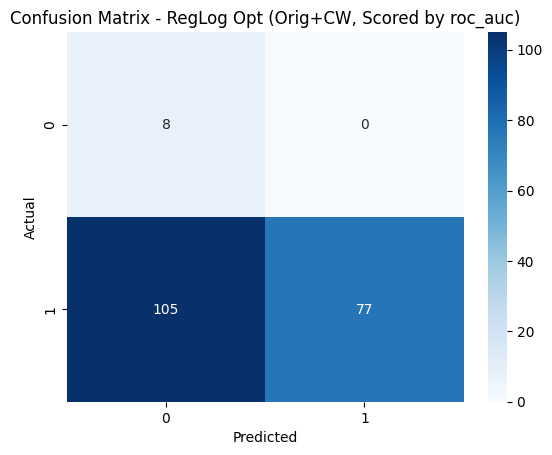


--- Buscando para RegLog (SMOTE), optimizando para 'roc_auc' ---
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Búsqueda completada en 2.73s. Mejores params: {'solver': 'liblinear', 'penalty': 'l2', 'C': 1}

--- Evaluación: RegLog Opt (SMOTE, Scored by roc_auc) ---
Accuracy: 0.8684 (Objetivo > 0.80)
Precision: 0.9645
Recall: 0.8956
F1-score: 0.9288
ROC AUC: 0.6312

Classification Report:
              precision    recall  f1-score   support

           0       0.10      0.25      0.14         8
           1       0.96      0.90      0.93       182

    accuracy                           0.87       190
   macro avg       0.53      0.57      0.53       190
weighted avg       0.93      0.87      0.90       190


Confusion Matrix:


In [ ]:
# --- 3.1 AJUSTE: Regresión Logística ---
print("\n\n==============================================================================")
print("=== AJUSTE HIPERPARÁMETROS 3.1: Regresión Logística ===")
print("==============================================================================")

log_reg_param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear'] # liblinear soporta l1 y l2
}

# --- 3.1.1 Ajuste RegLog con Datos Originales + class_weight ---
print(f"\n--- Buscando para RegLog (Original + class_weight), optimizando para '{SCORING_METRIC_OPTIMIZATION}' ---")
log_reg_orig_search = RandomizedSearchCV(
    estimator=LogisticRegression(random_state=RANDOM_STATE, max_iter=2000, class_weight='balanced', solver='liblinear'),
    param_distributions=log_reg_param_grid,
    n_iter=min(N_ITER_RANDOM_SEARCH, 6*2), # Max iteraciones posibles si C y penalty son los únicos que varían
    cv=StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE),
    scoring=SCORING_METRIC_OPTIMIZATION, verbose=1, random_state=RANDOM_STATE, n_jobs=-1
)
try:
    start_time = time()
    log_reg_orig_search.fit(X_train, y_train)
    end_time = time()
    print(f"Búsqueda completada en {end_time - start_time:.2f}s. Mejores params: {log_reg_orig_search.best_params_}")
    best_log_reg_orig = log_reg_orig_search.best_estimator_
    y_pred_val_lr_b_opt = best_log_reg_orig.predict(X_val)
    y_pred_proba_val_lr_b_opt = best_log_reg_orig.predict_proba(X_val)[:, 1]
    res_lr_b_opt = evaluar_modelo(f"RegLog Opt (Orig+CW, Scored by {SCORING_METRIC_OPTIMIZATION})", y_val, y_pred_val_lr_b_opt, y_pred_proba_val_lr_b_opt)
    resultados_modelos.append(res_lr_b_opt)
except Exception as e: print(f"Error en ajuste RegLog (Orig+CW): {e}")

# --- 3.1.2 Ajuste RegLog con Datos SMOTE ---
print(f"\n--- Buscando para RegLog (SMOTE), optimizando para '{SCORING_METRIC_OPTIMIZATION}' ---")
# Para SMOTE, class_weight no se incluye en el grid ya que los datos están balanceados
log_reg_smote_search = RandomizedSearchCV(
    estimator=LogisticRegression(random_state=RANDOM_STATE, max_iter=2000, solver='liblinear'), # Sin class_weight
    param_distributions=log_reg_param_grid,
    n_iter=min(N_ITER_RANDOM_SEARCH, 6*2),
    cv=StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE),
    scoring=SCORING_METRIC_OPTIMIZATION, verbose=1, random_state=RANDOM_STATE, n_jobs=-1
)
try:
    start_time = time()
    log_reg_smote_search.fit(X_train_resampled, y_train_resampled)
    end_time = time()
    print(f"Búsqueda completada en {end_time - start_time:.2f}s. Mejores params: {log_reg_smote_search.best_params_}")
    best_log_reg_smote = log_reg_smote_search.best_estimator_
    y_pred_val_lr_smote_opt = best_log_reg_smote.predict(X_val)
    y_pred_proba_val_lr_smote_opt = best_log_reg_smote.predict_proba(X_val)[:, 1]
    res_lr_smote_opt = evaluar_modelo(f"RegLog Opt (SMOTE, Scored by {SCORING_METRIC_OPTIMIZATION})", y_val, y_pred_val_lr_smote_opt, y_pred_proba_val_lr_smote_opt)
    resultados_modelos.append(res_lr_smote_opt)
except Exception as e: print(f"Error en ajuste RegLog (SMOTE): {e}")

In [ ]:
# --- 3.2 AJUSTE: K-Nearest Neighbors (KNN) ---
# KNN no tiene class_weight. El ajuste se hará sobre datos originales y SMOTE.
print("\n\n==============================================================================")
print("=== AJUSTE HIPERPARÁMETROS 3.2: K-Nearest Neighbors (KNN) ===")
print("==============================================================================")

knn_param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 15, 21],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

# --- 3.2.1 Ajuste KNN con Datos Originales ---
print(f"\n--- Buscando para KNN (Original), optimizando para '{SCORING_METRIC_OPTIMIZATION}' ---")
knn_orig_search = RandomizedSearchCV(
    estimator=KNeighborsClassifier(n_jobs=-1),
    param_distributions=knn_param_grid,
    n_iter=N_ITER_RANDOM_SEARCH,
    cv=StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE),
    scoring=SCORING_METRIC_OPTIMIZATION, verbose=1, random_state=RANDOM_STATE, n_jobs=-1
)
try:
    start_time = time()
    knn_orig_search.fit(X_train, y_train)
    end_time = time()
    print(f"Búsqueda completada en {end_time - start_time:.2f}s. Mejores params: {knn_orig_search.best_params_}")
    best_knn_orig = knn_orig_search.best_estimator_
    y_pred_val_knn_orig_opt = best_knn_orig.predict(X_val)
    y_pred_proba_val_knn_orig_opt = best_knn_orig.predict_proba(X_val)[:, 1]
    res_knn_orig_opt = evaluar_modelo(f"KNN Opt (Original, Scored by {SCORING_METRIC_OPTIMIZATION})", y_val, y_pred_val_knn_orig_opt, y_pred_proba_val_knn_orig_opt)
    resultados_modelos.append(res_knn_orig_opt)
except Exception as e: print(f"Error en ajuste KNN (Original): {e}")

# --- 3.2.2 Ajuste KNN con Datos SMOTE ---
print(f"\n--- Buscando para KNN (SMOTE), optimizando para '{SCORING_METRIC_OPTIMIZATION}' ---")
knn_smote_search = RandomizedSearchCV(
    estimator=KNeighborsClassifier(n_jobs=-1),
    param_distributions=knn_param_grid,
    n_iter=N_ITER_RANDOM_SEARCH,
    cv=StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE), # CV sobre datos SMOTE
    scoring=SCORING_METRIC_OPTIMIZATION, verbose=1, random_state=RANDOM_STATE, n_jobs=-1
)
try:
    start_time = time()
    knn_smote_search.fit(X_train_resampled, y_train_resampled)
    end_time = time()
    print(f"Búsqueda completada en {end_time - start_time:.2f}s. Mejores params: {knn_smote_search.best_params_}")
    best_knn_smote = knn_smote_search.best_estimator_
    y_pred_val_knn_smote_opt = best_knn_smote.predict(X_val)
    y_pred_proba_val_knn_smote_opt = best_knn_smote.predict_proba(X_val)[:, 1]
    res_knn_smote_opt = evaluar_modelo(f"KNN Opt (SMOTE, Scored by {SCORING_METRIC_OPTIMIZATION})", y_val, y_pred_val_knn_smote_opt, y_pred_proba_val_knn_smote_opt)
    resultados_modelos.append(res_knn_smote_opt)
except Exception as e: print(f"Error en ajuste KNN (SMOTE): {e}")



=== AJUSTE HIPERPARÁMETROS 3.2: K-Nearest Neighbors (KNN) ===

--- Buscando para KNN (Original), optimizando para 'roc_auc' ---
Fitting 5 folds for each of 42 candidates, totalling 210 fits


c:\Users\alexg\Documents\code\datathon2025\NaN-Crew-Datathon-2025-OXXO\.venv\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 42 is smaller than n_iter=50. Running 42 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Búsqueda completada en 0.60s. Mejores params: {'weights': 'uniform', 'n_neighbors': 21, 'metric': 'manhattan'}

--- Evaluación: KNN Opt (Original, Scored by roc_auc) ---
Accuracy: 0.9579 (Objetivo > 0.80)
Precision: 0.9579
Recall: 1.0000
F1-score: 0.9785
ROC AUC: 0.5350

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.96      1.00      0.98       182

    accuracy                           0.96       190
   macro avg       0.48      0.50      0.49       190
weighted avg       0.92      0.96      0.94       190


Confusion Matrix:



--- Buscando para KNN (SMOTE), optimizando para 'roc_auc' ---
Fitting 5 folds for each of 42 candidates, totalling 210 fits


c:\Users\alexg\Documents\code\datathon2025\NaN-Crew-Datathon-2025-OXXO\.venv\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 42 is smaller than n_iter=50. Running 42 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Búsqueda completada en 2.58s. Mejores params: {'weights': 'distance', 'n_neighbors': 21, 'metric': 'manhattan'}

--- Evaluación: KNN Opt (SMOTE, Scored by roc_auc) ---
Accuracy: 0.6526 (Objetivo > 0.80)
Precision: 0.9531
Recall: 0.6703
F1-score: 0.7871
ROC AUC: 0.5000

Classification Report:
              precision    recall  f1-score   support

           0       0.03      0.25      0.06         8
           1       0.95      0.67      0.79       182

    accuracy                           0.65       190
   macro avg       0.49      0.46      0.42       190
weighted avg       0.91      0.65      0.76       190


Confusion Matrix:




=== AJUSTE HIPERPARÁMETROS 3.3: Support Vector Machine (SVC) ===

--- Buscando para SVC (Lineal, Original + class_weight), optimizando para 'roc_auc' ---
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Búsqueda completada en 0.41s. Mejores params: {'kernel': 'linear', 'C': 0.1}

--- Evaluación: SVC Opt (Lin, Orig+CW, Scored by roc_auc) ---
Accuracy: 0.8789 (Objetivo > 0.80)
Precision: 0.9649
Recall: 0.9066
F1-score: 0.9348
ROC AUC: 0.6964

Classification Report:
              precision    recall  f1-score   support

           0       0.11      0.25      0.15         8
           1       0.96      0.91      0.93       182

    accuracy                           0.88       190
   macro avg       0.54      0.58      0.54       190
weighted avg       0.93      0.88      0.90       190


Confusion Matrix:


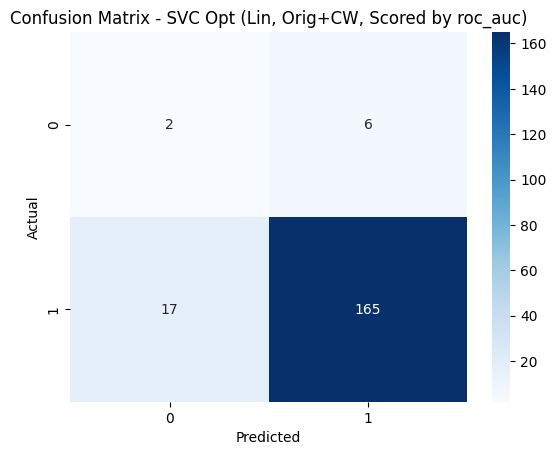


--- Buscando para SVC (Lineal, SMOTE), optimizando para 'roc_auc' ---
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Búsqueda completada en 2.59s. Mejores params: {'kernel': 'linear', 'C': 0.1}

--- Evaluación: SVC Opt (Lin, SMOTE, Scored by roc_auc) ---
Accuracy: 0.8789 (Objetivo > 0.80)
Precision: 0.9649
Recall: 0.9066
F1-score: 0.9348
ROC AUC: 0.6913

Classification Report:
              precision    recall  f1-score   support

           0       0.11      0.25      0.15         8
           1       0.96      0.91      0.93       182

    accuracy                           0.88       190
   macro avg       0.54      0.58      0.54       190
weighted avg       0.93      0.88      0.90       190


Confusion Matrix:


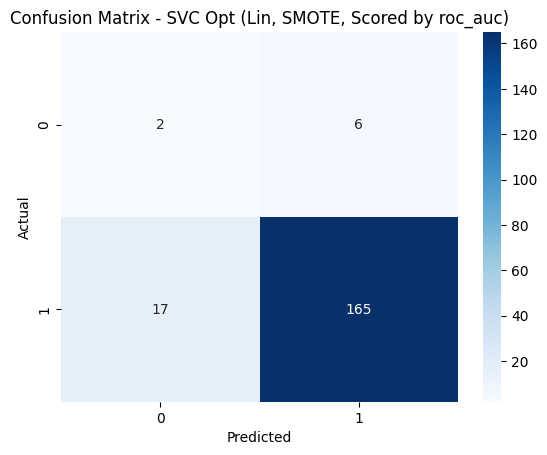


--- Buscando para SVC (RBF, SMOTE), optimizando para 'roc_auc' ---
ADVERTENCIA: El ajuste de SVC con kernel RBF puede tardar mucho tiempo.
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Búsqueda completada en 3.40s. Mejores params: {'kernel': 'rbf', 'gamma': 'scale', 'C': 10}

--- Evaluación: SVC Opt (RBF, SMOTE, Scored by roc_auc) ---
Accuracy: 0.9263 (Objetivo > 0.80)
Precision: 0.9565
Recall: 0.9670
F1-score: 0.9617
ROC AUC: 0.7198

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.96      0.97      0.96       182

    accuracy                           0.93       190
   macro avg       0.48      0.48      0.48       190
weighted avg       0.92      0.93      0.92       190


Confusion Matrix:


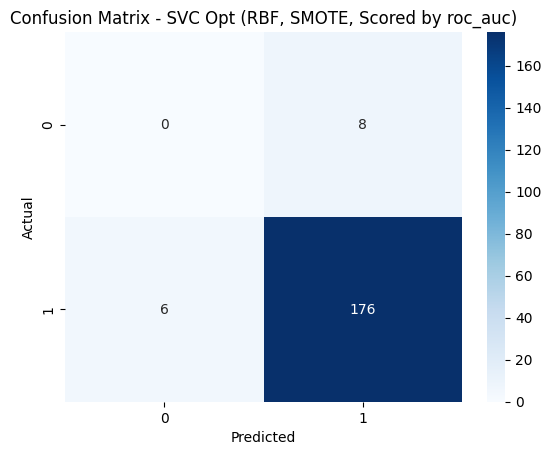

In [ ]:
# --- 3.3 AJUSTE: Support Vector Machine (SVC) ---
# NOTA: SVC, especialmente con kernel RBF, puede ser MUY lento con datasets que tengan
#       muchas features o muchas muestras. El kernel lineal es más rápido.
print("\n\n==============================================================================")
print("=== AJUSTE HIPERPARÁMETROS 3.3: Support Vector Machine (SVC) ===")
print("==============================================================================")

svc_param_grid = {
    'C': [0.1, 1, 10], # Parámetro de regularización
    'kernel': ['linear', 'rbf'], # Probar ambos kernels
    'gamma': ['scale', 'auto', 0.01, 0.1], # Parámetro del kernel (relevante para 'rbf')
    # class_weight se maneja en el estimador base para la versión con datos originales
}
# Para RBF, un grid más pequeño podría ser necesario si es muy lento
svc_param_grid_rbf_focused = {
    'C': [1, 10],
    'kernel': ['rbf'],
    'gamma': ['scale', 0.01],
}


# --- 3.3.1 Ajuste SVC (Lineal) con Datos Originales + class_weight ---
print(f"\n--- Buscando para SVC (Lineal, Original + class_weight), optimizando para '{SCORING_METRIC_OPTIMIZATION}' ---")
svc_linear_orig_param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear']}
svc_linear_orig_search = RandomizedSearchCV(
    estimator=SVC(random_state=RANDOM_STATE, probability=True, class_weight='balanced'),
    param_distributions=svc_linear_orig_param_grid,
    n_iter=min(N_ITER_RANDOM_SEARCH, 3*1), # C y kernel
    cv=StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE),
    scoring=SCORING_METRIC_OPTIMIZATION, verbose=1, random_state=RANDOM_STATE, n_jobs=-1
)
try:
    start_time = time()
    svc_linear_orig_search.fit(X_train, y_train)
    end_time = time()
    print(f"Búsqueda completada en {end_time - start_time:.2f}s. Mejores params: {svc_linear_orig_search.best_params_}")
    best_svc_linear_orig = svc_linear_orig_search.best_estimator_
    y_pred_val_svc_lb_opt = best_svc_linear_orig.predict(X_val)
    y_pred_proba_val_svc_lb_opt = best_svc_linear_orig.predict_proba(X_val)[:, 1]
    res_svc_lb_opt = evaluar_modelo(f"SVC Opt (Lin, Orig+CW, Scored by {SCORING_METRIC_OPTIMIZATION})", y_val, y_pred_val_svc_lb_opt, y_pred_proba_val_svc_lb_opt)
    resultados_modelos.append(res_svc_lb_opt)
except Exception as e: print(f"Error en ajuste SVC (Lin, Orig+CW): {e}")


# --- 3.3.2 Ajuste SVC (Lineal) con Datos SMOTE ---
print(f"\n--- Buscando para SVC (Lineal, SMOTE), optimizando para '{SCORING_METRIC_OPTIMIZATION}' ---")
svc_linear_smote_search = RandomizedSearchCV(
    estimator=SVC(random_state=RANDOM_STATE, probability=True), # Sin class_weight
    param_distributions=svc_linear_orig_param_grid, # Mismo grid para lineal
    n_iter=min(N_ITER_RANDOM_SEARCH, 3*1),
    cv=StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE),
    scoring=SCORING_METRIC_OPTIMIZATION, verbose=1, random_state=RANDOM_STATE, n_jobs=-1
)
try:
    start_time = time()
    svc_linear_smote_search.fit(X_train_resampled, y_train_resampled)
    end_time = time()
    print(f"Búsqueda completada en {end_time - start_time:.2f}s. Mejores params: {svc_linear_smote_search.best_params_}")
    best_svc_linear_smote = svc_linear_smote_search.best_estimator_
    y_pred_val_svc_ls_opt = best_svc_linear_smote.predict(X_val)
    y_pred_proba_val_svc_ls_opt = best_svc_linear_smote.predict_proba(X_val)[:, 1]
    res_svc_ls_opt = evaluar_modelo(f"SVC Opt (Lin, SMOTE, Scored by {SCORING_METRIC_OPTIMIZATION})", y_val, y_pred_val_svc_ls_opt, y_pred_proba_val_svc_ls_opt)
    resultados_modelos.append(res_svc_ls_opt)
except Exception as e: print(f"Error en ajuste SVC (Lin, SMOTE): {e}")


# --- 3.3.3 Ajuste SVC (RBF) con Datos SMOTE (puede ser lento) ---
# Con datos originales y RBF + class_weight podría ser aún más lento y menos efectivo que SMOTE
print(f"\n--- Buscando para SVC (RBF, SMOTE), optimizando para '{SCORING_METRIC_OPTIMIZATION}' ---")
svc_rbf_smote_search = RandomizedSearchCV(
    estimator=SVC(random_state=RANDOM_STATE, probability=True, kernel='rbf'),
    param_distributions=svc_param_grid_rbf_focused, # Grid más pequeño para RBF
    n_iter=min(N_ITER_RANDOM_SEARCH, 2*2), # C y gamma
    cv=StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE),
    scoring=SCORING_METRIC_OPTIMIZATION, verbose=1, random_state=RANDOM_STATE, n_jobs=-1
)
try:
    print("ADVERTENCIA: El ajuste de SVC con kernel RBF puede tardar mucho tiempo.")
    start_time = time()
    svc_rbf_smote_search.fit(X_train_resampled, y_train_resampled)
    end_time = time()
    print(f"Búsqueda completada en {end_time - start_time:.2f}s. Mejores params: {svc_rbf_smote_search.best_params_}")
    best_svc_rbf_smote = svc_rbf_smote_search.best_estimator_
    y_pred_val_svc_rs_opt = best_svc_rbf_smote.predict(X_val)
    y_pred_proba_val_svc_rs_opt = best_svc_rbf_smote.predict_proba(X_val)[:, 1]
    res_svc_rs_opt = evaluar_modelo(f"SVC Opt (RBF, SMOTE, Scored by {SCORING_METRIC_OPTIMIZATION})", y_val, y_pred_val_svc_rs_opt, y_pred_proba_val_svc_rs_opt)
    resultados_modelos.append(res_svc_rs_opt)
except Exception as e: print(f"Error en ajuste SVC (RBF, SMOTE): {e}")



=== AJUSTE HIPERPARÁMETROS 3.4: Árbol de Decisión ===

--- Buscando para Árbol Decisión (Original + class_weight), optimizando para 'roc_auc' ---
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Búsqueda completada en 1.83s. Mejores params: {'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 5, 'criterion': 'entropy', 'class_weight': None}

--- Evaluación: Árbol Dec. Opt (Orig+CW, Scored by roc_auc) ---
Accuracy: 0.9263 (Objetivo > 0.80)
Precision: 0.9565
Recall: 0.9670
F1-score: 0.9617
ROC AUC: 0.7792

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.96      0.97      0.96       182

    accuracy                           0.93       190
   macro avg       0.48      0.48      0.48       190
weighted avg       0.92      0.93      0.92       190


Confusion Matrix:


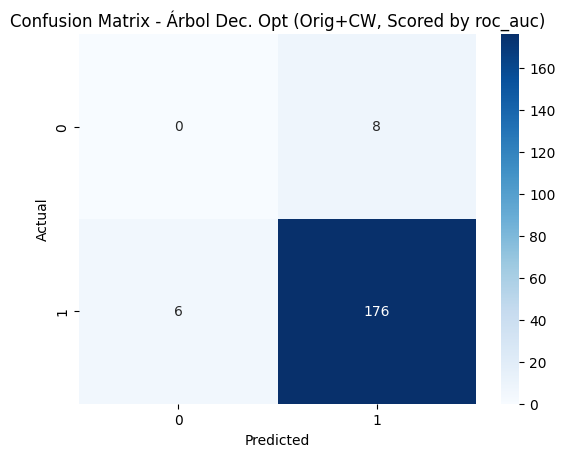


--- Buscando para Árbol Decisión (SMOTE), optimizando para 'roc_auc' ---
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Búsqueda completada en 6.64s. Mejores params: {'min_samples_split': 20, 'min_samples_leaf': 10, 'max_depth': None, 'criterion': 'gini'}

--- Evaluación: Árbol Dec. Opt (SMOTE, Scored by roc_auc) ---
Accuracy: 0.8947 (Objetivo > 0.80)
Precision: 0.9821
Recall: 0.9066
F1-score: 0.9429
ROC AUC: 0.7799

Classification Report:
              precision    recall  f1-score   support

           0       0.23      0.62      0.33         8
           1       0.98      0.91      0.94       182

    accuracy                           0.89       190
   macro avg       0.60      0.77      0.64       190
weighted avg       0.95      0.89      0.92       190


Confusion Matrix:


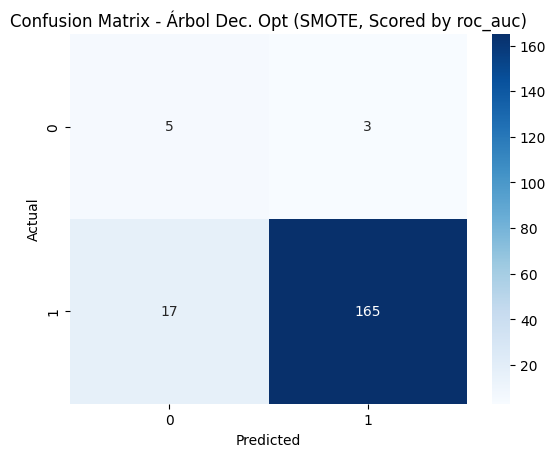

In [ ]:
# --- 3.4 AJUSTE: Árbol de Decisión ---
print("\n\n==============================================================================")
print("=== AJUSTE HIPERPARÁMETROS 3.4: Árbol de Decisión ===")
print("==============================================================================")

dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10],
    'class_weight': ['balanced', None] # Para la versión con datos originales
}
dt_param_grid_smote = dt_param_grid.copy()
del dt_param_grid_smote['class_weight']

# --- 3.4.1 Ajuste Árbol de Decisión con Datos Originales + class_weight ---
print(f"\n--- Buscando para Árbol Decisión (Original + class_weight), optimizando para '{SCORING_METRIC_OPTIMIZATION}' ---")
dt_orig_search = RandomizedSearchCV(
    estimator=DecisionTreeClassifier(random_state=RANDOM_STATE),
    param_distributions=dt_param_grid,
    n_iter=N_ITER_RANDOM_SEARCH,
    cv=StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE),
    scoring=SCORING_METRIC_OPTIMIZATION, verbose=1, random_state=RANDOM_STATE, n_jobs=-1
)
try:
    start_time = time()
    dt_orig_search.fit(X_train, y_train)
    end_time = time()
    print(f"Búsqueda completada en {end_time - start_time:.2f}s. Mejores params: {dt_orig_search.best_params_}")
    best_dt_orig = dt_orig_search.best_estimator_
    y_pred_val_dt_b_opt = best_dt_orig.predict(X_val)
    y_pred_proba_val_dt_b_opt = best_dt_orig.predict_proba(X_val)[:, 1]
    res_dt_b_opt = evaluar_modelo(f"Árbol Dec. Opt (Orig+CW, Scored by {SCORING_METRIC_OPTIMIZATION})", y_val, y_pred_val_dt_b_opt, y_pred_proba_val_dt_b_opt)
    resultados_modelos.append(res_dt_b_opt)
except Exception as e: print(f"Error en ajuste Árbol Decisión (Orig+CW): {e}")

# --- 3.4.2 Ajuste Árbol de Decisión con Datos SMOTE ---
print(f"\n--- Buscando para Árbol Decisión (SMOTE), optimizando para '{SCORING_METRIC_OPTIMIZATION}' ---")
dt_smote_search = RandomizedSearchCV(
    estimator=DecisionTreeClassifier(random_state=RANDOM_STATE),
    param_distributions=dt_param_grid_smote, # Sin class_weight
    n_iter=N_ITER_RANDOM_SEARCH,
    cv=StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE),
    scoring=SCORING_METRIC_OPTIMIZATION, verbose=1, random_state=RANDOM_STATE, n_jobs=-1
)
try:
    start_time = time()
    dt_smote_search.fit(X_train_resampled, y_train_resampled)
    end_time = time()
    print(f"Búsqueda completada en {end_time - start_time:.2f}s. Mejores params: {dt_smote_search.best_params_}")
    best_dt_smote = dt_smote_search.best_estimator_
    y_pred_val_dt_smote_opt = best_dt_smote.predict(X_val)
    y_pred_proba_val_dt_smote_opt = best_dt_smote.predict_proba(X_val)[:, 1]
    res_dt_smote_opt = evaluar_modelo(f"Árbol Dec. Opt (SMOTE, Scored by {SCORING_METRIC_OPTIMIZATION})", y_val, y_pred_val_dt_smote_opt, y_pred_proba_val_dt_smote_opt)
    resultados_modelos.append(res_dt_smote_opt)
except Exception as e: print(f"Error en ajuste Árbol Decisión (SMOTE): {e}")

In [ ]:
# --- 3.5 AJUSTE: Random Forest ---
print("\n\n==============================================================================")
print("=== AJUSTE HIPERPARÁMETROS 3.5: Random Forest ===") # La numeración seguiría la del script original
print("==============================================================================")

rf_param_grid_full = {
    'n_estimators': [50, 100, 200, 300],
    'max_features': ['sqrt', 'log2', None], # None es igual a todas las features (antiguo 'auto')
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6],
    'bootstrap': [True, False],
    'class_weight': ['balanced', 'balanced_subsample', None] # Para la versión con datos originales
}
rf_param_grid_smote_full = rf_param_grid_full.copy()
del rf_param_grid_smote_full['class_weight'] # No optimizar class_weight con SMOTE

# --- 3.5.1 Ajuste RF con Datos Originales + class_weight ---
print(f"\n--- Buscando para RF (Original + class_weight), optimizando para '{SCORING_METRIC_OPTIMIZATION}' ---")
rf_orig_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1),
    param_distributions=rf_param_grid_full,
    n_iter=N_ITER_RANDOM_SEARCH, # Aumentar si es posible
    cv=StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE),
    scoring=SCORING_METRIC_OPTIMIZATION, verbose=1, random_state=RANDOM_STATE, n_jobs=-1
)
try:
    start_time = time()
    rf_orig_search.fit(X_train, y_train)
    end_time = time()
    print(f"Búsqueda completada en {end_time - start_time:.2f}s. Mejores params: {rf_orig_search.best_params_}")
    best_rf_orig_opt = rf_orig_search.best_estimator_
    y_pred_val_rf_b_opt = best_rf_orig_opt.predict(X_val)
    y_pred_proba_val_rf_b_opt = best_rf_orig_opt.predict_proba(X_val)[:, 1]
    res_rf_b_opt = evaluar_modelo(f"RF Opt (Orig+CW, Scored by {SCORING_METRIC_OPTIMIZATION})", y_val, y_pred_val_rf_b_opt, y_pred_proba_val_rf_b_opt)
    resultados_modelos.append(res_rf_b_opt)
except Exception as e: print(f"Error en ajuste RF (Orig+CW): {e}")


# --- 3.5.2 Ajuste RF con Datos SMOTE ---
print(f"\n--- Buscando para RF (SMOTE), optimizando para '{SCORING_METRIC_OPTIMIZATION}' ---")
rf_smote_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1),
    param_distributions=rf_param_grid_smote_full, # Sin class_weight
    n_iter=N_ITER_RANDOM_SEARCH, # Aumentar si es posible
    cv=StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE),
    scoring=SCORING_METRIC_OPTIMIZATION, verbose=1, random_state=RANDOM_STATE, n_jobs=-1
)
try:
    start_time = time()
    rf_smote_search.fit(X_train_resampled, y_train_resampled)
    end_time = time()
    print(f"Búsqueda completada en {end_time - start_time:.2f}s. Mejores params: {rf_smote_search.best_params_}")
    best_rf_smote_opt = rf_smote_search.best_estimator_
    y_pred_val_rf_smote_opt = best_rf_smote_opt.predict(X_val)
    y_pred_proba_val_rf_smote_opt = best_rf_smote_opt.predict_proba(X_val)[:, 1]
    res_rf_smote_opt = evaluar_modelo(f"RF Opt (SMOTE, Scored by {SCORING_METRIC_OPTIMIZATION})", y_val, y_pred_val_rf_smote_opt, y_pred_proba_val_rf_smote_opt)
    resultados_modelos.append(res_rf_smote_opt)
except Exception as e: print(f"Error en ajuste RF (SMOTE): {e}")



=== AJUSTE HIPERPARÁMETROS 3.5: Random Forest ===

--- Buscando para RF (Original + class_weight), optimizando para 'roc_auc' ---
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Búsqueda completada en 57.28s. Mejores params: {'n_estimators': 100, 'min_samples_split': 15, 'min_samples_leaf': 6, 'max_features': None, 'max_depth': None, 'class_weight': 'balanced', 'bootstrap': True}

--- Evaluación: RF Opt (Orig+CW, Scored by roc_auc) ---
Accuracy: 0.9526 (Objetivo > 0.80)
Precision: 0.9577
Recall: 0.9945
F1-score: 0.9757
ROC AUC: 0.9310

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.96      0.99      0.98       182

    accuracy                           0.95       190
   macro avg       0.48      0.50      0.49       190
weighted avg       0.92      0.95      0.93       190


Confusion Matrix:



--- Buscando para RF (SMOTE), optimizando para 'roc_auc' ---
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Búsqueda completada en 220.79s. Mejores params: {'n_estimators': 300, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': False}

--- Evaluación: RF Opt (SMOTE, Scored by roc_auc) ---
Accuracy: 0.9526 (Objetivo > 0.80)
Precision: 0.9577
Recall: 0.9945
F1-score: 0.9757
ROC AUC: 0.9114

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.96      0.99      0.98       182

    accuracy                           0.95       190
   macro avg       0.48      0.50      0.49       190
weighted avg       0.92      0.95      0.93       190


Confusion Matrix:




=== AJUSTE HIPERPARÁMETROS 3.6: Extra Trees Classifier ===

--- Buscando para Extra Trees (Original + class_weight), optimizando para 'roc_auc' ---
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Búsqueda completada en 14.97s. Mejores params: {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': None, 'max_depth': 40, 'class_weight': 'balanced_subsample', 'bootstrap': True}

--- Evaluación: ExtraTrees Opt (Orig+CW, Scored by roc_auc) ---
Accuracy: 0.9579 (Objetivo > 0.80)
Precision: 0.9579
Recall: 1.0000
F1-score: 0.9785
ROC AUC: 0.9224

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.96      1.00      0.98       182

    accuracy                           0.96       190
   macro avg       0.48      0.50      0.49       190
weighted avg       0.92      0.96      0.94       190


Confusion Matrix:


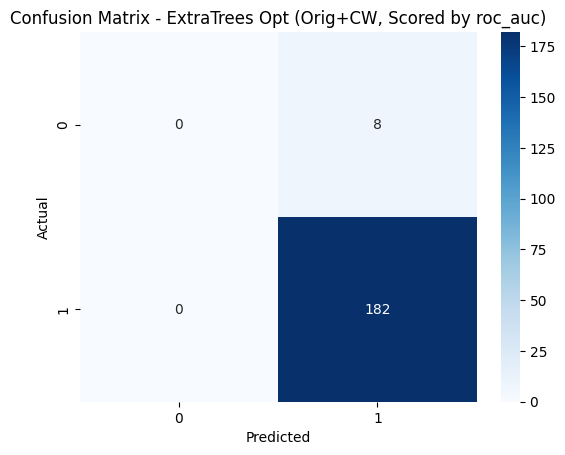


--- Buscando para Extra Trees (SMOTE), optimizando para 'roc_auc' ---
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Búsqueda completada en 28.91s. Mejores params: {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 40, 'bootstrap': False}

--- Evaluación: ExtraTrees Opt (SMOTE, Scored by roc_auc) ---
Accuracy: 0.9474 (Objetivo > 0.80)
Precision: 0.9574
Recall: 0.9890
F1-score: 0.9730
ROC AUC: 0.9148

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.96      0.99      0.97       182

    accuracy                           0.95       190
   macro avg       0.48      0.49      0.49       190
weighted avg       0.92      0.95      0.93       190


Confusion Matrix:


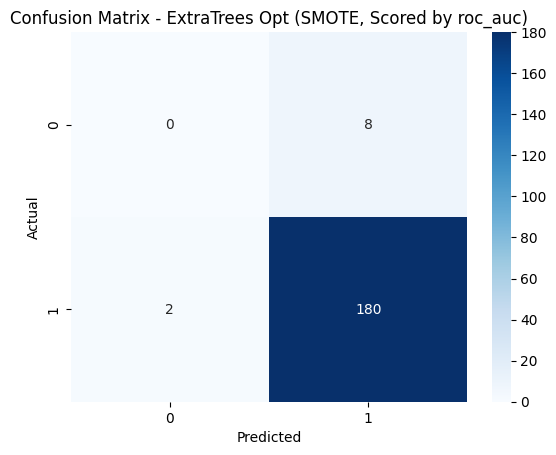

In [ ]:
# --- 3.6 AJUSTE: Extra Trees Classifier ---
print("\n\n==============================================================================")
print("=== AJUSTE HIPERPARÁMETROS 3.6: Extra Trees Classifier ===")
print("==============================================================================")

et_param_grid_full = { # Similar a Random Forest
    'n_estimators': [50, 100, 200, 300],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6],
    'bootstrap': [True, False], # ExtraTrees a menudo se usa con bootstrap=False por defecto
    'class_weight': ['balanced', 'balanced_subsample', None]
}
et_param_grid_smote_full = {k:v for k,v in et_param_grid_full.items() if k != 'class_weight'}
if 'bootstrap' in et_param_grid_smote_full : et_param_grid_smote_full['bootstrap'] = [False] # Default de ET

# --- 3.6.1 Ajuste Extra Trees con Datos Originales + class_weight ---
print(f"\n--- Buscando para Extra Trees (Original + class_weight), optimizando para '{SCORING_METRIC_OPTIMIZATION}' ---")
et_orig_search = RandomizedSearchCV(
    estimator=ExtraTreesClassifier(random_state=RANDOM_STATE, n_jobs=-1),
    param_distributions=et_param_grid_full,
    n_iter=N_ITER_RANDOM_SEARCH,
    cv=StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE),
    scoring=SCORING_METRIC_OPTIMIZATION, verbose=1, random_state=RANDOM_STATE, n_jobs=-1
)
try:
    start_time = time(); et_orig_search.fit(X_train, y_train); end_time = time()
    print(f"Búsqueda completada en {end_time - start_time:.2f}s. Mejores params: {et_orig_search.best_params_}")
    best_et_orig_opt = et_orig_search.best_estimator_
    y_pred_val_et_b_opt = best_et_orig_opt.predict(X_val)
    y_pred_proba_val_et_b_opt = best_et_orig_opt.predict_proba(X_val)[:, 1]
    res_et_b_opt = evaluar_modelo(f"ExtraTrees Opt (Orig+CW, Scored by {SCORING_METRIC_OPTIMIZATION})", y_val, y_pred_val_et_b_opt, y_pred_proba_val_et_b_opt)
    resultados_modelos.append(res_et_b_opt)
except Exception as e: print(f"Error en ajuste Extra Trees (Orig+CW): {e}")

# --- 3.6.2 Ajuste Extra Trees con Datos SMOTE ---
print(f"\n--- Buscando para Extra Trees (SMOTE), optimizando para '{SCORING_METRIC_OPTIMIZATION}' ---")
et_smote_search = RandomizedSearchCV(
    estimator=ExtraTreesClassifier(random_state=RANDOM_STATE, n_jobs=-1, bootstrap=False), # bootstrap=False es default
    param_distributions=et_param_grid_smote_full,
    n_iter=N_ITER_RANDOM_SEARCH,
    cv=StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE),
    scoring=SCORING_METRIC_OPTIMIZATION, verbose=1, random_state=RANDOM_STATE, n_jobs=-1
)
try:
    start_time = time(); et_smote_search.fit(X_train_resampled, y_train_resampled); end_time = time()
    print(f"Búsqueda completada en {end_time - start_time:.2f}s. Mejores params: {et_smote_search.best_params_}")
    best_et_smote_opt = et_smote_search.best_estimator_
    y_pred_val_et_smote_opt = best_et_smote_opt.predict(X_val)
    y_pred_proba_val_et_smote_opt = best_et_smote_opt.predict_proba(X_val)[:, 1]
    res_et_smote_opt = evaluar_modelo(f"ExtraTrees Opt (SMOTE, Scored by {SCORING_METRIC_OPTIMIZATION})", y_val, y_pred_val_et_smote_opt, y_pred_proba_val_et_smote_opt)
    resultados_modelos.append(res_et_smote_opt)
except Exception as e: print(f"Error en ajuste Extra Trees (SMOTE): {e}")




=== AJUSTE HIPERPARÁMETROS 3.7: AdaBoost Classifier ===

--- Buscando para AdaBoost (Original, base con class_weight), optimizando para 'roc_auc' ---
Fitting 5 folds for each of 50 candidates, totalling 250 fits


c:\Users\alexg\Documents\code\datathon2025\NaN-Crew-Datathon-2025-OXXO\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
33 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
33 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\alexg\Documents\code\datathon2025\NaN-Crew-Datathon-2025-OXXO\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\alexg\Documents\code\datathon2025\NaN-Crew-Datathon-2025-OXXO\.venv\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^

Búsqueda completada en 44.04s. Mejores params: {'n_estimators': 200, 'learning_rate': 1.0, 'estimator__max_depth': 2, 'estimator__class_weight': None, 'algorithm': 'SAMME'}

--- Evaluación: AdaBoost Opt (Orig Base CW, Scored by roc_auc) ---
Accuracy: 0.9316 (Objetivo > 0.80)
Precision: 0.9568
Recall: 0.9725
F1-score: 0.9646
ROC AUC: 0.8901

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.96      0.97      0.96       182

    accuracy                           0.93       190
   macro avg       0.48      0.49      0.48       190
weighted avg       0.92      0.93      0.92       190


Confusion Matrix:


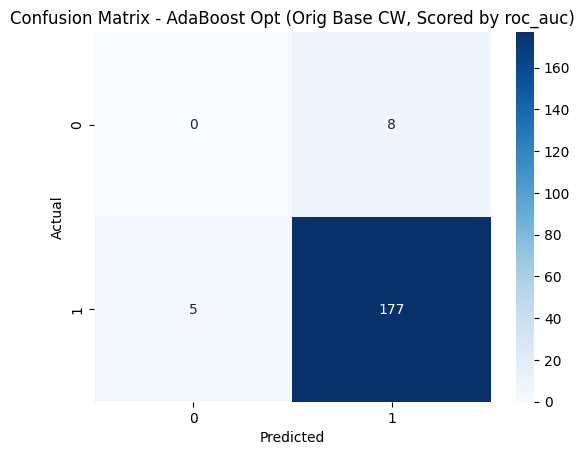


--- Buscando para AdaBoost (SMOTE), optimizando para 'roc_auc' ---
Fitting 5 folds for each of 48 candidates, totalling 240 fits


c:\Users\alexg\Documents\code\datathon2025\NaN-Crew-Datathon-2025-OXXO\.venv\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 48 is smaller than n_iter=50. Running 48 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\alexg\Documents\code\datathon2025\NaN-Crew-Datathon-2025-OXXO\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


Búsqueda completada en 156.60s. Mejores params: {'n_estimators': 150, 'learning_rate': 0.5, 'estimator__max_depth': 3, 'algorithm': 'SAMME'}

--- Evaluación: AdaBoost Opt (SMOTE, Scored by roc_auc) ---
Accuracy: 0.9421 (Objetivo > 0.80)
Precision: 0.9572
Recall: 0.9835
F1-score: 0.9702
ROC AUC: 0.9121

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.96      0.98      0.97       182

    accuracy                           0.94       190
   macro avg       0.48      0.49      0.49       190
weighted avg       0.92      0.94      0.93       190


Confusion Matrix:


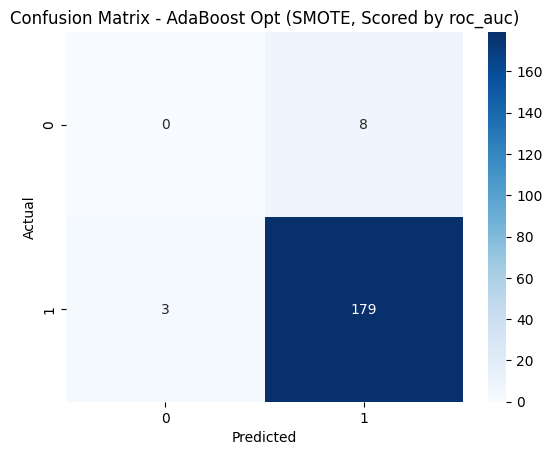

In [ ]:
# --- 3.7 AJUSTE: AdaBoost Classifier ---
print("\n\n==============================================================================")
print("=== AJUSTE HIPERPARÁMETROS 3.7: AdaBoost Classifier ===")
print("==============================================================================")

# Parámetros para AdaBoost y su DecisionTreeClassifier base
ada_param_grid = {
    'estimator__max_depth': [1, 2, 3], # Del DecisionTreeClassifier base
    # 'estimator__class_weight': ['balanced', None], # Para la versión con datos originales
    'n_estimators': [50, 100, 150, 200],
    'learning_rate': [0.01, 0.1, 0.5, 1.0],
    'algorithm': ['SAMME'] # SAMME es más robusto si hay problemas con predict_proba del base
}
# Crear grids separados para la versión original (con class_weight) y SMOTE (sin class_weight en base)
ada_param_grid_orig = ada_param_grid.copy()
ada_param_grid_orig['estimator__class_weight'] = ['balanced', None]

ada_param_grid_smote = ada_param_grid.copy()
# No necesitamos 'estimator__class_weight' para SMOTE en el base estimator

# --- 3.7.1 Ajuste AdaBoost con Datos Originales (con class_weight en el base) ---
print(f"\n--- Buscando para AdaBoost (Original, base con class_weight), optimizando para '{SCORING_METRIC_OPTIMIZATION}' ---")
# NOTA: El estimador debe ser un objeto, no la clase, si vas a pasarle parámetros anidados
ada_orig_search = RandomizedSearchCV(
    estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier(random_state=RANDOM_STATE), random_state=RANDOM_STATE),
    param_distributions=ada_param_grid_orig,
    n_iter=N_ITER_RANDOM_SEARCH,
    cv=StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE),
    scoring=SCORING_METRIC_OPTIMIZATION, verbose=1, random_state=RANDOM_STATE, n_jobs=-1
)
try:
    start_time = time(); ada_orig_search.fit(X_train, y_train); end_time = time()
    print(f"Búsqueda completada en {end_time - start_time:.2f}s. Mejores params: {ada_orig_search.best_params_}")
    best_ada_orig_opt = ada_orig_search.best_estimator_
    y_pred_val_ada_b_opt = best_ada_orig_opt.predict(X_val)
    y_pred_proba_val_ada_b_opt = best_ada_orig_opt.predict_proba(X_val)[:, 1] if hasattr(best_ada_orig_opt, "predict_proba") else None
    res_ada_b_opt = evaluar_modelo(f"AdaBoost Opt (Orig Base CW, Scored by {SCORING_METRIC_OPTIMIZATION})", y_val, y_pred_val_ada_b_opt, y_pred_proba_val_ada_b_opt)
    resultados_modelos.append(res_ada_b_opt)
except Exception as e: print(f"Error en ajuste AdaBoost (Orig Base CW): {e}")

# --- 3.7.2 Ajuste AdaBoost con Datos SMOTE ---
print(f"\n--- Buscando para AdaBoost (SMOTE), optimizando para '{SCORING_METRIC_OPTIMIZATION}' ---")
ada_smote_search = RandomizedSearchCV(
    estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier(random_state=RANDOM_STATE), random_state=RANDOM_STATE), # Base sin class_weight
    param_distributions=ada_param_grid_smote,
    n_iter=N_ITER_RANDOM_SEARCH,
    cv=StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE),
    scoring=SCORING_METRIC_OPTIMIZATION, verbose=1, random_state=RANDOM_STATE, n_jobs=-1
)
try:
    start_time = time(); ada_smote_search.fit(X_train_resampled, y_train_resampled); end_time = time()
    print(f"Búsqueda completada en {end_time - start_time:.2f}s. Mejores params: {ada_smote_search.best_params_}")
    best_ada_smote_opt = ada_smote_search.best_estimator_
    y_pred_val_ada_smote_opt = best_ada_smote_opt.predict(X_val)
    y_pred_proba_val_ada_smote_opt = best_ada_smote_opt.predict_proba(X_val)[:, 1] if hasattr(best_ada_smote_opt, "predict_proba") else None
    res_ada_smote_opt = evaluar_modelo(f"AdaBoost Opt (SMOTE, Scored by {SCORING_METRIC_OPTIMIZATION})", y_val, y_pred_val_ada_smote_opt, y_pred_proba_val_ada_smote_opt)
    resultados_modelos.append(res_ada_smote_opt)
except Exception as e: print(f"Error en ajuste AdaBoost (SMOTE): {e}")


In [ ]:
# --- 3.8 AJUSTE: Gradient Boosting Classifier (Scikit-learn) ---
# No tiene class_weight. Se prueba con datos originales y SMOTE.
print("\n\n==============================================================================")
print("=== AJUSTE HIPERPARÁMETROS 3.8: Gradient Boosting (Scikit-learn) ===")
print("==============================================================================")

gbc_param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# --- 3.8.1 Ajuste GBC con Datos Originales ---
print(f"\n--- Buscando para GBC (Original), optimizando para '{SCORING_METRIC_OPTIMIZATION}' ---")
gbc_orig_search = RandomizedSearchCV(
    estimator=GradientBoostingClassifier(random_state=RANDOM_STATE),
    param_distributions=gbc_param_grid,
    n_iter=N_ITER_RANDOM_SEARCH,
    cv=StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE),
    scoring=SCORING_METRIC_OPTIMIZATION, verbose=1, random_state=RANDOM_STATE, n_jobs=-1
)
try:
    start_time = time(); gbc_orig_search.fit(X_train, y_train); end_time = time()
    print(f"Búsqueda completada en {end_time - start_time:.2f}s. Mejores params: {gbc_orig_search.best_params_}")
    best_gbc_orig_opt = gbc_orig_search.best_estimator_
    y_pred_val_gbc_orig_opt = best_gbc_orig_opt.predict(X_val)
    y_pred_proba_val_gbc_orig_opt = best_gbc_orig_opt.predict_proba(X_val)[:, 1]
    res_gbc_orig_opt = evaluar_modelo(f"GBC sklearn Opt (Original, Scored by {SCORING_METRIC_OPTIMIZATION})", y_val, y_pred_val_gbc_orig_opt, y_pred_proba_val_gbc_orig_opt)
    resultados_modelos.append(res_gbc_orig_opt)
except Exception as e: print(f"Error en ajuste GBC (Original): {e}")

# --- 3.8.2 Ajuste GBC con Datos SMOTE ---
print(f"\n--- Buscando para GBC (SMOTE), optimizando para '{SCORING_METRIC_OPTIMIZATION}' ---")
gbc_smote_search = RandomizedSearchCV(
    estimator=GradientBoostingClassifier(random_state=RANDOM_STATE),
    param_distributions=gbc_param_grid,
    n_iter=N_ITER_RANDOM_SEARCH,
    cv=StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE),
    scoring=SCORING_METRIC_OPTIMIZATION, verbose=1, random_state=RANDOM_STATE, n_jobs=-1
)
try:
    start_time = time(); gbc_smote_search.fit(X_train_resampled, y_train_resampled); end_time = time()
    print(f"Búsqueda completada en {end_time - start_time:.2f}s. Mejores params: {gbc_smote_search.best_params_}")
    best_gbc_smote_opt = gbc_smote_search.best_estimator_
    y_pred_val_gbc_smote_opt = best_gbc_smote_opt.predict(X_val)
    y_pred_proba_val_gbc_smote_opt = best_gbc_smote_opt.predict_proba(X_val)[:, 1]
    res_gbc_smote_opt = evaluar_modelo(f"GBC sklearn Opt (SMOTE, Scored by {SCORING_METRIC_OPTIMIZATION})", y_val, y_pred_val_gbc_smote_opt, y_pred_proba_val_gbc_smote_opt)
    resultados_modelos.append(res_gbc_smote_opt)
except Exception as e: print(f"Error en ajuste GBC (SMOTE): {e}")



=== AJUSTE HIPERPARÁMETROS 3.8: Gradient Boosting (Scikit-learn) ===

--- Buscando para GBC (Original), optimizando para 'roc_auc' ---
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Búsqueda completada en 135.80s. Mejores params: {'subsample': 0.9, 'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 4, 'learning_rate': 0.05}

--- Evaluación: GBC sklearn Opt (Original, Scored by roc_auc) ---
Accuracy: 0.9421 (Objetivo > 0.80)
Precision: 0.9572
Recall: 0.9835
F1-score: 0.9702
ROC AUC: 0.8723

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.96      0.98      0.97       182

    accuracy                           0.94       190
   macro avg       0.48      0.49      0.49       190
weighted avg       0.92      0.94      0.93       190


Confusion Matrix:



--- Buscando para GBC (SMOTE), optimizando para 'roc_auc' ---
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Búsqueda completada en 333.34s. Mejores params: {'subsample': 0.9, 'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 6, 'learning_rate': 0.1}

--- Evaluación: GBC sklearn Opt (SMOTE, Scored by roc_auc) ---
Accuracy: 0.9421 (Objetivo > 0.80)
Precision: 0.9572
Recall: 0.9835
F1-score: 0.9702
ROC AUC: 0.8949

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.96      0.98      0.97       182

    accuracy                           0.94       190
   macro avg       0.48      0.49      0.49       190
weighted avg       0.92      0.94      0.93       190


Confusion Matrix:


In [ ]:
# --- 3.9 AJUSTE: Gaussian Naive Bayes (GNB) ---
# GNB tiene pocos hiperparámetros, principalmente 'var_smoothing'.
print("\n\n==============================================================================")
print("=== AJUSTE HIPERPARÁMETROS 3.9: Gaussian Naive Bayes ===")
print("==============================================================================")

gnb_param_grid = {'var_smoothing': np.logspace(0,-9, num=100)} # Rango típico para var_smoothing

# Convertir a NumPy si no lo son ya, para GNB
X_train_nb_conv = X_train.values if isinstance(X_train, pd.DataFrame) else X_train
X_val_nb_conv = X_val.values if isinstance(X_val, pd.DataFrame) else X_val
X_train_resampled_nb_conv = X_train_resampled.values if isinstance(X_train_resampled, pd.DataFrame) else X_train_resampled

# --- 3.9.1 Ajuste GNB con Datos Originales ---
print(f"\n--- Buscando para GNB (Original), optimizando para '{SCORING_METRIC_OPTIMIZATION}' ---")
gnb_orig_search = GridSearchCV( # GridSearchCV es factible aquí por el único hiperparámetro
    estimator=GaussianNB(),
    param_grid=gnb_param_grid,
    cv=StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE),
    scoring=SCORING_METRIC_OPTIMIZATION, verbose=1, n_jobs=-1
)
try:
    start_time = time(); gnb_orig_search.fit(X_train_nb_conv, y_train); end_time = time()
    print(f"Búsqueda completada en {end_time - start_time:.2f}s. Mejores params: {gnb_orig_search.best_params_}")
    best_gnb_orig_opt = gnb_orig_search.best_estimator_
    y_pred_val_gnb_orig_opt = best_gnb_orig_opt.predict(X_val_nb_conv)
    y_pred_proba_val_gnb_orig_opt = best_gnb_orig_opt.predict_proba(X_val_nb_conv)[:, 1]
    res_gnb_orig_opt = evaluar_modelo(f"GNB Opt (Original, Scored by {SCORING_METRIC_OPTIMIZATION})", y_val, y_pred_val_gnb_orig_opt, y_pred_proba_val_gnb_orig_opt)
    resultados_modelos.append(res_gnb_orig_opt)
except Exception as e: print(f"Error en ajuste GNB (Original): {e}")

# --- 3.9.2 Ajuste GNB con Datos SMOTE ---
print(f"\n--- Buscando para GNB (SMOTE), optimizando para '{SCORING_METRIC_OPTIMIZATION}' ---")
gnb_smote_search = GridSearchCV(
    estimator=GaussianNB(),
    param_grid=gnb_param_grid,
    cv=StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE),
    scoring=SCORING_METRIC_OPTIMIZATION, verbose=1, n_jobs=-1
)
try:
    start_time = time(); gnb_smote_search.fit(X_train_resampled_nb_conv, y_train_resampled); end_time = time()
    print(f"Búsqueda completada en {end_time - start_time:.2f}s. Mejores params: {gnb_smote_search.best_params_}")
    best_gnb_smote_opt = gnb_smote_search.best_estimator_
    y_pred_val_gnb_smote_opt = best_gnb_smote_opt.predict(X_val_nb_conv)
    y_pred_proba_val_gnb_smote_opt = best_gnb_smote_opt.predict_proba(X_val_nb_conv)[:, 1]
    res_gnb_smote_opt = evaluar_modelo(f"GNB Opt (SMOTE, Scored by {SCORING_METRIC_OPTIMIZATION})", y_val, y_pred_val_gnb_smote_opt, y_pred_proba_val_gnb_smote_opt)
    resultados_modelos.append(res_gnb_smote_opt)
except Exception as e: print(f"Error en ajuste GNB (SMOTE): {e}")



=== AJUSTE HIPERPARÁMETROS 3.9: Gaussian Naive Bayes ===

--- Buscando para GNB (Original), optimizando para 'roc_auc' ---
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Búsqueda completada en 0.97s. Mejores params: {'var_smoothing': np.float64(1.873817422860383e-08)}

--- Evaluación: GNB Opt (Original, Scored by roc_auc) ---
Accuracy: 0.4211 (Objetivo > 0.80)
Precision: 0.9737
Recall: 0.4066
F1-score: 0.5736
ROC AUC: 0.7177

Classification Report:
              precision    recall  f1-score   support

           0       0.05      0.75      0.10         8
           1       0.97      0.41      0.57       182

    accuracy                           0.42       190
   macro avg       0.51      0.58      0.34       190
weighted avg       0.93      0.42      0.55       190


Confusion Matrix:



--- Buscando para GNB (SMOTE), optimizando para 'roc_auc' ---
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Búsqueda completada en 1.54s. Mejores params: {'var_smoothing': np.float64(1.519911082952933e-09)}

--- Evaluación: GNB Opt (SMOTE, Scored by roc_auc) ---
Accuracy: 0.5000 (Objetivo > 0.80)
Precision: 0.9780
Recall: 0.4890
F1-score: 0.6520
ROC AUC: 0.7067

Classification Report:
              precision    recall  f1-score   support

           0       0.06      0.75      0.11         8
           1       0.98      0.49      0.65       182

    accuracy                           0.50       190
   macro avg       0.52      0.62      0.38       190
weighted avg       0.94      0.50      0.63       190


Confusion Matrix:




=== AJUSTE HIPERPARÁMETROS 3.10: SGD Classifier ===

--- Buscando para SGD (Original + class_weight), optimizando para 'roc_auc' ---
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Búsqueda completada en 4.69s. Mejores params: {'penalty': 'l2', 'loss': 'log_loss', 'learning_rate': 'adaptive', 'eta0': 0.001, 'class_weight': None, 'alpha': 0.01}

--- Evaluación: SGD Opt (Orig+CW, Scored by roc_auc) ---
Accuracy: 0.9474 (Objetivo > 0.80)
Precision: 0.9574
Recall: 0.9890
F1-score: 0.9730
ROC AUC: 0.7349

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.96      0.99      0.97       182

    accuracy                           0.95       190
   macro avg       0.48      0.49      0.49       190
weighted avg       0.92      0.95      0.93       190


Confusion Matrix:


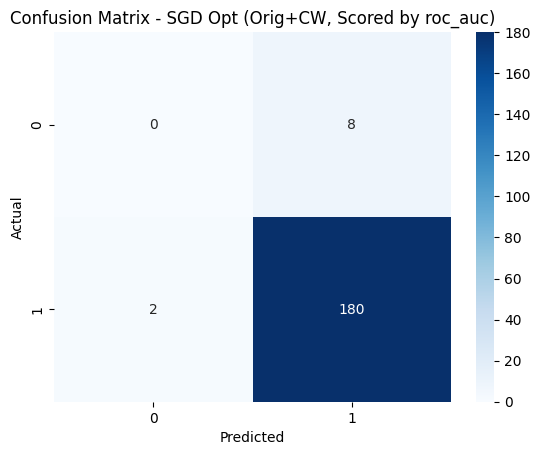


--- Buscando para SGD (SMOTE), optimizando para 'roc_auc' ---
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Búsqueda completada en 4.82s. Mejores params: {'penalty': 'l2', 'loss': 'hinge', 'learning_rate': 'adaptive', 'eta0': 0.001, 'alpha': 0.01}

--- Evaluación: SGD Opt (SMOTE, Scored by roc_auc) ---
Accuracy: 0.8737 (Objetivo > 0.80)
Precision: 0.9702
Recall: 0.8956
F1-score: 0.9314
ROC AUC: 0.6786

Classification Report:
              precision    recall  f1-score   support

           0       0.14      0.38      0.20         8
           1       0.97      0.90      0.93       182

    accuracy                           0.87       190
   macro avg       0.55      0.64      0.57       190
weighted avg       0.94      0.87      0.90       190


Confusion Matrix:


In [ ]:
# --- 3.10 AJUSTE: SGD Classifier ---
print("\n\n==============================================================================")
print("=== AJUSTE HIPERPARÁMETROS 3.10: SGD Classifier ===")
print("==============================================================================")

sgd_param_grid = {
    'loss': ['log_loss', 'hinge', 'modified_huber', 'perceptron'], 
    'penalty': ['l2', 'l1', 'elasticnet'],
    'alpha': [0.00001, 0.0001, 0.001, 0.01],
    'learning_rate': ['optimal', 'adaptive'],
    'eta0': [0.001, 0.01, 0.1], # Solo si learning_rate es 'invscaling', 'adaptive'
    'class_weight': ['balanced', None] # Para versión original
}
sgd_param_grid_smote = sgd_param_grid.copy()
del sgd_param_grid_smote['class_weight']


# --- 3.10.1 Ajuste SGD con Datos Originales + class_weight ---
print(f"\n--- Buscando para SGD (Original + class_weight), optimizando para '{SCORING_METRIC_OPTIMIZATION}' ---")
sgd_orig_search = RandomizedSearchCV(
    estimator=SGDClassifier(random_state=RANDOM_STATE, max_iter=2000, tol=1e-4, n_jobs=-1), # Aumentar max_iter y tol
    param_distributions=sgd_param_grid,
    n_iter=N_ITER_RANDOM_SEARCH,
    cv=StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE),
    scoring=SCORING_METRIC_OPTIMIZATION, verbose=1, random_state=RANDOM_STATE, n_jobs=-1
)
try:
    start_time = time(); sgd_orig_search.fit(X_train, y_train); end_time = time()
    print(f"Búsqueda completada en {end_time - start_time:.2f}s. Mejores params: {sgd_orig_search.best_params_}")
    best_sgd_orig_opt = sgd_orig_search.best_estimator_
    y_pred_val_sgd_b_opt = best_sgd_orig_opt.predict(X_val)
    # Solo log_loss y modified_huber tienen predict_proba
    if hasattr(best_sgd_orig_opt, "predict_proba"):
        y_pred_proba_val_sgd_b_opt = best_sgd_orig_opt.predict_proba(X_val)[:, 1]
    else: # Para hinge, perceptron, etc., calcular decision_function y escalar si se usa para ROC AUC
        try:
            y_decision_val_sgd_b_opt = best_sgd_orig_opt.decision_function(X_val)
            # Escalar decision function para que esté entre 0 y 1 para ROC AUC (aproximación)
            y_pred_proba_val_sgd_b_opt = (y_decision_val_sgd_b_opt - y_decision_val_sgd_b_opt.min()) / (y_decision_val_sgd_b_opt.max() - y_decision_val_sgd_b_opt.min())
            if np.isnan(y_pred_proba_val_sgd_b_opt).any(): y_pred_proba_val_sgd_b_opt = None # Si todos los valores son iguales
        except:
            y_pred_proba_val_sgd_b_opt = None

    res_sgd_b_opt = evaluar_modelo(f"SGD Opt (Orig+CW, Scored by {SCORING_METRIC_OPTIMIZATION})", y_val, y_pred_val_sgd_b_opt, y_pred_proba_val_sgd_b_opt)
    resultados_modelos.append(res_sgd_b_opt)
except Exception as e: print(f"Error en ajuste SGD (Orig+CW): {e}")


# --- 3.10.2 Ajuste SGD con Datos SMOTE ---
print(f"\n--- Buscando para SGD (SMOTE), optimizando para '{SCORING_METRIC_OPTIMIZATION}' ---")
sgd_smote_search = RandomizedSearchCV(
    estimator=SGDClassifier(random_state=RANDOM_STATE, max_iter=2000, tol=1e-4, n_jobs=-1), # Sin class_weight
    param_distributions=sgd_param_grid_smote,
    n_iter=N_ITER_RANDOM_SEARCH,
    cv=StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE),
    scoring=SCORING_METRIC_OPTIMIZATION, verbose=1, random_state=RANDOM_STATE, n_jobs=-1
)
try:
    start_time = time(); sgd_smote_search.fit(X_train_resampled, y_train_resampled); end_time = time()
    print(f"Búsqueda completada en {end_time - start_time:.2f}s. Mejores params: {sgd_smote_search.best_params_}")
    best_sgd_smote_opt = sgd_smote_search.best_estimator_
    y_pred_val_sgd_smote_opt = best_sgd_smote_opt.predict(X_val)
    if hasattr(best_sgd_smote_opt, "predict_proba"):
        y_pred_proba_val_sgd_smote_opt = best_sgd_smote_opt.predict_proba(X_val)[:, 1]
    else:
        try:
            y_decision_val_sgd_smote_opt = best_sgd_smote_opt.decision_function(X_val)
            y_pred_proba_val_sgd_smote_opt = (y_decision_val_sgd_smote_opt - y_decision_val_sgd_smote_opt.min()) / (y_decision_val_sgd_smote_opt.max() - y_decision_val_sgd_smote_opt.min())
            if np.isnan(y_pred_proba_val_sgd_smote_opt).any(): y_pred_proba_val_sgd_smote_opt = None
        except:
            y_pred_proba_val_sgd_smote_opt = None
            
    res_sgd_smote_opt = evaluar_modelo(f"SGD Opt (SMOTE, Scored by {SCORING_METRIC_OPTIMIZATION})", y_val, y_pred_val_sgd_smote_opt, y_pred_proba_val_sgd_smote_opt)
    resultados_modelos.append(res_sgd_smote_opt)
except Exception as e: print(f"Error en ajuste SGD (SMOTE): {e}")



=== AJUSTE HIPERPARÁMETROS 3.11: XGBoost Classifier ===

--- Buscando para XGBoost (Original + scale_pos_weight), optimizando para 'roc_auc' ---
  Calculado scale_pos_weight para datos originales: 0.05
Fitting 10 folds for each of 500 candidates, totalling 5000 fits


c:\Users\alexg\Documents\code\datathon2025\NaN-Crew-Datathon-2025-OXXO\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:46:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Búsqueda completada en 669.27s. Mejores params: {'subsample': 0.9, 'reg_lambda': 0.1, 'reg_alpha': 0.001, 'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.01, 'gamma': 0.2, 'colsample_bytree': 1.0}

--- Evaluación: XGBoost Opt (Orig+ScalePW, Scored by roc_auc) ---
Accuracy: 0.9316 (Objetivo > 0.80)
Precision: 0.9942
Recall: 0.9341
F1-score: 0.9632
ROC AUC: 0.9588

Classification Report:
              precision    recall  f1-score   support

           0       0.37      0.88      0.52         8
           1       0.99      0.93      0.96       182

    accuracy                           0.93       190
   macro avg       0.68      0.90      0.74       190
weighted avg       0.97      0.93      0.94       190


Confusion Matrix:


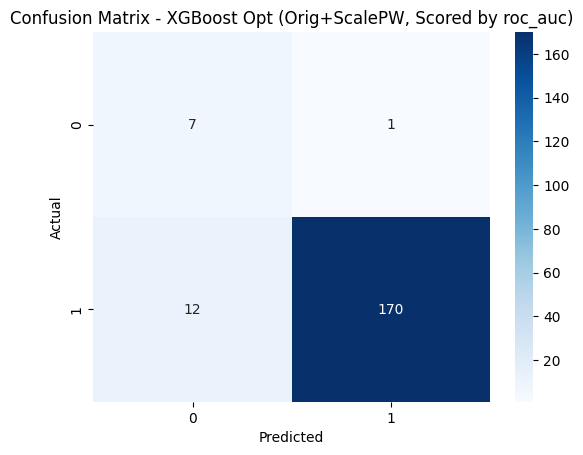


--- Buscando para XGBoost (SMOTE), optimizando para 'roc_auc' ---
Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\alexg\Documents\code\datathon2025\NaN-Crew-Datathon-2025-OXXO\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:46:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Búsqueda completada en 21.24s. Mejores params: {'subsample': 1.0, 'reg_lambda': 1, 'reg_alpha': 0.1, 'n_estimators': 400, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0.3, 'colsample_bytree': 0.7}

--- Evaluación: XGBoost Opt (SMOTE, Scored by roc_auc) ---
Accuracy: 0.9474 (Objetivo > 0.80)
Precision: 0.9574
Recall: 0.9890
F1-score: 0.9730
ROC AUC: 0.9348

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.96      0.99      0.97       182

    accuracy                           0.95       190
   macro avg       0.48      0.49      0.49       190
weighted avg       0.92      0.95      0.93       190


Confusion Matrix:


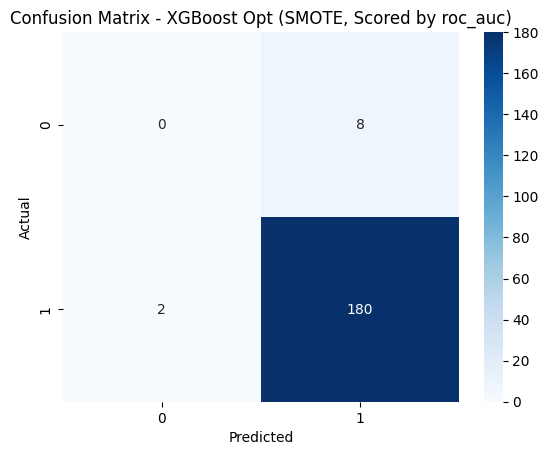

In [ ]:
# --- 3.11 AJUSTE: XGBoost Classifier ---
if xgb:
    print("\n\n==============================================================================")
    print("=== AJUSTE HIPERPARÁMETROS 3.11: XGBoost Classifier ===")
    print("==============================================================================")

    xgb_param_grid = {
        'n_estimators': [100, 200, 300, 400],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'max_depth': [3, 4, 5, 6, 7],
        'subsample': [0.6, 0.7, 0.8, 0.9, 1.0], # Fracción de muestras para entrenar cada árbol
        'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0], # Fracción de features para entrenar cada árbol
        'gamma': [0, 0.1, 0.2, 0.3], # Reducción mínima de pérdida para hacer una partición
        'reg_alpha': [0, 0.001, 0.01, 0.1], # L1 regularización
        'reg_lambda': [0.1, 1, 10] # L2 regularización
        # scale_pos_weight se maneja por separado
    }

    # --- 3.11.1 Ajuste XGBoost con Datos Originales + scale_pos_weight ---
    print(f"\n--- Buscando para XGBoost (Original + scale_pos_weight), optimizando para '{SCORING_METRIC_OPTIMIZATION}' ---")
    count_neg_orig, count_pos_orig = y_train.value_counts().sort_index()
    scale_pos_w_orig = count_neg_orig / count_pos_orig
    print(f"  Calculado scale_pos_weight para datos originales: {scale_pos_w_orig:.2f}")
    
    xgb_orig_search = RandomizedSearchCV(
        estimator=xgb.XGBClassifier(random_state=RANDOM_STATE, use_label_encoder=False, eval_metric='logloss', scale_pos_weight=scale_pos_w_orig),
        param_distributions=xgb_param_grid, # El grid no incluye scale_pos_weight, ya está en el estimador
        n_iter=500, # Aumentar si es posible
        cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE),
        scoring=SCORING_METRIC_OPTIMIZATION, verbose=1, random_state=RANDOM_STATE, n_jobs=-1
    )
    try:
        start_time = time(); xgb_orig_search.fit(X_train, y_train); end_time = time()
        print(f"Búsqueda completada en {end_time - start_time:.2f}s. Mejores params: {xgb_orig_search.best_params_}")
        best_xgb_orig_opt = xgb_orig_search.best_estimator_
        y_pred_val_xgb_b_opt = best_xgb_orig_opt.predict(X_val)
        y_pred_proba_val_xgb_b_opt = best_xgb_orig_opt.predict_proba(X_val)[:, 1]
        res_xgb_b_opt = evaluar_modelo(f"XGBoost Opt (Orig+ScalePW, Scored by {SCORING_METRIC_OPTIMIZATION})", y_val, y_pred_val_xgb_b_opt, y_pred_proba_val_xgb_b_opt)
        resultados_modelos.append(res_xgb_b_opt)
    except Exception as e: print(f"Error en ajuste XGBoost (Orig+ScalePW): {e}")

    # --- 3.11.2 Ajuste XGBoost con Datos SMOTE ---
    print(f"\n--- Buscando para XGBoost (SMOTE), optimizando para '{SCORING_METRIC_OPTIMIZATION}' ---")
    # Para SMOTE, no se necesita scale_pos_weight
    xgb_smote_search = RandomizedSearchCV(
        estimator=xgb.XGBClassifier(random_state=RANDOM_STATE, use_label_encoder=False, eval_metric='logloss'),
        param_distributions=xgb_param_grid, # El mismo grid, scale_pos_weight no se aplica
        n_iter=10, # Aumentar si es posible
        cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE),
        scoring=SCORING_METRIC_OPTIMIZATION, verbose=1, random_state=RANDOM_STATE, n_jobs=-1
    )
    try:
        start_time = time(); xgb_smote_search.fit(X_train_resampled, y_train_resampled); end_time = time()
        print(f"Búsqueda completada en {end_time - start_time:.2f}s. Mejores params: {xgb_smote_search.best_params_}")
        best_xgb_smote_opt = xgb_smote_search.best_estimator_
        y_pred_val_xgb_smote_opt = best_xgb_smote_opt.predict(X_val)
        y_pred_proba_val_xgb_smote_opt = best_xgb_smote_opt.predict_proba(X_val)[:, 1]
        res_xgb_smote_opt = evaluar_modelo(f"XGBoost Opt (SMOTE, Scored by {SCORING_METRIC_OPTIMIZATION})", y_val, y_pred_val_xgb_smote_opt, y_pred_proba_val_xgb_smote_opt)
        resultados_modelos.append(res_xgb_smote_opt)
    except Exception as e: print(f"Error en ajuste XGBoost (SMOTE): {e}")
else:
    print("\n\nXGBoost no está instalado, se omite esta sección de ajuste.")



=== AJUSTE HIPERPARÁMETROS 3.12: LightGBM Classifier ===

--- Buscando para LightGBM (Original + class_weight), optimizando para 'roc_auc' ---
Fitting 5 folds for each of 50 candidates, totalling 250 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 723, number of negative: 33
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005720 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 41056
[LightGBM] [Info] Number of data points in the train set: 756, number of used features: 313
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.956349 -> initscore=3.086902
[LightGBM] [Info] Start training from score 3.086902
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[


--- Buscando para LightGBM (SMOTE), optimizando para 'roc_auc' ---
Fitting 5 folds for each of 50 candidates, totalling 250 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 723, number of negative: 723
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008184 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 68241
[LightGBM] [Info] Number of data points in the train set: 1446, number of used features: 316
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

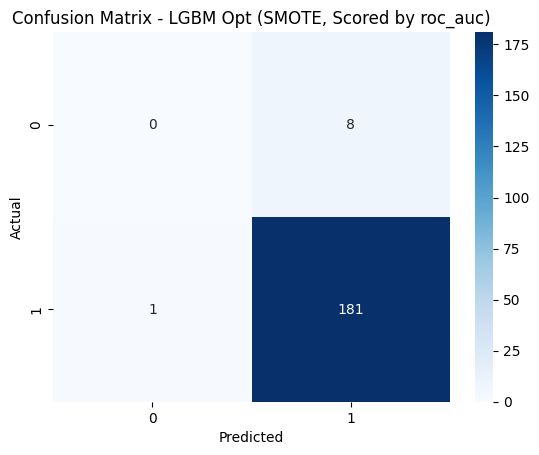

In [ ]:
# --- 3.12 AJUSTE: LightGBM Classifier ---
if lgb:
    print("\n\n==============================================================================")
    print("=== AJUSTE HIPERPARÁMETROS 3.12: LightGBM Classifier ===")
    print("==============================================================================")

    lgbm_param_grid = {
        'n_estimators': [100, 200, 300, 500],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'num_leaves': [20, 31, 40, 50, 60], # <= 2^max_depth
        'max_depth': [-1, 10, 15, 20],
        'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],      # Aliases: bagging_fraction
        'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0], # Aliases: feature_fraction
        'reg_alpha': [0, 0.01, 0.1, 0.5], # L1
        'reg_lambda': [0, 0.01, 0.1, 0.5], # L2
        'class_weight': ['balanced', None] # Para versión original. Alternativa 'is_unbalance': [True, False]
    }
    lgbm_param_grid_smote = lgbm_param_grid.copy()
    del lgbm_param_grid_smote['class_weight']
    # lgbm_param_grid_smote['is_unbalance'] = [False] # Si SMOTE ya balanceó

    # --- 3.12.1 Ajuste LightGBM con Datos Originales + class_weight ---
    print(f"\n--- Buscando para LightGBM (Original + class_weight), optimizando para '{SCORING_METRIC_OPTIMIZATION}' ---")
    lgbm_orig_search = RandomizedSearchCV(
        estimator=lgb.LGBMClassifier(random_state=RANDOM_STATE, n_jobs=-1),
        param_distributions=lgbm_param_grid,
        n_iter=N_ITER_RANDOM_SEARCH,
        cv=StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE),
        scoring=SCORING_METRIC_OPTIMIZATION, verbose=1, random_state=RANDOM_STATE, n_jobs=-1
    )
    try:
        start_time = time(); lgbm_orig_search.fit(X_train, y_train); end_time = time()
        print(f"Búsqueda completada en {end_time - start_time:.2f}s. Mejores params: {lgbm_orig_search.best_params_}")
        best_lgbm_orig_opt = lgbm_orig_search.best_estimator_
        y_pred_val_lgbm_b_opt = best_lgbm_orig_opt.predict(X_val)
        y_pred_proba_val_lgbm_b_opt = best_lgbm_orig_opt.predict_proba(X_val)[:, 1]
        res_lgbm_b_opt = evaluar_modelo(f"LGBM Opt (Orig+CW, Scored by {SCORING_METRIC_OPTIMIZATION})", y_val, y_pred_val_lgbm_b_opt, y_pred_proba_val_lgbm_b_opt)
        resultados_modelos.append(res_lgbm_b_opt)
    except Exception as e: print(f"Error en ajuste LightGBM (Orig+CW): {e}")

    # --- 3.12.2 Ajuste LightGBM con Datos SMOTE ---
    print(f"\n--- Buscando para LightGBM (SMOTE), optimizando para '{SCORING_METRIC_OPTIMIZATION}' ---")
    lgbm_smote_search = RandomizedSearchCV(
        estimator=lgb.LGBMClassifier(random_state=RANDOM_STATE, n_jobs=-1), # Sin class_weight
        param_distributions=lgbm_param_grid_smote,
        n_iter=N_ITER_RANDOM_SEARCH,
        cv=StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE),
        scoring=SCORING_METRIC_OPTIMIZATION, verbose=1, random_state=RANDOM_STATE, n_jobs=-1
    )
    try:
        start_time = time(); lgbm_smote_search.fit(X_train_resampled, y_train_resampled); end_time = time()
        print(f"Búsqueda completada en {end_time - start_time:.2f}s. Mejores params: {lgbm_smote_search.best_params_}")
        best_lgbm_smote_opt = lgbm_smote_search.best_estimator_
        y_pred_val_lgbm_smote_opt = best_lgbm_smote_opt.predict(X_val)
        y_pred_proba_val_lgbm_smote_opt = best_lgbm_smote_opt.predict_proba(X_val)[:, 1]
        res_lgbm_smote_opt = evaluar_modelo(f"LGBM Opt (SMOTE, Scored by {SCORING_METRIC_OPTIMIZATION})", y_val, y_pred_val_lgbm_smote_opt, y_pred_proba_val_lgbm_smote_opt)
        resultados_modelos.append(res_lgbm_smote_opt)
    except Exception as e: print(f"Error en ajuste LightGBM (SMOTE): {e}")
else:
    print("\n\nLightGBM no está instalado, se omite esta sección de ajuste.")



=== AJUSTE HIPERPARÁMETROS 3.13: CatBoost Classifier ===

--- Buscando para CatBoost (Original + auto_class_weights), optimizando para 'roc_auc' ---
Fitting 3 folds for each of 5 candidates, totalling 15 fits


c:\Users\alexg\Documents\code\datathon2025\NaN-Crew-Datathon-2025-OXXO\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
3 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\alexg\Documents\code\datathon2025\NaN-Crew-Datathon-2025-OXXO\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\alexg\Documents\code\datathon2025\NaN-Crew-Datathon-2025-OXXO\.venv\Lib\site-packages\catboost\core.py", line 5245, in fit
    self._fit(X, y, cat_features, text_features, embedding_features,

Búsqueda completada en 9.70s. Mejores params: {'learning_rate': 0.01, 'l2_leaf_reg': 9, 'iterations': 200, 'depth': 6, 'border_count': 32, 'auto_class_weights': 'SqrtBalanced'}

--- Evaluación: CatBoost Opt (Orig+ACW, Scored by roc_auc) ---
Accuracy: 0.9526 (Objetivo > 0.80)
Precision: 0.9577
Recall: 0.9945
F1-score: 0.9757
ROC AUC: 0.9409

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.96      0.99      0.98       182

    accuracy                           0.95       190
   macro avg       0.48      0.50      0.49       190
weighted avg       0.92      0.95      0.93       190


Confusion Matrix:


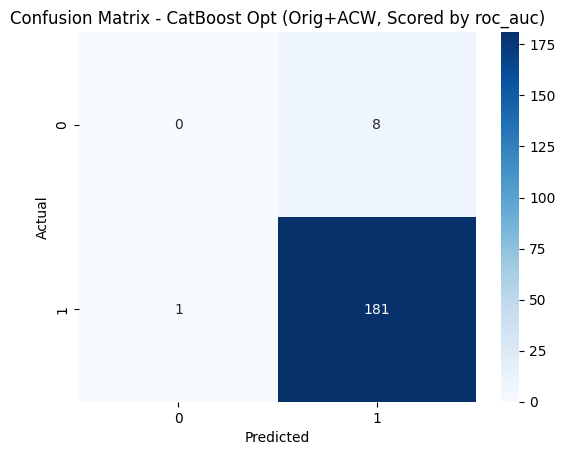


--- Buscando para CatBoost (SMOTE), optimizando para 'roc_auc' ---
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Búsqueda completada en 38.43s. Mejores params: {'learning_rate': 0.1, 'l2_leaf_reg': 1, 'iterations': 500, 'depth': 8, 'border_count': 64}

--- Evaluación: CatBoost Opt (SMOTE, Scored by roc_auc) ---
Accuracy: 0.9526 (Objetivo > 0.80)
Precision: 0.9577
Recall: 0.9945
F1-score: 0.9757
ROC AUC: 0.9396

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.96      0.99      0.98       182

    accuracy                           0.95       190
   macro avg       0.48      0.50      0.49       190
weighted avg       0.92      0.95      0.93       190


Confusion Matrix:


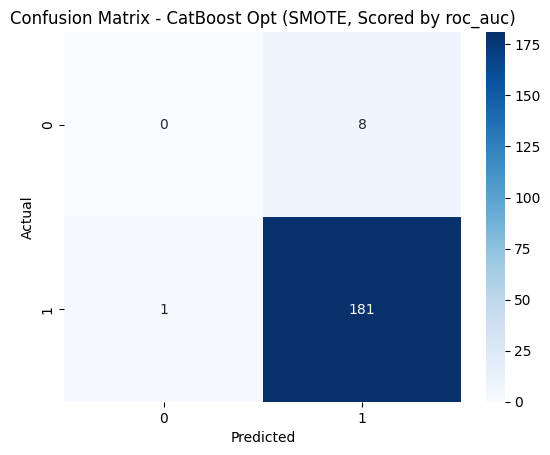

In [ ]:
# --- 3.13 AJUSTE: CatBoost Classifier ---
if cb:
    print("\n\n==============================================================================")
    print("=== AJUSTE HIPERPARÁMETROS 3.13: CatBoost Classifier ===")
    print("==============================================================================")

    cb_param_grid = {
        'iterations': [100, 200, 300, 500],
        'learning_rate': [0.01, 0.03, 0.05, 0.1],
        'depth': [4, 6, 8, 10],
        'l2_leaf_reg': [1, 3, 5, 9], # Regularización L2
        'border_count': [32, 64, 128], # Número de divisiones para features numéricas
        'auto_class_weights': ['Balanced', 'SqrtBalanced', None] # Para versión original
    }
    cb_param_grid_smote = cb_param_grid.copy()
    del cb_param_grid_smote['auto_class_weights']
    
    # CatBoost prefiere DataFrames de Pandas si se usan feature_names
    X_train_cb_df = X_train if isinstance(X_train, pd.DataFrame) else pd.DataFrame(X_train, columns=nombres_columnas_procesadas if 'nombres_columnas_procesadas' in locals() else None)
    X_val_cb_df = X_val if isinstance(X_val, pd.DataFrame) else pd.DataFrame(X_val, columns=nombres_columnas_procesadas if 'nombres_columnas_procesadas' in locals() else None)
    X_train_resampled_cb_df = X_train_resampled if isinstance(X_train_resampled, pd.DataFrame) else pd.DataFrame(X_train_resampled, columns=nombres_columnas_procesadas if 'nombres_columnas_procesadas' in locals() else None)


    # --- 3.13.1 Ajuste CatBoost con Datos Originales + auto_class_weights ---
    print(f"\n--- Buscando para CatBoost (Original + auto_class_weights), optimizando para '{SCORING_METRIC_OPTIMIZATION}' ---")
    cb_orig_search = RandomizedSearchCV(
        estimator=cb.CatBoostClassifier(random_state=RANDOM_STATE, verbose=0, thread_count=-1),
        param_distributions=cb_param_grid,
        n_iter=5,
        cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE),
        scoring=SCORING_METRIC_OPTIMIZATION, verbose=1, random_state=RANDOM_STATE # n_jobs no es para CatBoostSearchCV
    )
    try:
        start_time = time(); cb_orig_search.fit(X_train_cb_df, y_train); end_time = time() # Pasando feature_names si X_train es DF
        print(f"Búsqueda completada en {end_time - start_time:.2f}s. Mejores params: {cb_orig_search.best_params_}")
        best_cb_orig_opt = cb_orig_search.best_estimator_
        y_pred_val_cb_b_opt = best_cb_orig_opt.predict(X_val_cb_df)
        y_pred_proba_val_cb_b_opt = best_cb_orig_opt.predict_proba(X_val_cb_df)[:, 1]
        res_cb_b_opt = evaluar_modelo(f"CatBoost Opt (Orig+ACW, Scored by {SCORING_METRIC_OPTIMIZATION})", y_val, y_pred_val_cb_b_opt, y_pred_proba_val_cb_b_opt)
        resultados_modelos.append(res_cb_b_opt)
    except Exception as e: print(f"Error en ajuste CatBoost (Orig+ACW): {e}")

    # --- 3.13.2 Ajuste CatBoost con Datos SMOTE ---
    print(f"\n--- Buscando para CatBoost (SMOTE), optimizando para '{SCORING_METRIC_OPTIMIZATION}' ---")
    cb_smote_search = RandomizedSearchCV(
        estimator=cb.CatBoostClassifier(random_state=RANDOM_STATE, verbose=0, thread_count=-1), # Sin auto_class_weights
        param_distributions=cb_param_grid_smote,
        n_iter=5,
        cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE),
        scoring=SCORING_METRIC_OPTIMIZATION, verbose=1, random_state=RANDOM_STATE
    )
    try:
        start_time = time(); cb_smote_search.fit(X_train_resampled_cb_df, y_train_resampled); end_time = time()
        print(f"Búsqueda completada en {end_time - start_time:.2f}s. Mejores params: {cb_smote_search.best_params_}")
        best_cb_smote_opt = cb_smote_search.best_estimator_
        y_pred_val_cb_smote_opt = best_cb_smote_opt.predict(X_val_cb_df)
        y_pred_proba_val_cb_smote_opt = best_cb_smote_opt.predict_proba(X_val_cb_df)[:, 1]
        res_cb_smote_opt = evaluar_modelo(f"CatBoost Opt (SMOTE, Scored by {SCORING_METRIC_OPTIMIZATION})", y_val, y_pred_val_cb_smote_opt, y_pred_proba_val_cb_smote_opt)
        resultados_modelos.append(res_cb_smote_opt)
    except Exception as e: print(f"Error en ajuste CatBoost (SMOTE): {e}")
else:
    print("\n\nCatBoost no está instalado, se omite esta sección de ajuste.")

In [ ]:
# --- 4. Resumen Comparativo FINAL de Modelos (Incluyendo Optimizados) ---
print("\n\n==============================================================================")
print("=== Resumen Comparativo FINAL de Modelos (Incluyendo Optimizados) ===")
print("==============================================================================")
if resultados_modelos:
    df_resultados_final = pd.DataFrame(resultados_modelos)
    df_resultados_final = df_resultados_final.sort_values(by=SCORING_METRIC_OPTIMIZATION, ascending=False) 
    print(df_resultados_final.to_string())
    
    # Guardar resultados a CSV
    df_resultados_final.to_csv(RUTA_DATOS_PROCESADOS + 'comparacion_modelos_final_optimizados.csv', index=False)
    print(f"\nTabla de comparación final guardada en '{RUTA_DATOS_PROCESADOS}comparacion_modelos_final_optimizados.csv'")
    
    # Gráfico de barras para Accuracy
    plt.figure(figsize=(15, max(10, len(df_resultados_final) * 0.5))) # Ajustar altura dinámicamente
    sns.barplot(x='accuracy', y='modelo', data=df_resultados_final, palette='viridis', hue='modelo', dodge=False, legend=False)
    plt.title('Comparación de Accuracy de Modelos Optimizados (Validación)')
    plt.xlabel('Accuracy (Objetivo > 0.80)')
    plt.ylabel('Modelo')
    plt.xlim(min(0.5, df_resultados_final['accuracy'].min() - 0.05) , 1.0) 
    plt.axvline(x=0.80, color='r', linestyle='--', label='Objetivo 80% Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Gráfico de barras para ROC AUC (o la métrica de optimización)
    if SCORING_METRIC_OPTIMIZATION in df_resultados_final.columns and df_resultados_final[SCORING_METRIC_OPTIMIZATION].notnull().any():
        plt.figure(figsize=(15, max(10, len(df_resultados_final) * 0.5)))
        sns.barplot(x=SCORING_METRIC_OPTIMIZATION, y='modelo', data=df_resultados_final, palette='mako', hue='modelo', dodge=False, legend=False)
        plt.title(f'Comparación de {SCORING_METRIC_OPTIMIZATION.upper()} de Modelos Optimizados (Validación)')
        plt.xlabel(SCORING_METRIC_OPTIMIZATION.upper())
        plt.ylabel('Modelo')
        plt.xlim(min(0.0, df_resultados_final[SCORING_METRIC_OPTIMIZATION].min() - 0.05) , 1.0)
        plt.tight_layout()
        plt.show()
else:
    print("No se generaron resultados de modelos para comparar.")

print("\n--- Ajuste de Hiperparámetros y Evaluación Completados ---")
print("Revisa 'comparacion_modelos_final_optimizados.csv' para seleccionar el mejor modelo.")
print("El siguiente paso sería entrenar el MEJOR modelo con TODOS los datos de entrenamiento disponibles (X_train + X_val),")
print("y luego usarlo para predecir en el X_test_oficial_procesado y en el conjunto de evaluación del jurado.")



=== Resumen Comparativo FINAL de Modelos (Incluyendo Optimizados) ===
                                            modelo  accuracy  precision    recall        f1   roc_auc
44   XGBoost Opt (Orig+ScalePW, Scored by roc_auc)  0.931579   0.994152  0.934066  0.963173  0.958791
54   XGBoost Opt (Orig+ScalePW, Scored by roc_auc)  0.931579   0.994152  0.934066  0.963173  0.958791
21                      XGBoost (scale_pos_weight)  0.931579   0.977401  0.950549  0.963788  0.955701
26                                CatBoost (SMOTE)  0.947368   0.957447  0.989011  0.972973  0.953297
50           LGBM Opt (Orig+CW, Scored by roc_auc)  0.957895   0.957895  1.000000  0.978495  0.946429
45          XGBoost Opt (SMOTE, Scored by roc_auc)  0.947368   0.957447  0.989011  0.972973  0.946429
52      CatBoost Opt (Orig+ACW, Scored by roc_auc)  0.952632   0.957672  0.994505  0.975741  0.940934
51             LGBM Opt (SMOTE, Scored by roc_auc)  0.952632   0.957672  0.994505  0.975741  0.940247
53        


--- Ajuste de Hiperparámetros y Evaluación Completados ---
Revisa 'comparacion_modelos_final_optimizados.csv' para seleccionar el mejor modelo.
El siguiente paso sería entrenar el MEJOR modelo con TODOS los datos de entrenamiento disponibles (X_train + X_val),
y luego usarlo para predecir en el X_test_oficial_procesado y en el conjunto de evaluación del jurado.




=== RE-AJUSTE HIPERPARÁMETROS: XGBoost (Orig+ScalePW) - Foco Clase Minoritaria ===
XGBoost (Original): Usando scale_pos_weight = 0.0456

--- Re-buscando para XGBoost (Original + scale_pos_weight), optimizando para F1-score de la clase 0 ---
Fitting 5 folds for each of 30 candidates, totalling 150 fits


c:\Users\alexg\Documents\code\datathon2025\NaN-Crew-Datathon-2025-OXXO\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [06:41:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Búsqueda refinada completada en 34.54s.
Mejores parámetros para XGBoost (Orig+ScalePW, Foco Clase 0): {'subsample': 1.0, 'reg_lambda': 5, 'reg_alpha': 0, 'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.01, 'gamma': 0.1, 'colsample_bytree': 1.0}
Mejor puntuación 'make_scorer(f1_score, response_method='predict', pos_label=0, zero_division=0)' (CV): 0.1707

--- Evaluación: XGBoost REFINADO (Orig+ScalePW, Scored by make_scorer(f1_score, response_method='predict', pos_label=0, zero_division=0)) ---
Accuracy: 0.8263 (Objetivo > 0.80)
Precision: 1.0000
Recall: 0.8187
F1-score: 0.9003
ROC AUC: 0.9499

Classification Report:
              precision    recall  f1-score   support

           0       0.20      1.00      0.33         8
           1       1.00      0.82      0.90       182

    accuracy                           0.83       190
   macro avg       0.60      0.91      0.61       190
weighted avg       0.97      0.83      0.88       190


Confusion Matrix:


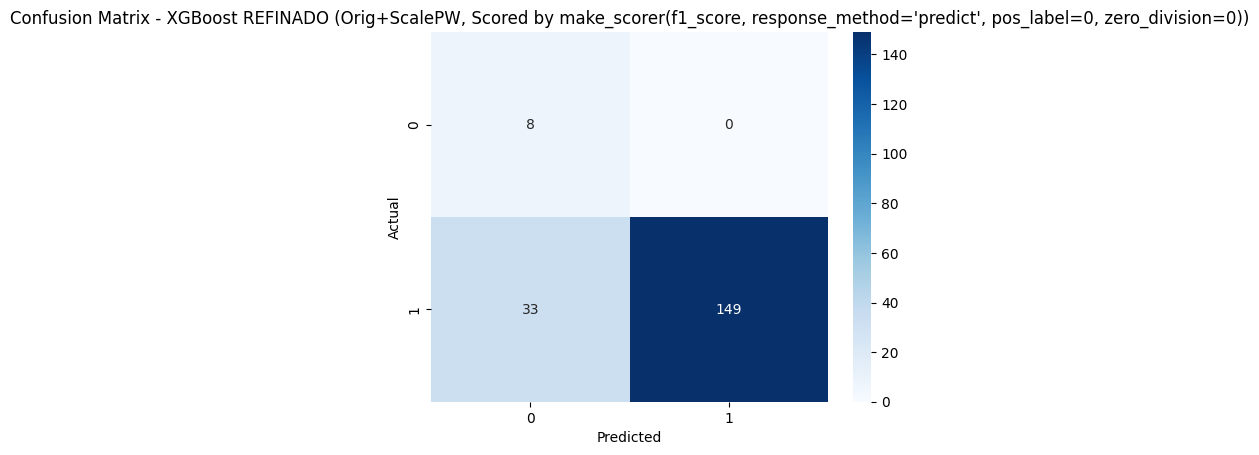


Resultados del Modelo XGBoost Refinado en Validación:
  modelo: XGBoost REFINADO (Orig+ScalePW, Scored by make_scorer(f1_score, response_method='predict', pos_label=0, zero_division=0))
  accuracy: 0.8263
  precision: 1.0000
  recall: 0.8187
  f1: 0.9003
  roc_auc: 0.9499
Modelo XGBoost refinado guardado en './datos/output/procesado_para_modelado/modelo_xgb_refinado_clase0.joblib'


In [32]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, recall_score, f1_score, balanced_accuracy_score
import xgboost as xgb
from time import time

# Definir scorers personalizados enfocados en la clase minoritaria (0)
recall_clase_0_scorer = make_scorer(recall_score, pos_label=0, zero_division=0)
f1_clase_0_scorer = make_scorer(f1_score, pos_label=0, zero_division=0)
# balanced_accuracy_scorer ya existe en sklearn.metrics

# --- RE-AJUSTE: XGBoost Classifier (Datos Originales + scale_pos_weight) ---
# --- Enfocado en mejorar la predicción de la clase minoritaria (EXITO=0) ---
print("\n\n==============================================================================")
print("=== RE-AJUSTE HIPERPARÁMETROS: XGBoost (Orig+ScalePW) - Foco Clase Minoritaria ===")
print("==============================================================================")

# Calcular scale_pos_weight para datos originales (y_train)
count_neg_orig, count_pos_orig = y_train.value_counts().sort_index()
# Si la clase 0 es la minoritaria, scale_pos_weight es count_majority / count_minority
# En tu caso, EXITO=1 es mayoritario, EXITO=0 es minoritario.
# scale_pos_weight se aplica a la clase positiva (1). Para darle más peso a la negativa (0),
# algunos lo interpretan como: si la clase positiva es la minoritaria, scale_pos_weight > 1.
# Si la clase positiva es la mayoritaria (como en tu caso), scale_pos_weight < 1 para "reducir" su peso
# o, más comúnmente, se usa para *aumentar* el peso de la clase positiva si esta es la minoritaria.
# Dado que EXITO=1 es la mayoritaria, scale_pos_weight = count_neg_orig / count_pos_orig le dará MENOS peso a la clase 1.
# Esto es correcto si queremos que el modelo preste más atención a la clase 0.
scale_pos_w_orig = count_neg_orig / count_pos_orig 
print(f"XGBoost (Original): Usando scale_pos_weight = {scale_pos_w_orig:.4f}")

# Espacio de búsqueda de hiperparámetros para XGBoost
# Podríamos necesitar tasas de aprendizaje más bajas, más árboles, o diferente max_depth
# para capturar mejor la clase minoritaria. También podemos probar diferentes valores de scale_pos_weight.
xgb_param_grid_refined = {
    'n_estimators': [200, 300, 400, 500],
    'learning_rate': [0.01, 0.02, 0.05, 0.1],
    'max_depth': [3, 4, 5, 6, 7, 8], # Probar profundidades variadas
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.5],
    'reg_alpha': [0, 0.001, 0.01, 0.1],
    'reg_lambda': [0.1, 0.5, 1, 5, 10],
    # scale_pos_weight se define en el estimador base, pero podríamos incluirlo en el grid
    # para que RandomizedSearchCV también lo explore si queremos.
    # 'scale_pos_weight': [scale_pos_w_orig, scale_pos_w_orig * 0.5, scale_pos_w_orig * 2] # Ejemplo de exploración
}

# Métrica de optimización: F1-score para la clase 0
SCORING_METRIC_REFINED = f1_clase_0_scorer 
# Otras opciones: SCORING_METRIC_REFINED = recall_clase_0_scorer
#              SCORING_METRIC_REFINED = 'f1_macro'
#              SCORING_METRIC_REFINED = 'balanced_accuracy'

print(f"\n--- Re-buscando para XGBoost (Original + scale_pos_weight), optimizando para F1-score de la clase 0 ---")

xgb_orig_refined_search = RandomizedSearchCV(
    estimator=xgb.XGBClassifier(
        random_state=RANDOM_STATE, 
        use_label_encoder=False, # obsoleto, mejor no usar o poner False explícitamente
        eval_metric='logloss', # o 'aucpr' para desbalance
        scale_pos_weight=scale_pos_w_orig # Usar el calculado
    ),
    param_distributions=xgb_param_grid_refined,
    n_iter=30, # Aumentar n_iter para una búsqueda más exhaustiva si el tiempo lo permite
    cv=StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE), # CV_FOLDS = 3 o 5
    scoring=SCORING_METRIC_REFINED, 
    verbose=1, 
    random_state=RANDOM_STATE, 
    n_jobs=-1
)

try:
    start_time = time()
    xgb_orig_refined_search.fit(X_train, y_train) # Entrenar con X_train original
    end_time = time()
    print(f"Búsqueda refinada completada en {end_time - start_time:.2f}s.")
    print(f"Mejores parámetros para XGBoost (Orig+ScalePW, Foco Clase 0): {xgb_orig_refined_search.best_params_}")
    print(f"Mejor puntuación '{str(SCORING_METRIC_REFINED)}' (CV): {xgb_orig_refined_search.best_score_:.4f}")

    best_xgb_orig_refined = xgb_orig_refined_search.best_estimator_
    
    # Evaluar este nuevo mejor modelo en el conjunto de validación
    y_pred_val_xgb_refined = best_xgb_orig_refined.predict(X_val)
    y_pred_proba_val_xgb_refined = best_xgb_orig_refined.predict_proba(X_val)[:, 1]
    
    res_xgb_refined = evaluar_modelo(
        f"XGBoost REFINADO (Orig+ScalePW, Scored by {str(SCORING_METRIC_REFINED)})", 
        y_val, 
        y_pred_val_xgb_refined, 
        y_pred_proba_val_xgb_refined
    )
    # Podrías añadir este resultado a una nueva lista o compararlo directamente
    print("\nResultados del Modelo XGBoost Refinado en Validación:")
    for key, value in res_xgb_refined.items():
        if isinstance(value, float):
            print(f"  {key}: {value:.4f}")
        else:
            print(f"  {key}: {value}")
            
    # Guardar este modelo refinado
    joblib.dump(best_xgb_orig_refined, RUTA_DATOS_PROCESADOS + 'modelo_xgb_refinado_clase0.joblib')
    print(f"Modelo XGBoost refinado guardado en '{RUTA_DATOS_PROCESADOS}modelo_xgb_refinado_clase0.joblib'")

except Exception as e: 
    print(f"Error en el re-ajuste de XGBoost (Orig+ScalePW): {e}")
    raise # Levantar el error para ver el traceback completo

In [33]:
# --- OPCIONAL: Probar XGBoost con SMOTE y optimizar para F1-score de clase 0 ---
# Esto es por si la estrategia con scale_pos_weight no da los resultados esperados
# para la clase minoritaria incluso después de optimizar para su F1.

xgb_param_grid_smote_refined = xgb_param_grid_refined.copy()
if 'scale_pos_weight' in xgb_param_grid_smote_refined: # No lo necesitamos con SMOTE
    del xgb_param_grid_smote_refined['scale_pos_weight']

print(f"\n--- Re-buscando para XGBoost (SMOTE), optimizando para F1-score de la clase 0 ---")
xgb_smote_refined_search = RandomizedSearchCV(
    estimator=xgb.XGBClassifier(random_state=RANDOM_STATE, use_label_encoder=False, eval_metric='logloss'),
    param_distributions=xgb_param_grid_smote_refined,
    n_iter=N_ITER_RANDOM_SEARCH, 
    cv=StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE),
    scoring=SCORING_METRIC_REFINED, 
    verbose=1, 
    random_state=RANDOM_STATE, 
    n_jobs=-1
)
try:
    start_time = time()
    xgb_smote_refined_search.fit(X_train_resampled, y_train_resampled) # Usar datos SMOTE
    end_time = time()
    print(f"Búsqueda SMOTE completada en {end_time - start_time:.2f}s.")
    print(f"Mejores parámetros para XGBoost (SMOTE, Foco Clase 0): {xgb_smote_refined_search.best_params_}")
    print(f"Mejor puntuación '{str(SCORING_METRIC_REFINED)}' (CV): {xgb_smote_refined_search.best_score_:.4f}")

    best_xgb_smote_refined = xgb_smote_refined_search.best_estimator_
    
    y_pred_val_xgb_smote_refined = best_xgb_smote_refined.predict(X_val)
    y_pred_proba_val_xgb_smote_refined = best_xgb_smote_refined.predict_proba(X_val)[:, 1]
    
    res_xgb_smote_refined = evaluar_modelo(
        f"XGBoost REFINADO (SMOTE, Scored by {str(SCORING_METRIC_REFINED)})", 
        y_val, 
        y_pred_val_xgb_smote_refined, 
        y_pred_proba_val_xgb_smote_refined
    )
    # Añadir a resultados_modelos si quieres compararlo con los anteriores
    resultados_modelos.append(res_xgb_smote_refined) 
    print("\nResultados del Modelo XGBoost Refinado con SMOTE en Validación:")
    for key, value in res_xgb_smote_refined.items():
        if isinstance(value, float): print(f"  {key}: {value:.4f}")
        else: print(f"  {key}: {value}")
except Exception as e: 
    print(f"Error en el re-ajuste de XGBoost (SMOTE): {e}")


--- Re-buscando para XGBoost (SMOTE), optimizando para F1-score de la clase 0 ---
Fitting 5 folds for each of 50 candidates, totalling 250 fits


c:\Users\alexg\Documents\code\datathon2025\NaN-Crew-Datathon-2025-OXXO\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [06:48:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Búsqueda SMOTE completada en 225.05s.
Mejores parámetros para XGBoost (SMOTE, Foco Clase 0): {'subsample': 1.0, 'reg_lambda': 1, 'reg_alpha': 0.001, 'n_estimators': 400, 'max_depth': 7, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.7}
Mejor puntuación 'make_scorer(f1_score, response_method='predict', pos_label=0, zero_division=0)' (CV): 0.9924

--- Evaluación: XGBoost REFINADO (SMOTE, Scored by make_scorer(f1_score, response_method='predict', pos_label=0, zero_division=0)) ---
Accuracy: 0.9579 (Objetivo > 0.80)
Precision: 0.9628
Recall: 0.9945
F1-score: 0.9784
ROC AUC: 0.9464

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.12      0.20         8
           1       0.96      0.99      0.98       182

    accuracy                           0.96       190
   macro avg       0.73      0.56      0.59       190
weighted avg       0.94      0.96      0.95       190


Confusion Matrix:



Resultados del Modelo XGBoost Refinado con SMOTE en Validación:
  modelo: XGBoost REFINADO (SMOTE, Scored by make_scorer(f1_score, response_method='predict', pos_label=0, zero_division=0))
  accuracy: 0.9579
  precision: 0.9628
  recall: 0.9945
  f1: 0.9784
  roc_auc: 0.9464


In [ ]:


print("\n\n==============================================================================")
print("=== ENTRENAMIENTO DEL MODELO FINAL (XGBoost con Mejores Hiperparámetros) ===")
print("==============================================================================")



=== ENTRENAMIENTO DEL MODELO FINAL (XGBoost con Mejores Hiperparámetros) ===


In [ ]:
# Cargar X_train_full_raw y y_train_full (los datos ANTES del split train/val)
# Asumimos que X_train_full_raw está preprocesado (escalado, OHE) usando el preprocesador
# ajustado con el X_train_raw_split original.
# Si no guardaste X_train_full_raw procesado, recárgalo y aplica el preprocesador.joblib.

# Si X_train (el del split) es representativo, podrías re-entrenar con él.
# Pero para "producción", usar todos los datos de entrenamiento disponibles es común.
# Para este ejemplo, re-entrenaremos con X_train y y_train (el split más grande).
# Si quieres usar TODO el dato de entrenamiento original (X_train_full_raw),
# necesitarías aplicar el preprocesador.fit_transform() a X_train_full_raw.
# Por simplicidad aquí, y para ser consistente con el RandomizedSearchCV,
# usaremos el X_train que ya está procesado y con el que se hizo la búsqueda.

best_xgb_params = {
    'subsample': 0.9, 
    'reg_lambda': 0.1, 
    'reg_alpha': 0.001, 
    'n_estimators': 300, 
    'max_depth': 7, 
    'learning_rate': 0.01, 
    'gamma': 0.2, 
    'colsample_bytree': 1.0
}

# Recalcular scale_pos_weight usando y_train (el conjunto de entrenamiento del split)
count_neg_final_train, count_pos_final_train = y_train.value_counts().sort_index()
scale_pos_w_final_train = count_neg_final_train / count_pos_final_train
print(f"Usando scale_pos_weight para el modelo final: {scale_pos_w_final_train:.2f}")

modelo_final_xgb = xgb.XGBClassifier(
    **best_xgb_params,
    scale_pos_weight=scale_pos_w_final_train,
    random_state=RANDOM_STATE,
    use_label_encoder=False,
    eval_metric='logloss'
)

print("\nEntrenando modelo final XGBoost con X_train y y_train...")
start_time = time()
modelo_final_xgb.fit(X_train, y_train) # X_train y y_train son los del split, ya procesados
end_time = time()
print(f"Modelo final entrenado en {end_time - start_time:.2f} segundos.")

# Guardar el modelo final entrenado
joblib.dump(modelo_final_xgb, RUTA_DATOS_PROCESADOS + 'modelo_final_xgb.joblib')
print(f"Modelo final XGBoost guardado en '{RUTA_DATOS_PROCESADOS}modelo_final_xgb.joblib'")

Usando scale_pos_weight para el modelo final: 0.05

Entrenando modelo final XGBoost con X_train y y_train...


c:\Users\alexg\Documents\code\datathon2025\NaN-Crew-Datathon-2025-OXXO\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [06:12:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Modelo final entrenado en 1.15 segundos.
Modelo final XGBoost guardado en './datos/output/procesado_para_modelado/modelo_final_xgb.joblib'



--- Importancia de Características del Modelo Final XGBoost ---


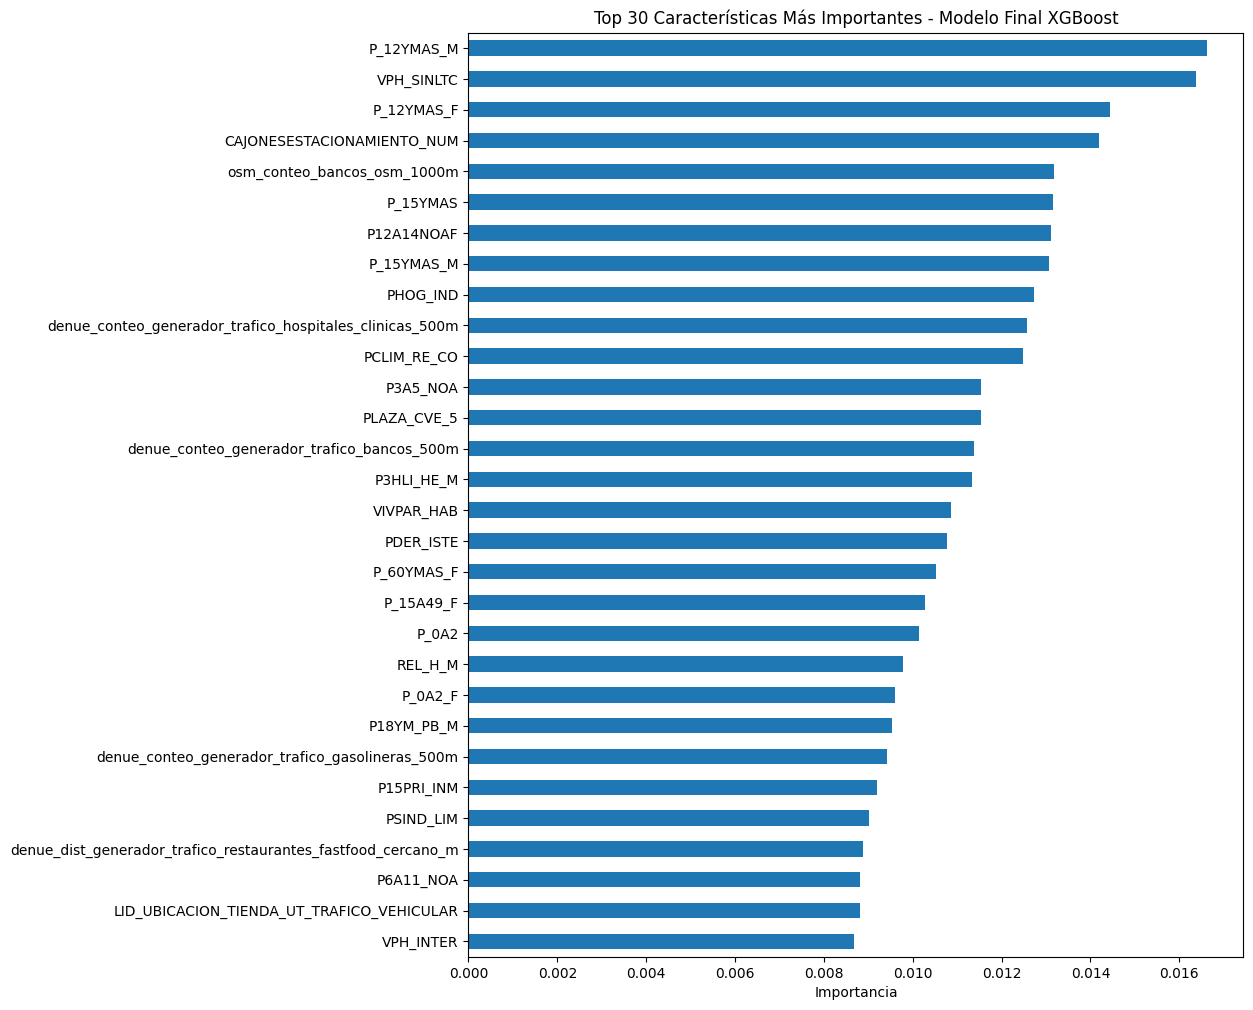


Top 30 Características:
P_12YMAS_M                                                      0.016613
VPH_SINLTC                                                      0.016379
P_12YMAS_F                                                      0.014446
CAJONESESTACIONAMIENTO_NUM                                      0.014188
osm_conteo_bancos_osm_1000m                                     0.013185
P_15YMAS                                                        0.013161
P12A14NOAF                                                      0.013115
P_15YMAS_M                                                      0.013060
PHOG_IND                                                        0.012722
denue_conteo_generador_trafico_hospitales_clinicas_500m         0.012561
PCLIM_RE_CO                                                     0.012487
P3A5_NOA                                                        0.011546
PLAZA_CVE_5                                                     0.011543
denue_conteo_generador_tra

In [ ]:
print("\n--- Importancia de Características del Modelo Final XGBoost ---")
if isinstance(X_train, pd.DataFrame):
    feature_importances = pd.Series(modelo_final_xgb.feature_importances_, index=X_train.columns)
    importances_plot = feature_importances.nlargest(30).sort_values().plot(kind='barh', figsize=(10, 12))
    plt.title('Top 30 Características Más Importantes - Modelo Final XGBoost')
    plt.xlabel('Importancia')
    plt.show()
    print("\nTop 30 Características:")
    print(feature_importances.nlargest(30))
else:
    print("X_train no es un DataFrame de Pandas, no se pueden mostrar nombres de features directamente.")
    # Si guardaste 'columnas_procesadas_finales.json', cárgalo aquí para los nombres
    # print(modelo_final_xgb.feature_importances_)



=== PASO FINAL: Generando y Evaluando Predicciones para el Conjunto de TEST OFICIAL ===
Cargando X_test_oficial_procesado desde: ./datos/output/procesado_para_modelado/
X_test_oficial_procesado cargado. Shape: (105, 334)
Target real y_test_oficial_real cargado y alineado: 105 etiquetas.
Modelo final XGBoost cargado.

Generando predicciones en X_test_oficial_cargado...
Predicciones generadas.

--- Evaluación del Modelo Final en Conjunto de TEST OFICIAL (DIM_TIENDA_TEST.csv) ---

--- Evaluación: Modelo Final XGBoost (en Test Oficial) ---
Accuracy: 0.9143 (Objetivo > 0.80)
Precision: 0.9792
Recall: 0.9307
F1-score: 0.9543
ROC AUC: 0.8490

Classification Report:
              precision    recall  f1-score   support

           0       0.22      0.50      0.31         4
           1       0.98      0.93      0.95       101

    accuracy                           0.91       105
   macro avg       0.60      0.72      0.63       105
weighted avg       0.95      0.91      0.93       105


Con

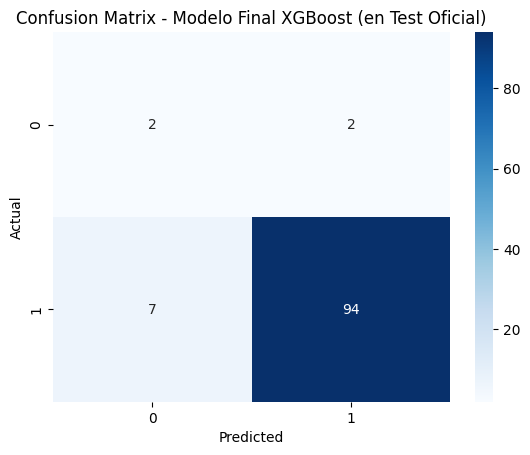


¡FELICIDADES! El modelo cumple el objetivo de asertividad (>80%) en el Test Oficial: 0.9143

Predicciones y target real para DIM_TIENDA_TEST guardadas en './datos/output/procesado_para_modelado/predicciones_evaluacion_DIM_TIENDA_TEST_OFICIAL.csv'
   TIENDA_ID  EXITO_REAL  PREDICCION_EXITO  PROBABILIDAD_EXITO_1
0        680           1                 1              0.868754
1        730           1                 1              0.851796
2        650           1                 1              0.761659
3        670           1                 1              0.688293
4        800           1                 0              0.438835

--- Proceso de Generación y Evaluación de Predicciones para Test Oficial Completado ---


In [29]:
print("\n\n==============================================================================")
print("=== PASO FINAL: Generando y Evaluando Predicciones para el Conjunto de TEST OFICIAL ===")
print("==============================================================================")

import json
import pandas as pd
import numpy as np
import joblib

RUTA_DATOS_PROCESADOS = './datos/output/procesado_para_modelado/'
ARCHIVO_DIM_TIENDA_TEST = './datos/DIM_TIENDA_TEST.csv'

# --- Cargar el X_test_oficial_procesado y los nombres de columnas ---
try:
    print(f"Cargando X_test_oficial_procesado desde: {RUTA_DATOS_PROCESADOS}")
    # (Lógica de carga de X_test_oficial_cargado como en la respuesta anterior,
    #  ya sea desde CSV + JSON de columnas, o NPY + JSON de columnas)
    # ...
    # Suponemos que al final tienes X_test_oficial_cargado (DataFrame de Pandas)
    # ...
    with open(RUTA_DATOS_PROCESADOS + 'columnas_procesadas_finales.json', 'r') as f: # Asegurar que tenemos los nombres
        nombres_columnas_procesadas_test = json.load(f)
    try:
        X_test_oficial_cargado = pd.read_csv(RUTA_DATOS_PROCESADOS + 'X_test_oficial_procesado.csv')
        # Asegurar orden y columnas
        missing_cols_in_test_csv = set(nombres_columnas_procesadas_test) - set(X_test_oficial_cargado.columns)
        if missing_cols_in_test_csv: raise ValueError(f"Faltan columnas en X_test_oficial_procesado.csv: {missing_cols_in_test_csv}")
        extra_cols_in_test_csv = set(X_test_oficial_cargado.columns) - set(nombres_columnas_procesadas_test)
        if extra_cols_in_test_csv: X_test_oficial_cargado = X_test_oficial_cargado.drop(columns=list(extra_cols_in_test_csv))
        X_test_oficial_cargado = X_test_oficial_cargado[nombres_columnas_procesadas_test]
    except FileNotFoundError:
        X_test_oficial_arr_cargado = np.load(RUTA_DATOS_PROCESADOS + 'X_test_oficial_procesado.npy', allow_pickle=True)
        X_test_oficial_cargado = pd.DataFrame(X_test_oficial_arr_cargado, columns=nombres_columnas_procesadas_test)
    print(f"X_test_oficial_procesado cargado. Shape: {X_test_oficial_cargado.shape}")


    # --- Cargar el y_test_oficial_real (el target real para DIM_TIENDA_TEST) ---
    ARCHIVO_Y_TEST_OFICIAL_REAL = RUTA_DATOS_PROCESADOS + 'y_test_oficial_real.csv'
    y_test_oficial_real_df = pd.read_csv(ARCHIVO_Y_TEST_OFICIAL_REAL)
    # Necesitamos alinear y_test_oficial_real_df con el orden de X_test_oficial_cargado
    # Para ello, primero cargamos los TIENDA_ID originales del DIM_TIENDA_TEST.csv
    df_test_original_para_ids = pd.read_csv(ARCHIVO_DIM_TIENDA_TEST) # Usamos el original de `./datos/`
    
    # Crear un DataFrame temporal con TIENDA_ID para el X_test_oficial (que ya está procesado y ordenado)
    # Necesitamos una forma de mapear el índice de X_test_oficial_cargado a los TIENDA_ID.
    # Si X_test_oficial_cargado mantuvo el índice original de df_test_oficial_gdf (del notebook 07b),
    # y ese índice original de df_test_oficial_gdf es el mismo que el de df_test_original_para_ids.
    # La forma más segura es: X_test_oficial_cargado debería tener el mismo número de filas que df_test_original_para_ids
    if len(df_test_original_para_ids) != len(X_test_oficial_cargado):
        raise ValueError("El número de filas en DIM_TIENDA_TEST.csv original no coincide con X_test_oficial_cargado.")

    # Unir y_test_oficial_real_df con los TIENDA_ID en el orden de X_test_oficial_cargado
    # Asumimos que df_test_original_para_ids tiene el orden correcto y X_test_oficial_cargado también
    temp_df_test_ids = pd.DataFrame({'TIENDA_ID': df_test_original_para_ids['TIENDA_ID']})
    temp_df_test_con_y_real = temp_df_test_ids.merge(y_test_oficial_real_df, on='TIENDA_ID', how='left')
    
    if temp_df_test_con_y_real['EXITO_REAL'].isnull().any():
        print("ADVERTENCIA: Algunos TIENDA_ID del test oficial no tienen un EXITO_REAL correspondiente.")
        # Decide cómo manejar esto: eliminar esas filas de X_test_oficial_cargado y temp_df_test_con_y_real,
        # o investigar por qué faltan. Por ahora, se eliminarán para la evaluación.
        indices_con_y_real = temp_df_test_con_y_real.dropna(subset=['EXITO_REAL']).index
        X_test_oficial_cargado = X_test_oficial_cargado.iloc[indices_con_y_real]
        y_test_oficial_real_final = temp_df_test_con_y_real['EXITO_REAL'].iloc[indices_con_y_real].values
        df_ids_para_pred_final = temp_df_test_ids.iloc[indices_con_y_real]['TIENDA_ID'].values
        print(f"Evaluación se realizará sobre {len(y_test_oficial_real_final)} tiendas de test con target real.")
    else:
        y_test_oficial_real_final = temp_df_test_con_y_real['EXITO_REAL'].values
        df_ids_para_pred_final = temp_df_test_ids['TIENDA_ID'].values

    print(f"Target real y_test_oficial_real cargado y alineado: {len(y_test_oficial_real_final)} etiquetas.")


    # --- Cargar el modelo final entrenado ---
    modelo_final_cargado = joblib.load(RUTA_DATOS_PROCESADOS + 'modelo_final_xgb.joblib')
    print("Modelo final XGBoost cargado.")

    # --- Generar Predicciones en X_test_oficial_cargado ---
    print("\nGenerando predicciones en X_test_oficial_cargado...")
    predicciones_test_oficial = modelo_final_cargado.predict(X_test_oficial_cargado)
    predicciones_proba_test_oficial = modelo_final_cargado.predict_proba(X_test_oficial_cargado)[:, 1]
    print("Predicciones generadas.")

    # --- Evaluar el Modelo en el Conjunto de TEST OFICIAL ---
    # Usar la función evaluar_modelo definida en el notebook 09_...
    # Asegúrate de que la función evaluar_modelo esté disponible aquí (copia su definición o impórtala)
    # def evaluar_modelo(...): ... (definición de la función)
    print("\n--- Evaluación del Modelo Final en Conjunto de TEST OFICIAL (DIM_TIENDA_TEST.csv) ---")
    res_test_oficial = evaluar_modelo(
        "Modelo Final XGBoost (en Test Oficial)", 
        y_test_oficial_real_final, 
        predicciones_test_oficial, 
        predicciones_proba_test_oficial
    )
    # Aquí podrías añadir res_test_oficial a una lista si quieres comparar con el rendimiento en validación.
    if res_test_oficial["accuracy"] > 0.80:
        print(f"\n¡FELICIDADES! El modelo cumple el objetivo de asertividad (>80%) en el Test Oficial: {res_test_oficial['accuracy']:.4f}")
    else:
        print(f"\nEl modelo NO cumple el objetivo de asertividad (>80%) en el Test Oficial: {res_test_oficial['accuracy']:.4f}")


    # --- Guardar las predicciones junto con el target real y los TIENDA_ID ---
    df_predicciones_salida = pd.DataFrame({
        'TIENDA_ID': df_ids_para_pred_final,
        'EXITO_REAL': y_test_oficial_real_final,
        'PREDICCION_EXITO': predicciones_test_oficial,
        'PROBABILIDAD_EXITO_1': predicciones_proba_test_oficial
    })
    
    df_predicciones_salida.to_csv(RUTA_DATOS_PROCESADOS + 'predicciones_evaluacion_DIM_TIENDA_TEST_OFICIAL.csv', index=False)
    print(f"\nPredicciones y target real para DIM_TIENDA_TEST guardadas en '{RUTA_DATOS_PROCESADOS}predicciones_evaluacion_DIM_TIENDA_TEST_OFICIAL.csv'")
    print(df_predicciones_salida.head())

except FileNotFoundError as e:
    print(f"Error: Archivo no encontrado. Asegúrate de que los datos procesados, el modelo y el target de test real existan. Detalle: {e}")
    print("Verifica que 'y_test_oficial_real.csv' se haya creado y esté en la ruta correcta.")
except Exception as e:
    print(f"Error generando/evaluando predicciones para el Test Oficial: {e}")
    raise

print("\n--- Proceso de Generación y Evaluación de Predicciones para Test Oficial Completado ---")

In [37]:
# ============================================================================================
# === MODELO ADICIONAL 1: XGBoost Refinado (Orig+ScalePW, Foco Clase 0) en TEST OFICIAL ===
# ============================================================================================
print("\n\n==============================================================================")
print("=== MODELO ADICIONAL 1: XGBoost Refinado (Orig+ScalePW) - Evaluación en Test Oficial ===")
print("==============================================================================")

params_xgb_refined_orig = {
    'subsample': 1.0, 
    'reg_lambda': 5, 
    'reg_alpha': 0, 
    'n_estimators': 200, 
    'max_depth': 6, 
    'learning_rate': 0.01, 
    'gamma': 0.1, 
    'colsample_bytree': 1.0
}

# y_train debe estar disponible desde el entrenamiento del modelo principal
if 'y_train' not in locals() or y_train is None:
    raise NameError("La variable 'y_train' no está definida. Asegúrate de que los datos de entrenamiento estén cargados.")

count_neg_ref_orig, count_pos_ref_orig = y_train.value_counts().sort_index()
scale_pos_w_ref_orig = count_neg_ref_orig / count_pos_ref_orig
print(f"Usando scale_pos_weight para XGBoost Refinado (Orig): {scale_pos_w_ref_orig:.4f}")

modelo_xgb_refinado_orig_add = xgb.XGBClassifier( # Nuevo nombre para no sobrescribir
    **params_xgb_refined_orig,
    scale_pos_weight=scale_pos_w_ref_orig,
    random_state=RANDOM_STATE,
    use_label_encoder=False,
    eval_metric='logloss'
)

print("\nEntrenando XGBoost Refinado (Orig+ScalePW) con X_train y y_train...")
try:
    start_time = time()
    modelo_xgb_refinado_orig_add.fit(X_train, y_train) # X_train y y_train deben estar disponibles
    end_time = time()
    print(f"Modelo XGBoost Refinado (Orig+ScalePW) entrenado en {end_time - start_time:.2f} segundos.")

    joblib.dump(modelo_xgb_refinado_orig_add, RUTA_DATOS_PROCESADOS + 'modelo_xgb_refinado_orig_clase0_ADD.joblib')
    print(f"Modelo XGBoost Refinado (Orig+ScalePW) guardado como 'modelo_xgb_refinado_orig_clase0_ADD.joblib'.")

    # Predicciones en el Test Oficial usando X_test_oficial_cargado y y_test_oficial_real_final
    # Estas variables DEBEN estar definidas por la evaluación de tu modelo principal ANTERIORMENTE en este notebook.
    if 'X_test_oficial_cargado' not in locals() or 'y_test_oficial_real_final' not in locals():
        raise NameError("X_test_oficial_cargado o y_test_oficial_real_final no están definidos. Ejecuta la evaluación del modelo principal primero.")

    print("\nGenerando predicciones en el Test Oficial con XGBoost Refinado (Orig+ScalePW)...")
    predicciones_test_xgb_ref_orig_add = modelo_xgb_refinado_orig_add.predict(X_test_oficial_cargado)

    print("\n--- Matriz de Confusión: XGBoost Refinado (Orig+ScalePW) en Test Oficial ---")
    cm_xgb_ref_orig_add = confusion_matrix(y_test_oficial_real_final, predicciones_test_xgb_ref_orig_add)
    sns.heatmap(cm_xgb_ref_orig_add, annot=True, fmt='d', cmap='Greens')
    plt.title('CM - XGBoost Refinado (Orig+ScalePW) en Test Oficial')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    print("\nClassification Report (XGBoost Refinado Orig+ScalePW en Test Oficial):")
    print(classification_report(y_test_oficial_real_final, predicciones_test_xgb_ref_orig_add, zero_division=0))

except Exception as e:
    print(f"Error con XGBoost Refinado (Orig+ScalePW): {e}")



=== MODELO ADICIONAL 1: XGBoost Refinado (Orig+ScalePW) - Evaluación en Test Oficial ===
Usando scale_pos_weight para XGBoost Refinado (Orig): 0.0456

Entrenando XGBoost Refinado (Orig+ScalePW) con X_train y y_train...


c:\Users\alexg\Documents\code\datathon2025\NaN-Crew-Datathon-2025-OXXO\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [07:28:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Modelo XGBoost Refinado (Orig+ScalePW) entrenado en 0.98 segundos.
Modelo XGBoost Refinado (Orig+ScalePW) guardado como 'modelo_xgb_refinado_orig_clase0_ADD.joblib'.

Generando predicciones en el Test Oficial con XGBoost Refinado (Orig+ScalePW)...

--- Matriz de Confusión: XGBoost Refinado (Orig+ScalePW) en Test Oficial ---



Classification Report (XGBoost Refinado Orig+ScalePW en Test Oficial):
              precision    recall  f1-score   support

           0       0.19      0.75      0.30         4
           1       0.99      0.87      0.93       101

    accuracy                           0.87       105
   macro avg       0.59      0.81      0.61       105
weighted avg       0.96      0.87      0.90       105

